# Tuning

This notebook will demonstrate how to do tuning for models and controllers.

## Set-Up

As always, we begin by obtaining our system, model, and task from the benchmarks package.

In [1]:
import autompc as ampc
import numpy as np
from autompc.benchmarks import PendulumSwingupBenchmark

benchmark = PendulumSwingupBenchmark()

# Get system and task specification
system = benchmark.system
task   = benchmark.task

# Generate benchmark dataset
trajs = benchmark.gen_trajs(seed=100, n_trajs=500, traj_len=200)

Loading AutoMPC...
Finished loading AutoMPC


## Pipeline Tuning

Next, we will demonstrate how to do hyperparameter tuning for the entire MPC pipeline.  First, we create our factories and pipeline object. Here, we use an MLP system ID model, Iterative LQR control optimizer, and a quadratic cost.  AutoMPC does not currently support automatic selection of pipeline components, but we hope to add this feature soon.

In [2]:
from autompc.costs import QuadCostFactory
from autompc.sysid import MLPFactory
from autompc.sysid.auto_model_factory import AutoModelFactory
from autompc.control.auto_controller_factory import AutoControllerFactory

cost_factory  = QuadCostFactory(system)
model_factory = AutoModelFactory(system)
ctrlr_factory = AutoControllerFactory(system)

pipeline = ampc.Pipeline(system, model_factory, cost_factory, ctrlr_factory)

cs = model_factory.get_configuration_space()
cfg = cs.get_default_configuration()
cfg["model"] = "ARX"
model = model_factory(cfg, trajs)
cs = controller_factory.get_configuration_space()
cfg = cs.get_default_configuration()
controller_factory(cfg, task, model)

Next, we instantiate the `PipelineTuner`.  AutoMPC performs tuning without access to the system dynamics, so the tuner has to train a surrogate dynamics model to use a simulator for controller evaluation.  In this example, we use an MLP surrogate model, so we pass in `MLPFactory`.  The `surrogate_split` tells what proportion of the data to use for surrogate training vs system ID training.  Here we use a 50/50 split.

Finally, AutoMPC supports several methods of selecting the surrogate model, controller by the `surrogate_mode` argument.  Here we use `defaultcfg` which means the surrogate is trained using the default MLP configuration.  Other modes include `fixedcfg`, where the user specifies the surrogate configuration, `autotune`, where the tuner first tunes the surrogate factory before running the pipeline tuning, and `autoselect`, where the tuner both automatically selects the model type from the availble system ID algorithms and tunes the model hyperparameters.

For more details on using these modes, see the [documentation](https://autompc.readthedocs.io/en/latest/source/tuning.html#pipelinetuner) for the `PipelineTuner` class.

In [3]:
from autompc.tuning import PipelineTuner

tuner = PipelineTuner(surrogate_factory=MLPFactory(system), surrogate_mode="defaultcfg", surrogate_split=0.5)

/usr/lib/python3/dist-packages/pyparsing.py:1745: FutureWarning: Possible set intersection at position 3
  self.re = re.compile( self.reString )


Now that we have created the tuner, we run it for 100 iterations.  We pass in the ground truth dynamics to keep track of the performance, but in a real application, we don't expect to have access to this, so this information is not used for tuning.

In [4]:
controller, tune_result = tuner.run(pipeline, task, trajs, n_iters=200, rng=np.random.default_rng(100), 
                                   truedyn=benchmark.dynamics)

/home/william/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


MLP Using Cuda
hidden_sizes= [128, 128]
100%|██████████| 50/50 [01:24<00:00,  1.69s/it]

INFO:smac.utils.io.cmd_reader.CMDReader:Output to smac3-output_2021-08-08_16:19:59_308567
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic and only evaluate one configuration per iteration!
INFO:smac.initial_design.latin_hypercube_design.LHDesign:Running initial design for 50 configurations
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:<class 'smac.facade.smac_hpo_facade.SMAC4HPO'>
INFO:smac.optimizer.smbo.SMBO:Running initial design


INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent


MLP Using Cuda
hidden_sizes= [113]
100%|██████████| 50/50 [01:06<00:00,  1.34s/it]

INFO:smac.intensification.intensification.Intensifier:First run, no incumbent provided; challenger is assumed to be the incumbent
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 2147483647.0000


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 67.283092 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.071927 sec, available: 0.000010 sec)
  0%|          | 0/5 [00:00<?, ?it/s]

Cuda is used for GPytorch


100%|██████████| 5/5 [00:14<00:00,  2.89s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 14.487925 sec, available: 0.000010 sec)
  0%|          | 0/5 [00:00<?, ?it/s]

Cuda is used for GPytorch


100%|██████████| 5/5 [00:13<00:00,  2.79s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 13.995163 sec, available: 0.000010 sec)
  0%|          | 0/5 [00:00<?, ?it/s]

Cuda is used for GPytorch


100%|██████████| 5/5 [00:11<00:00,  2.37s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 11.876261 sec, available: 0.000010 sec)


P2=
[[ 9.80709671e+02 -1.03542255e+04  3.21549006e+03  1.77539429e+04
   4.99330685e+02 -4.15794139e+03 -7.94929952e+03 -3.94376150e+02
  -1.05452799e+01]
 [-1.03542255e+04  1.19282742e+05 -3.70566074e+04 -2.04042420e+05
  -5.74511201e+03  4.77164976e+04  9.12261156e+04  4.52585932e+03
   1.20042718e+02]
 [ 3.21549006e+03 -3.70566074e+04  1.15121142e+04  6.33873858e+04
   1.78477610e+03 -1.48233776e+04 -2.83398662e+04 -1.40598168e+03
  -3.72899283e+01]
 [ 1.77539429e+04 -2.04042420e+05  6.33873858e+04  3.49055455e+05
   9.82782729e+03 -8.16323214e+04 -1.56067606e+05 -7.74273923e+03
  -2.05419358e+02]
 [ 4.99330685e+02 -5.74511201e+03  1.78477610e+03  9.82782729e+03
   2.76711904e+02 -2.29834770e+03 -4.39406374e+03 -2.17995846e+02
  -5.78282653e+00]
 [-4.15794139e+03  4.77164976e+04 -1.48233776e+04 -8.16323214e+04
  -2.29834770e+03  1.90916007e+04  3.65000081e+04  1.81081809e+03
   4.80500084e+01]
 [-7.94929952e+03  9.12261156e+04 -2.83398662e+04 -1.56067606e+05
  -4.39406374e+03  3.650

INFO:smac.intensification.intensification.Intensifier:Challenger (200.0000) is better than incumbent (2147483647.0000) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  _cost:ang_F : 1944.6783011976622 -> 11.68655086587555
INFO:smac.intensification.intensification.Intensifier:  _cost:ang_Q : 0.0025285404898697872 -> 3.7057055086740145
INFO:smac.intensification.intensification.Intensifier:  _cost:angvel_F : 611.4502294772293 -> 206.6678164823677
INFO:smac.intensification.intensification.Intensifier:  _cost:angvel_Q : 278.7777384690283 -> 0.0011089084611889328
INFO:smac.intensification.intensification.Intensifier:  _cost:torque_R : 0.12216570142660857 -> 3705.656863326308
INFO:smac.intensification.intensification.Intensifier:  _ctrlr:_DirectTranscription:horizon : None -> 12
INFO:smac.intensification.intensification.Intensifier:  _ctrlr:controller : 'LQR' -> 'DirectTranscription'
INFO:smac.intens


True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.11747511 -0.02198079]
P2=
[[1172.07959187  112.12004675]
 [ 112.12004675   35.73548623]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 2062.34it/s]
Surrogate Cost:  40.0
Surrogate Final State:  [0.02279209 0.0007235 ]
Simulating True Dynamics Trajectory
P2=
[[1172.07959187  112.12004675]
 [ 112.12004675   35.73548623]]
 99%|█████████▉| 198/200 [00:00<00:00, 3246.05it/s]

INFO:smac.intensification.intensification.Intensifier:Challenger (40.0000) is better than incumbent (200.0000) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  _cost:ang_F : 11.68655086587555 -> 1.2571360998151548
INFO:smac.intensification.intensification.Intensifier:  _cost:ang_Q : 3.7057055086740145 -> 184.690973575465
INFO:smac.intensification.intensification.Intensifier:  _cost:angvel_F : 206.6678164823677 -> 5.4201427553058315
INFO:smac.intensification.intensification.Intensifier:  _cost:angvel_Q : 0.0011089084611889328 -> 4.685592733919127
INFO:smac.intensification.intensification.Intensifier:  _cost:torque_R : 3705.656863326308 -> 0.17296764544824475
INFO:smac.intensification.intensification.Intensifier:  _ctrlr:_IterativeLQR:horizon : None -> 9
INFO:smac.intensification.intensification.Intensifier:  _ctrlr:controller : 'DirectTranscription' -> 'IterativeLQR'
INFO:smac.intensification.i


True Dynamics Cost:  40.0
True Dynamics Final State:  [ 2.69562150e-12 -7.88350824e-12]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.122647 sec, available: 0.000010 sec)


Cuda is used for GPytorch


100%|██████████| 5/5 [00:12<00:00,  2.51s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 12.610076 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.227483 sec, available: 0.000010 sec)
/home/william/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.60696e-29): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/william/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.60696e-29): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 33.803729 sec, available: 0.000010 sec)


MLP Using Cuda
hidden_sizes= [106, 211, 238, 132]
100%|██████████| 50/50 [02:19<00:00,  2.80s/it]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 140.026363 sec, available: 0.000010 sec)


ERROR:smac.tae.execute_func.ExecuteTAFuncDict:Singular matrix
Traceback (most recent call last):
  File "/home/william/.local/lib/python3.8/site-packages/smac/tae/execute_func.py", line 207, in run
    rval = self._call_ta(self._ta, config, obj_kwargs)
  File "/home/william/.local/lib/python3.8/site-packages/smac/tae/execute_func.py", line 296, in _call_ta
    return obj(config, **obj_kwargs)
  File "/home/william/proj/autompc_dev/autompc/tuning/pipeline_tuner.py", line 214, in eval_cfg
    controller, cost, model = pipeline(cfg, task, sysid_trajs)
  File "/home/william/proj/autompc_dev/autompc/pipeline.py", line 145, in __call__
    model = self.model_factory(model_cfg, trajs)
  File "/home/william/proj/autompc_dev/autompc/sysid/auto_model_factory.py", line 53, in __call__
    return factory(cfg, *args, **kwargs)
  File "/home/william/proj/autompc_dev/autompc/sysid/model.py", line 41, in __call__
    model.train(train_trajs, silent=silent)
  File "/home/william/proj/autompc_dev/automp

Compute Stable Koopman
None
[[1. 0.]
 [0. 1.]]
Error is  98.83028823459526
MLP Using Cuda
hidden_sizes= [231, 150, 167, 30]
100%|██████████| 50/50 [02:04<00:00,  2.48s/it]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 124.176399 sec, available: 0.000010 sec)
  0%|          | 0/5 [00:00<?, ?it/s]


Cuda is used for GPytorch


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 13.783290 sec, available: 0.000010 sec)


Call Lasso
P2=
[[10.98290181  0.        ]
 [ 0.          0.23494309]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 2024.94it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.15869557 -0.05477603]
Simulating True Dynamics Trajectory
P2=
[[10.98290181  0.        ]
 [ 0.          0.23494309]]
 99%|█████████▉| 198/200 [00:00<00:00, 3179.33it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.424663 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.11735289 -0.02139352]
P2=
[[2.61462723e+02 1.26335746e+02 4.05316854e+02 1.58268772e+01
  1.57847078e+00 2.96298001e+00]
 [1.26335746e+02 8.10463137e+02 1.88672155e+03 6.52466598e+01
  6.38833732e+00 1.21925976e+01]
 [4.05316854e+02 1.88672155e+03 7.44577664e+03 3.01068945e+02
  3.00274180e+01 5.63576093e+01]
 [1.58268772e+01 6.52466598e+01 3.01068945e+02 1.28912219e+01
  1.29571845e+00 2.41505126e+00]
 [1.57847078e+00 6.38833732e+00 3.00274180e+01 1.29571845e+00
  1.30397631e-01 2.42773667e-01]
 [2.96298001e+00 1.21925976e+01 5.63576093e+01 2.41505126e+00
  2.42773667e-01 4.52444199e-01]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 1746.47it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.16016068 -0.04590662]
Simulating True Dynamics Trajectory
P2=
[[2.61462723e+02 1.26335746e+02 4.05316854e+02 1.58268772e+01
  1.57847078e+00 2.96298001e+00]
 [1.26335746e+02 8.10463137e+02 1.88672155e+03 6.

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.983706 sec, available: 0.000010 sec)
  0%|          | 0/5 [00:00<?, ?it/s]


True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.12030904 -0.02383316]
Cuda is used for GPytorch


100%|██████████| 5/5 [00:12<00:00,  2.49s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 12.500995 sec, available: 0.000010 sec)


P2=
[[ 7.17226715e+02  6.55265376e+01  2.62660095e-03  3.18194107e-04
  -5.25320416e-04  3.18194107e-04 -5.25320416e-04  3.18194107e-04
  -5.25320416e-04  3.18194107e-04 -5.25320416e-04  3.18194107e-04
  -5.25320416e-04  3.18178024e-04]
 [ 6.55265376e+01  8.30946207e+02  2.59635105e-04  3.14529546e-05
  -5.19270433e-05  3.14529546e-05 -5.19270433e-05  3.14529546e-05
  -5.19270433e-05  3.14529546e-05 -5.19270433e-05  3.14529546e-05
  -5.19270433e-05  3.14513648e-05]
 [ 2.62660095e-03  2.59635105e-04  1.04073531e-08  1.26077676e-09
  -2.08147152e-09  1.26077676e-09 -2.08147152e-09  1.26077676e-09
  -2.08147152e-09  1.26077676e-09 -2.08147152e-09  1.26077676e-09
  -2.08147152e-09  1.26071304e-09]
 [ 3.18194108e-04  3.14529547e-05  1.26077676e-09  8.20602791e-10
  -2.52155914e-10  8.20602791e-10 -2.52155914e-10  8.20602791e-10
  -2.52155914e-10  8.20602791e-10 -2.52155914e-10  8.20602791e-10
  -2.52155914e-10  8.20595072e-10]
 [-5.25320416e-04 -5.19270433e-05 -2.08147152e-09 -2.52155913e-1

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.048271 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.0078977  -0.11037018]
MLP Using Cuda
hidden_sizes= [53, 235]
100%|██████████| 50/50 [01:23<00:00,  1.67s/it]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 83.710125 sec, available: 0.000010 sec)



P2=
[[ 1.75034969e+02  2.05285750e+01  1.10211609e+00  4.95361265e+01
   8.84166703e-02 -1.69533419e+01 -3.06211624e+01 -2.45853366e+00
  -6.49940507e+00 -1.96453227e+01 -9.70103842e-01 -4.45704200e-01
  -8.42786180e+00  9.49248374e-04  1.27454649e+00 -6.81370961e-02
   4.23400356e-01 -5.74511295e-02  4.20630141e+00  4.29809556e-01
  -2.28033599e+00  4.42152937e+00  2.21763477e-01 -3.88828204e+00
   1.55754198e+00  3.71091918e-03 -2.91961492e+00 -1.27768169e+00
  -6.88473902e-02 -2.14559988e-01]
 [ 2.05285750e+01  8.35158165e+02 -2.81166570e+02 -1.21325543e+03
  -3.96887764e+01  1.55513280e+02  1.80149076e+02  2.13784711e+01
   8.80548045e+01  1.60048961e+02  1.28304038e+01  3.03621233e+01
   1.08130515e+02  5.00050648e+00 -9.42752900e+00  4.99163692e+01
  -3.85140547e-01 -1.84921873e+01 -1.19738796e-01 -2.90351762e+00
  -1.32265710e+01 -3.21381784e+01 -2.90612928e+00  8.14233436e+00
  -4.70457785e+01 -1.28691089e+00  4.57771401e+01  1.98499166e+01
   1.07176548e+00  8.59732370e-01]
 

 99%|█████████▉| 198/200 [00:00<00:00, 2885.50it/s]
Surrogate Cost:  33.0
Surrogate Final State:  [0.00172733 0.00057216]
Simulating True Dynamics Trajectory
P2=
[[ 1.75034969e+02  2.05285750e+01  1.10211609e+00  4.95361265e+01
   8.84166703e-02 -1.69533419e+01 -3.06211624e+01 -2.45853366e+00
  -6.49940507e+00 -1.96453227e+01 -9.70103842e-01 -4.45704200e-01
  -8.42786180e+00  9.49248374e-04  1.27454649e+00 -6.81370961e-02
   4.23400356e-01 -5.74511295e-02  4.20630141e+00  4.29809556e-01
  -2.28033599e+00  4.42152937e+00  2.21763477e-01 -3.88828204e+00
   1.55754198e+00  3.71091918e-03 -2.91961492e+00 -1.27768169e+00
  -6.88473902e-02 -2.14559988e-01]
 [ 2.05285750e+01  8.35158165e+02 -2.81166570e+02 -1.21325543e+03
  -3.96887764e+01  1.55513280e+02  1.80149076e+02  2.13784711e+01
   8.80548045e+01  1.60048961e+02  1.28304038e+01  3.03621233e+01
   1.08130515e+02  5.00050648e+00 -9.42752900e+00  4.99163692e+01
  -3.85140547e-01 -1.84921873e+01 -1.19738796e-01 -2.90351762e+00
  -1.322657

 99%|█████████▉| 198/200 [00:00<00:00, 3063.48it/s]

INFO:smac.intensification.intensification.Intensifier:Challenger (33.0000) is better than incumbent (40.0000) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  _cost:ang_F : 1.2571360998151548 -> 137.628689808913
INFO:smac.intensification.intensification.Intensifier:  _cost:ang_Q : 184.690973575465 -> 16.065217369830144
INFO:smac.intensification.intensification.Intensifier:  _cost:angvel_F : 5.4201427553058315 -> 4118.2045070807235
INFO:smac.intensification.intensification.Intensifier:  _cost:angvel_Q : 4.685592733919127 -> 0.003929492720314342
INFO:smac.intensification.intensification.Intensifier:  _cost:torque_R : 0.17296764544824475 -> 0.03795466308547854
INFO:smac.intensification.intensification.Intensifier:  _ctrlr:_IterativeLQR:horizon : 9 -> 23
INFO:smac.intensification.intensification.Intensifier:  _model:_ARX:history : None -> 10
INFO:smac.intensification.intensification.Intensifier:  


True Dynamics Cost:  33.0
True Dynamics Final State:  [-5.29476633e-04  3.28948646e-12]
P2=
[[ 6.28945094e+03  9.70350166e+01  1.38215218e+01  1.01173963e+02
   2.48687298e+00 -2.07379764e+01 -3.19749820e+01 -2.63698284e+00
  -8.87983840e+00 -2.67409565e+01 -1.08762174e+00 -4.24688662e+00
   4.63944490e+00  2.33936319e-01 -8.92668048e-02]
 [ 9.70350166e+01  1.94886971e+03 -1.78205149e+02 -8.20946677e+02
  -2.62965056e+01  1.14147881e+02  1.61740742e+02  1.50153931e+01
   5.20497438e+01  1.60951125e+02  7.20372249e+00  2.87846724e+01
  -1.56698927e+01 -7.65927061e-01  4.94829231e-01]
 [ 1.38215218e+01 -1.78205149e+02  5.87037099e+01  2.71178651e+02
   8.65440306e+00 -3.78560128e+01 -5.40934343e+01 -4.99291539e+00
  -1.73100530e+01 -5.31917834e+01 -2.37965567e+00 -9.51751739e+00
   5.19941626e+00  2.54197879e-01 -1.61093814e-01]
 [ 1.01173963e+02 -8.20946677e+02  2.71178651e+02  1.27453669e+03
   4.02156734e+01 -1.82587789e+02 -2.62504410e+02 -2.39435807e+01
  -8.32496442e+01 -2.5164094

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.491959 sec, available: 0.000010 sec)
  0%|          | 0/5 [00:00<?, ?it/s]


True Dynamics Cost:  200.0
True Dynamics Final State:  [ 0.45211682 -0.08456421]
Cuda is used for GPytorch


100%|██████████| 5/5 [00:12<00:00,  2.51s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 12.575713 sec, available: 0.000010 sec)
ERROR:smac.tae.execute_func.ExecuteTAFuncDict:Singular matrix
Traceback (most recent call last):
  File "/home/william/.local/lib/python3.8/site-packages/smac/tae/execute_func.py", line 207, in run
    rval = self._call_ta(self._ta, config, obj_kwargs)
  File "/home/william/.local/lib/python3.8/site-packages/smac/tae/execute_func.py", line 296, in _call_ta
    return obj(config, **obj_kwargs)
  File "/home/william/proj/autompc_dev/autompc/tuning/pipeline_tuner.py", line 214, in eval_cfg
    controller, cost, model = pipeline(cfg, task, sysid_trajs)
  File "/home/william/proj/autompc_dev/autompc/pipeline.py", line 145, in __call__
    model = self.model_factory(model_cfg, trajs)
  File "/home/william/proj/autompc_dev/autompc/sysid/auto_model_factory.py", line 53, in __call__
    return factory(

Compute Stable Koopman
None
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Error is  34287679304.18895


ERROR:smac.tae.execute_func.ExecuteTAFuncDict:Singular matrix
Traceback (most recent call last):
  File "/home/william/.local/lib/python3.8/site-packages/smac/tae/execute_func.py", line 207, in run
    rval = self._call_ta(self._ta, config, obj_kwargs)
  File "/home/william/.local/lib/python3.8/site-packages/smac/tae/execute_func.py", line 296, in _call_ta
    return obj(config, **obj_kwargs)
  File "/home/william/proj/autompc_dev/autompc/tuning/pipeline_tuner.py", line 214, in eval_cfg
    controller, cost, model = pipeline(cfg, task, sysid_trajs)
  File "/home/william/proj/autompc_dev/autompc/pipeline.py", line 145, in __call__
    model = self.model_factory(model_cfg, trajs)
  File "/home/william/proj/autompc_dev/autompc/sysid/auto_model_factory.py", line 53, in __call__
    return factory(cfg, *args, **kwargs)
  File "/home/william/proj/autompc_dev/autompc/sysid/model.py", line 41, in __call__
    model.train(train_trajs, silent=silent)
  File "/home/william/proj/autompc_dev/automp

Compute Stable Koopman
None
[[1. 0.]
 [0. 1.]]
Error is  98.83028823459526
MLP Using Cuda
hidden_sizes= [45]
100%|██████████| 50/50 [01:04<00:00,  1.28s/it]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 64.239226 sec, available: 0.000010 sec)


/home/william/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.23936e-28): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/william/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.23936e-28): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 32.614905 sec, available: 0.000010 sec)


P2=
[[ 1.42709077e+03  2.71921792e+03 -8.47922422e+02 -3.39050343e+03
  -1.19831743e+02  3.63726689e+02  3.73212194e+02  5.04243935e+01
   2.12031406e+02  4.70126367e+02  3.28172203e+01  2.56156311e+01
   4.74883430e+02  9.66741890e+00  5.96403695e+01 -2.84888232e+02
  -1.40731470e+01  8.84555096e-01]
 [ 2.71921792e+03  2.68062465e+04 -8.73363921e+03 -3.76657783e+04
  -1.25037257e+03  4.76367109e+03  5.59810774e+03  6.43803422e+02
   2.62078290e+03  5.87307303e+03  3.76601309e+02  4.07062378e+02
   5.01793274e+03  8.68324909e+01  6.95729800e+02 -3.32626445e+03
  -1.64325767e+02  1.77618861e+01]
 [-8.47922422e+02 -8.73363921e+03  2.84816983e+03  1.22951513e+04
   4.07815430e+02 -1.55789099e+03 -1.83341769e+03 -2.10507434e+02
  -8.56542062e+02 -1.91996033e+03 -1.22987468e+02 -1.33386392e+02
  -1.63684969e+03 -2.82573020e+01 -2.27236256e+02  1.08641908e+03
   5.36718519e+01 -5.82549117e+00]
 [-3.39050343e+03 -3.76657783e+04  1.22951513e+04  5.32104197e+04
   1.76140187e+03 -6.77495297e+03

 99%|█████████▉| 198/200 [00:00<00:00, 2937.48it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.420982 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.11706803 -0.02066991]
P2=
[[4.55985324e+03 2.50564379e+03 3.69092728e+01]
 [2.50564379e+03 1.38103738e+03 2.03556441e+01]
 [3.69092728e+01 2.03556441e+01 3.00125873e-01]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 2070.05it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.15215615 -0.0414504 ]
Simulating True Dynamics Trajectory
P2=
[[4.55985324e+03 2.50564379e+03 3.69092728e+01]
 [2.50564379e+03 1.38103738e+03 2.03556441e+01]
 [3.69092728e+01 2.03556441e+01 3.00125873e-01]]
 99%|█████████▉| 198/200 [00:00<00:00, 2647.03it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.653263 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.11571679 -0.01517418]
P2=
[[ 2.34967028e+03  1.06968788e+03  1.10516754e+02  3.68775496e+03
   9.28341341e+00 -1.28312073e+03 -2.28321402e+03 -1.80121634e+02
  -5.57064525e+02 -1.45905290e+03 -6.89064491e+01 -1.54356072e+02
  -6.06325347e+02  3.47430768e+00 -6.23332353e+01  3.23548517e+01
   3.41557146e+01 -1.78953656e+02  3.56034233e+02  3.30569817e+01
  -2.41491995e+02  3.20804946e+02  1.57031178e+01 -1.30210148e+01]
 [ 1.06968788e+03  2.76603364e+05 -9.34493042e+04 -3.95751124e+05
  -1.31060162e+04  4.89180004e+04  5.60282520e+04  6.80745084e+03
   2.79143497e+04  5.15070202e+04  4.15285943e+03  9.46508863e+03
   3.58773976e+04  1.63197669e+03 -3.52257531e+03  1.73398896e+04
  -1.56691424e+02 -6.59429830e+03  7.04174281e+02 -1.03282455e+03
   1.64868783e+04 -2.19083695e+04 -1.07229575e+03  2.15846906e+02]
 [ 1.10516754e+02 -9.34493042e+04  3.21277139e+04  1.36801662e+05
   4.50373807e+03 -1.70869011e+04 -1.97292878e+04 -2.3

 99%|█████████▉| 198/200 [00:00<00:00, 2547.39it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [3.05216271 0.00777058]
Simulating True Dynamics Trajectory
P2=
[[ 2.34967028e+03  1.06968788e+03  1.10516754e+02  3.68775496e+03
   9.28341341e+00 -1.28312073e+03 -2.28321402e+03 -1.80121634e+02
  -5.57064525e+02 -1.45905290e+03 -6.89064491e+01 -1.54356072e+02
  -6.06325347e+02  3.47430768e+00 -6.23332353e+01  3.23548517e+01
   3.41557146e+01 -1.78953656e+02  3.56034233e+02  3.30569817e+01
  -2.41491995e+02  3.20804946e+02  1.57031178e+01 -1.30210148e+01]
 [ 1.06968788e+03  2.76603364e+05 -9.34493042e+04 -3.95751124e+05
  -1.31060162e+04  4.89180004e+04  5.60282520e+04  6.80745084e+03
   2.79143497e+04  5.15070202e+04  4.15285943e+03  9.46508863e+03
   3.58773976e+04  1.63197669e+03 -3.52257531e+03  1.73398896e+04
  -1.56691424e+02 -6.59429830e+03  7.04174281e+02 -1.03282455e+03
   1.64868783e+04 -2.19083695e+04 -1.07229575e+03  2.15846906e+02]
 [ 1.10516754e+02 -9.34493042e+04  3.212771

 99%|█████████▉| 198/200 [00:00<00:00, 3144.17it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.840588 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.09865106e+00 -3.00280238e-05]
MLP Using Cuda
hidden_sizes= [29, 108, 63]
100%|██████████| 50/50 [01:48<00:00,  2.16s/it]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 108.253936 sec, available: 0.000010 sec)



P2=
[[ 8.74366000e+00  4.71304951e+01 -1.54802501e+01 -6.32346649e+01
  -2.17794851e+00  7.25099080e+00  7.72541500e+00  1.00113324e+00
   4.27760135e+00  7.49460980e+00  6.37133965e-01  1.50044950e+00
   5.49177122e+00  2.70987309e-01 -6.09386006e-01  2.88837441e+00
  -2.53345218e-03 -1.23360728e+00  3.80837579e-01 -1.48136282e-01
   2.57614208e+00 -3.42371002e+00 -1.67565541e-01  2.84911037e-02]
 [ 4.71304951e+01  3.38422110e+02 -1.11920671e+02 -4.60101186e+02
  -1.57396142e+01  5.34946922e+01  5.77740428e+01  7.39523988e+00
   3.13670663e+01  5.54732195e+01  4.67011508e+00  1.09318157e+01
   4.02749709e+01  1.95906541e+00 -4.38213145e+00  2.08730852e+01
  -4.72129358e-02 -8.74113440e+00  2.42099804e+00 -1.09982695e+00
   1.88192826e+01 -2.50101133e+01 -1.22407436e+00  2.15202912e-01]
 [-1.54802501e+01 -1.11920671e+02  3.70289584e+01  1.52270255e+02
   5.20732651e+00 -1.77154340e+01 -1.91445705e+01 -2.44919741e+00
  -1.03845915e+01 -1.83736953e+01 -1.54612873e+00 -3.61793797e+00
  -

 99%|█████████▉| 198/200 [00:00<00:00, 1849.36it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.15867456 -0.05472494]
Simulating True Dynamics Trajectory
P2=
[[ 8.74366000e+00  4.71304951e+01 -1.54802501e+01 -6.32346649e+01
  -2.17794851e+00  7.25099080e+00  7.72541500e+00  1.00113324e+00
   4.27760135e+00  7.49460980e+00  6.37133965e-01  1.50044950e+00
   5.49177122e+00  2.70987309e-01 -6.09386006e-01  2.88837441e+00
  -2.53345218e-03 -1.23360728e+00  3.80837579e-01 -1.48136282e-01
   2.57614208e+00 -3.42371002e+00 -1.67565541e-01  2.84911037e-02]
 [ 4.71304951e+01  3.38422110e+02 -1.11920671e+02 -4.60101186e+02
  -1.57396142e+01  5.34946922e+01  5.77740428e+01  7.39523988e+00
   3.13670663e+01  5.54732195e+01  4.67011508e+00  1.09318157e+01
   4.02749709e+01  1.95906541e+00 -4.38213145e+00  2.08730852e+01
  -4.72129358e-02 -8.74113440e+00  2.42099804e+00 -1.09982695e+00
   1.88192826e+01 -2.50101133e+01 -1.22407436e+00  2.15202912e-01]
 [-1.54802501e+01 -1.11920671e+02  3.7028

 99%|█████████▉| 198/200 [00:00<00:00, 1492.94it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.728947 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.11734804 -0.02138067]


/home/william/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.58142e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/william/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.58142e-20): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/william/.local/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:144: UserWarning: Sparsity parameter is too big (5.519172419026904) and eliminated all coefficients
  warnings.warn(
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.283659 sec, available: 0.000010 sec)


MLP Using Cuda
hidden_sizes= [228]
100%|██████████| 50/50 [01:08<00:00,  1.37s/it]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 68.439267 sec, available: 0.000010 sec)
  0%|          | 0/5 [00:00<?, ?it/s]


Cuda is used for GPytorch


100%|██████████| 5/5 [00:12<00:00,  2.47s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 12.358667 sec, available: 0.000010 sec)
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.232468 sec, available: 0.000010 sec)


MLP Using Cuda
hidden_sizes= [110, 50]
100%|██████████| 50/50 [01:51<00:00,  2.24s/it]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 111.998224 sec, available: 0.000010 sec)


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.732009 sec, available: 0.000010 sec)


P2=
[[ 3.41076238e+03  2.05348463e+04 -6.72488626e+03 -2.76682851e+04
  -9.51696229e+02  3.22163856e+03  3.38209132e+03  4.39281898e+02
   1.91934222e+03  3.25239156e+03  2.79917576e+02  7.11970569e+02
   2.35308182e+03  1.21108985e+02 -1.96397990e+02  1.20587286e+03
   3.99757407e+00 -4.55669570e+02  1.26996686e+02 -5.67340938e+01
  -3.92788402e+02 -6.40415000e+02 -6.32066767e+01  7.77718901e+01
  -1.08243809e+03 -3.07872301e+01  1.01052229e+03  4.37972717e+02
   2.36501672e+01  1.35794275e+01]
 [ 2.05348463e+04  1.55263155e+05 -5.11370672e+04 -2.11638029e+05
  -7.23485202e+03  2.49376570e+04  2.65104803e+04  3.40638779e+03
   1.47544277e+04  2.52643389e+04  2.15604184e+03  5.40437423e+03
   1.81344042e+04  9.22114531e+02 -1.55073074e+03  9.18038676e+03
   1.95232007e+01 -3.48150340e+03  8.53296502e+02 -4.42868349e+02
  -2.93307225e+03 -4.99046679e+03 -4.86494047e+02  6.96590548e+02
  -8.26608090e+03 -2.34003631e+02  7.75667421e+03  3.36224739e+03
   1.81553715e+02  1.07402107e+02]
 [

 99%|█████████▉| 198/200 [00:00<00:00, 1233.65it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [3.05371821 0.02303123]
Simulating True Dynamics Trajectory
P2=
[[ 3.41076238e+03  2.05348463e+04 -6.72488626e+03 -2.76682851e+04
  -9.51696229e+02  3.22163856e+03  3.38209132e+03  4.39281898e+02
   1.91934222e+03  3.25239156e+03  2.79917576e+02  7.11970569e+02
   2.35308182e+03  1.21108985e+02 -1.96397990e+02  1.20587286e+03
   3.99757407e+00 -4.55669570e+02  1.26996686e+02 -5.67340938e+01
  -3.92788402e+02 -6.40415000e+02 -6.32066767e+01  7.77718901e+01
  -1.08243809e+03 -3.07872301e+01  1.01052229e+03  4.37972717e+02
   2.36501672e+01  1.35794275e+01]
 [ 2.05348463e+04  1.55263155e+05 -5.11370672e+04 -2.11638029e+05
  -7.23485202e+03  2.49376570e+04  2.65104803e+04  3.40638779e+03
   1.47544277e+04  2.52643389e+04  2.15604184e+03  5.40437423e+03
   1.81344042e+04  9.22114531e+02 -1.55073074e+03  9.18038676e+03
   1.95232007e+01 -3.48150340e+03  8.53296502e+02 -4.42868349e+02
  -2.93307

 99%|█████████▉| 198/200 [00:00<00:00, 3129.68it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.131884 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [3.05232652 0.0255422 ]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.091681 sec, available: 0.000010 sec)


Call Lasso


/home/william/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1009890296897415.9, tolerance: 1958941854107.1729
  model = cd_fast.enet_coordinate_descent(


P2=
[[ 1.74856811e+04  8.75189667e+02 -7.83131647e-12 -8.37184560e-06
   2.89429425e-12 -2.06965255e-07  7.15515281e-14 -5.11650819e-09
   1.76886686e-15 -1.26488169e-10  4.37291842e-17 -3.12698744e-12
   1.08105451e-18 -7.73040472e-14]
 [ 8.75189667e+02  2.63164352e+03  7.57863075e-11 -1.83464386e-05
   6.34268645e-12 -4.53552957e-07  1.56801233e-13 -1.12125459e-08
   3.87637430e-15 -2.77191856e-10  9.58300991e-17 -6.85262073e-12
   2.36907142e-18 -1.69407557e-13]
 [-7.83131647e-12  7.57863075e-11  3.82839060e-23 -5.98018634e-18
   2.06745558e-24 -1.47839658e-19  5.11107695e-26 -3.65482999e-21
   1.26353900e-27 -9.03531737e-23  3.12366811e-29 -2.23367323e-24
   7.72220094e-31 -5.52198717e-26]
 [-8.37184560e-06 -1.83464386e-05 -5.98018634e-18  1.02318134e-12
  -3.53731781e-19  2.52946597e-14 -8.74480868e-21  6.25323965e-16
  -2.16185491e-22  1.54589967e-17 -5.34444702e-24  3.82170828e-19
  -1.32123172e-25  9.44785723e-21]
 [ 2.89429425e-12  6.34268645e-12  2.06745558e-24 -3.53731781e-1

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 7.635807 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 1.67063170e+00 -1.33502618e-03]
P2=
[[ 4.09926949e+02  5.71969245e+00  1.25875627e+00  8.68476450e+00
   2.02633633e-01 -1.82146224e+00 -2.52322836e+00 -2.37611641e-01
  -9.36227443e-01 -1.93983774e+00 -1.16015858e-01 -2.71976435e-01
  -1.12703255e+00 -2.03756801e-02  8.40651484e-02 -3.31559789e-01
   3.60477837e-02 -3.51935924e-01  1.06477376e+00  5.28820763e-02
  -1.06563148e-02]
 [ 5.71969245e+00  1.95786917e+02 -2.43256920e+01 -1.05934817e+02
  -3.43717846e+00  1.38468491e+01  1.62034286e+01  1.89481538e+00
   7.86568701e+00  1.50722503e+01  1.12365424e+00  2.50578786e+00
   1.09636656e+01  3.83175981e-01 -1.55856669e+00  6.11668577e+00
  -1.65357099e-01  3.17943009e+00 -9.61377620e+00 -4.74432252e-01
   6.20570832e-02]
 [ 1.25875627e+00 -2.43256920e+01  8.39851402e+00  3.67272186e+01
   1.18543197e+00 -4.83825291e+00 -5.68246880e+00 -6.63350519e-01
  -2.73984914e+00 -5.28917584e+00 -3.92847193e-01 -8.58323885e-01
  -3.84836

 99%|█████████▉| 198/200 [00:00<00:00, 3169.26it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.598000 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 0.75677758 -0.10207434]
MLP Using Cuda
hidden_sizes= [78, 219, 134]
100%|██████████| 50/50 [01:46<00:00,  2.12s/it]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 106.101447 sec, available: 0.000010 sec)
  0%|          | 0/5 [00:00<?, ?it/s]


Cuda is used for GPytorch


100%|██████████| 5/5 [00:13<00:00,  2.75s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 13.794357 sec, available: 0.000010 sec)


Call Lasso
P2=
[[ 3.28316284e+00  5.77431650e-01  4.58702717e-01 -8.44052025e-03
  -1.42330563e-03 -1.65854355e-03]
 [ 5.77431650e-01  1.23342611e+00  1.46100414e+00  3.28100682e-02
   3.10576044e-03  6.13241791e-03]
 [ 4.58702717e-01  1.46100414e+00  1.01940011e+01  5.36255804e-01
   5.93216110e-02  1.01663354e-01]
 [-8.44052025e-03  3.28100682e-02  5.36255804e-01  3.19133373e-02
   3.58813632e-03  6.06080125e-03]
 [-1.42330563e-03  3.10576044e-03  5.93216110e-02  3.58813632e-03
   4.04443847e-04  6.81635543e-04]
 [-1.65854355e-03  6.13241791e-03  1.01663354e-01  6.06080125e-03
   6.81635543e-04  1.15107205e-03]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 1718.26it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [0.86534662 0.04993381]
Simulating True Dynamics Trajectory
P2=
[[ 3.28316284e+00  5.77431650e-01  4.58702717e-01 -8.44052025e-03
  -1.42330563e-03 -1.65854355e-03]
 [ 5.77431650e-01  1.23342611e+00  1.46100414e+00  3.28100682e-02
   3.10576044e

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.893821 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 0.76198878 -0.03870151]
P2=
[[1.91308497e+00 4.56237463e-01 6.38772494e-05]
 [4.56237463e-01 1.74830062e-01 1.20438251e-03]
 [6.38772494e-05 1.20438251e-03 3.49784212e-05]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 2725.46it/s]
Surrogate Cost:  60.0
Surrogate Final State:  [0.04639525 0.00129866]
Simulating True Dynamics Trajectory
P2=
[[1.91308497e+00 4.56237463e-01 6.38772494e-05]
 [4.56237463e-01 1.74830062e-01 1.20438251e-03]
 [6.38772494e-05 1.20438251e-03 3.49784212e-05]]
 99%|█████████▉| 198/200 [00:00<00:00, 3243.60it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.607885 sec, available: 0.000010 sec)



True Dynamics Cost:  58.0
True Dynamics Final State:  [-9.12791466e-03 -4.31056087e-05]
MLP Using Cuda
hidden_sizes= [55, 170]
100%|██████████| 50/50 [01:31<00:00,  1.83s/it]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 91.575009 sec, available: 0.000010 sec)
  0%|          | 0/5 [00:00<?, ?it/s]


Cuda is used for GPytorch


100%|██████████| 5/5 [00:16<00:00,  3.33s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 16.652720 sec, available: 0.000010 sec)


Compute Stable Koopman
None
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
Error is  205.53494171579837
 No descent: Restart FGM
 No descent: Restart FGM
P2=
[[ 4.49741156e+03  7.00228253e+02 -2.89857503e+02 -3.24337751e+01
  -2.29717322e+00 -4.17280041e+00]
 [ 7.00228253e+02  1.57265074e+02 -3.64709110e+01 -6.69164447e+00
  -4.96797423e-01 -8.62440977e-01]
 [-2.89857503e+02 -3.64709110e+01  2.98323405e+01  2.15558008e+00
   1.43265863e-01  2.97698295e-01]
 [-3.24337751e+01 -6.69164447e+00  2.15558008e+00  3.19972948e-01
   2.35288069e-02  4.30802913e-02]
 [-2.29717322e+00 -4.96797423e-01  1.43265863e-01  2.35288069e-02
   1.74729609e-03  3.17340711e-03]
 [-4.17280041e+00 -8.62440977e-01  2.97698295e-01  4.30802913e-02
   3.17340711e-03  5.94128578e-03]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 1194.78it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [2.51543464 0.01544057

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.740312 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 2.50195207 -0.03413565]
P2=
[[ 3.40841023e+01  1.38376762e+01 -2.62541900e+00  3.24015789e+00
  -3.96114684e-01 -3.92688475e+00 -8.32035141e+00 -5.77144077e-01
  -1.20185157e+00 -4.71015486e+00 -1.70301375e-01  1.18619559e-01
  -1.49984210e+00  6.34160297e-02  2.15672014e-01  5.97733472e-01
   1.39085666e-01 -3.22957879e-01  1.40024354e+00  1.10098935e-01
  -9.50321126e-01  1.08444543e+00  4.09098864e-02 -1.18703752e+00
   2.35938290e-02 -1.20704429e-02 -4.84025713e-01 -2.12333125e-01
  -1.14354261e-02 -6.80463072e-02]
 [ 1.38376762e+01  2.49581487e+02 -8.35733898e+01 -3.57623381e+02
  -1.18018362e+01  4.51204011e+01  5.15061981e+01  6.19490187e+00
   2.57576080e+01  4.62966900e+01  3.75338187e+00  8.99455623e+00
   3.16179072e+01  1.48913536e+00 -2.73326410e+00  1.48584307e+01
  -8.54618438e-02 -5.52060740e+00  2.50749735e-01 -8.34870937e-01
  -4.09733456e+00 -9.26714872e+00 -8.49789923e-01  2.16101674e+00
  -1.38894771e+01 -3.

 99%|█████████▉| 198/200 [00:00<00:00, 3094.87it/s]
Surrogate Cost:  37.0
Surrogate Final State:  [0.00046662 0.00058534]
Simulating True Dynamics Trajectory
P2=
[[ 3.40841023e+01  1.38376762e+01 -2.62541900e+00  3.24015789e+00
  -3.96114684e-01 -3.92688475e+00 -8.32035141e+00 -5.77144077e-01
  -1.20185157e+00 -4.71015486e+00 -1.70301375e-01  1.18619559e-01
  -1.49984210e+00  6.34160297e-02  2.15672014e-01  5.97733472e-01
   1.39085666e-01 -3.22957879e-01  1.40024354e+00  1.10098935e-01
  -9.50321126e-01  1.08444543e+00  4.09098864e-02 -1.18703752e+00
   2.35938290e-02 -1.20704429e-02 -4.84025713e-01 -2.12333125e-01
  -1.14354261e-02 -6.80463072e-02]
 [ 1.38376762e+01  2.49581487e+02 -8.35733898e+01 -3.57623381e+02
  -1.18018362e+01  4.51204011e+01  5.15061981e+01  6.19490187e+00
   2.57576080e+01  4.62966900e+01  3.75338187e+00  8.99455623e+00
   3.16179072e+01  1.48913536e+00 -2.73326410e+00  1.48584307e+01
  -8.54618438e-02 -5.52060740e+00  2.50749735e-01 -8.34870937e-01
  -4.097334

 99%|█████████▉| 198/200 [00:00<00:00, 3249.82it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.053756 sec, available: 0.000010 sec)



True Dynamics Cost:  36.0
True Dynamics Final State:  [-4.10999181e-04  1.03095194e-11]
P2=
[[ 2.27196053e+03  2.14399873e+01  2.65345126e+00  1.38475182e+01
   4.11806240e-01 -2.18216117e+00 -1.99428480e+00 -2.87515224e-01
  -1.46827584e+00 -2.10616916e+00 -1.94392321e-01 -5.94597787e-01
  -1.72590075e+00 -9.15168311e-02  2.18103776e-01 -1.00164026e+00
  -5.28447051e-03  8.23845755e-01  5.46880825e-02  4.51560942e-02
  -1.03009559e-01  6.58952445e-01  4.19881706e-02 -7.55843085e-01
   1.91020544e-01  9.23705739e-03 -7.21647412e-03]
 [ 2.14399873e+01  3.44771955e+01 -1.15088484e+01 -4.94346613e+01
  -1.61825500e+00  6.26072291e+00  7.33483617e+00  8.69746557e-01
   3.49873979e+00  6.55414798e+00  5.21609845e-01  1.14634602e+00
   4.40103353e+00  2.00835219e-01 -4.35520698e-01  1.94919069e+00
  -1.84061341e-02 -7.18689676e-01 -1.65869435e-01 -1.16825990e-01
  -4.22166647e-01 -1.52206582e+00 -1.08943862e-01  2.31193977e+00
  -7.07948163e-01 -3.25976745e-02  3.11308614e-02]
 [ 2.65345126

 99%|█████████▉| 198/200 [00:00<00:00, 1231.43it/s]
Surrogate Cost:  51.0
Surrogate Final State:  [-5.27639143e-06  5.90270209e-04]
Simulating True Dynamics Trajectory
P2=
[[ 2.27196053e+03  2.14399873e+01  2.65345126e+00  1.38475182e+01
   4.11806240e-01 -2.18216117e+00 -1.99428480e+00 -2.87515224e-01
  -1.46827584e+00 -2.10616916e+00 -1.94392321e-01 -5.94597787e-01
  -1.72590075e+00 -9.15168311e-02  2.18103776e-01 -1.00164026e+00
  -5.28447051e-03  8.23845755e-01  5.46880825e-02  4.51560942e-02
  -1.03009559e-01  6.58952445e-01  4.19881706e-02 -7.55843085e-01
   1.91020544e-01  9.23705739e-03 -7.21647412e-03]
 [ 2.14399873e+01  3.44771955e+01 -1.15088484e+01 -4.94346613e+01
  -1.61825500e+00  6.26072291e+00  7.33483617e+00  8.69746557e-01
   3.49873979e+00  6.55414798e+00  5.21609845e-01  1.14634602e+00
   4.40103353e+00  2.00835219e-01 -4.35520698e-01  1.94919069e+00
  -1.84061341e-02 -7.18689676e-01 -1.65869435e-01 -1.16825990e-01
  -4.22166647e-01 -1.52206582e+00 -1.08943862e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 2865.23it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.672797 sec, available: 0.000010 sec)
  0%|          | 0/5 [00:00<?, ?it/s]


True Dynamics Cost:  125.0
True Dynamics Final State:  [-1.04280011e-05 -3.13440417e-15]
Cuda is used for GPytorch


100%|██████████| 5/5 [00:14<00:00,  2.96s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 14.822183 sec, available: 0.000010 sec)


P2=
[[ 1.31921045e+02  9.18986964e+01 -2.30862834e+01 -4.33141995e+01
  -3.35759701e+00 -8.01830378e+00 -2.38662919e+01 -1.24678214e+00
  -5.90518921e-01 -1.08391909e+01 -6.77836051e-02  1.85780480e+00
  -8.20727493e-01  4.75196515e-01  4.01097255e-01  4.60752305e+00
   5.19809964e-01 -2.09873535e+00  5.40626293e+00  2.91871771e-01
  -4.28153281e+00  2.71175829e+00  2.43436656e-02 -4.21269975e+00
  -2.07408681e+00 -1.05877227e-01  2.36232178e-01  9.30242956e-02
   5.13477753e-03 -2.23316232e-01]
 [ 9.18986964e+01  1.16729047e+03 -3.89193885e+02 -1.65328736e+03
  -5.49814145e+01  2.05644739e+02  2.31534680e+02  2.82021785e+01
   1.18268187e+02  2.10431283e+02  1.72372846e+01  4.17535075e+01
   1.45149372e+02  6.94846901e+00 -1.24716248e+01  6.93025679e+01
  -2.79273887e-01 -2.58313710e+01  2.33432280e+00 -3.77369606e+00
  -1.97682832e+01 -4.20036917e+01 -3.90075481e+00  9.01243297e+00
  -6.42970382e+01 -1.78155185e+00  6.17388674e+01  2.67666453e+01
   1.44527839e+00  1.05611286e+00]
 [

 99%|█████████▉| 198/200 [00:00<00:00, 2032.78it/s]
Surrogate Cost:  37.0
Surrogate Final State:  [0.00120464 0.00057762]
Simulating True Dynamics Trajectory
P2=
[[ 1.31921045e+02  9.18986964e+01 -2.30862834e+01 -4.33141995e+01
  -3.35759701e+00 -8.01830378e+00 -2.38662919e+01 -1.24678214e+00
  -5.90518921e-01 -1.08391909e+01 -6.77836051e-02  1.85780480e+00
  -8.20727493e-01  4.75196515e-01  4.01097255e-01  4.60752305e+00
   5.19809964e-01 -2.09873535e+00  5.40626293e+00  2.91871771e-01
  -4.28153281e+00  2.71175829e+00  2.43436656e-02 -4.21269975e+00
  -2.07408681e+00 -1.05877227e-01  2.36232178e-01  9.30242956e-02
   5.13477753e-03 -2.23316232e-01]
 [ 9.18986964e+01  1.16729047e+03 -3.89193885e+02 -1.65328736e+03
  -5.49814145e+01  2.05644739e+02  2.31534680e+02  2.82021785e+01
   1.18268187e+02  2.10431283e+02  1.72372846e+01  4.17535075e+01
   1.45149372e+02  6.94846901e+00 -1.24716248e+01  6.93025679e+01
  -2.79273887e-01 -2.58313710e+01  2.33432280e+00 -3.77369606e+00
  -1.976828

 99%|█████████▉| 198/200 [00:00<00:00, 3134.69it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.023387 sec, available: 0.000010 sec)



True Dynamics Cost:  37.0
True Dynamics Final State:  [-1.26964083e-03  1.31373475e-10]


  0%|          | 0/5 [00:00<?, ?it/s]

Cuda is used for GPytorch


100%|██████████| 5/5 [00:12<00:00,  2.60s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 13.023790 sec, available: 0.000010 sec)


P2=
[[ 6.38497910e+01  2.76747646e+00  5.78361590e-01  6.16905064e+00
   8.30574758e-02 -1.59557085e+00 -2.46249401e+00 -2.31273275e-01
  -6.86293393e-01 -1.84463686e+00 -1.12219839e-01 -4.67678912e-02
  -9.91064950e-01 -2.12170067e-02  2.23812091e-01 -2.12290123e-01
   2.82869785e-02  1.58771011e-01  2.98434224e-01  3.90175749e-02
  -7.43229206e-02  4.40749549e-01  2.40838482e-02 -3.25477456e-01
   1.91479163e-01  2.09878511e-03 -2.95360742e-01 -1.31872887e-01
  -7.07503731e-03 -1.11750357e-02]
 [ 2.76747646e+00  6.53163576e+01 -2.19253990e+01 -9.27731391e+01
  -3.09871525e+00  1.14085741e+01  1.26624485e+01  1.56833211e+00
   6.58245871e+00  1.17026703e+01  9.69242432e-01  2.29782439e+00
   8.16738172e+00  3.97167803e-01 -7.60064007e-01  3.95114954e+00
  -9.42685583e-03 -1.51852014e+00  1.81763443e-01 -2.08496970e-01
  -1.16826355e+00 -2.33414543e+00 -2.18045124e-01  4.68863068e-01
  -3.60150623e+00 -1.00176731e-01  3.44389795e+00  1.49326000e+00
   8.06272778e-02  5.28159053e-02]
 [

 99%|█████████▉| 198/200 [00:00<00:00, 2722.34it/s]
Surrogate Cost:  30.0
Surrogate Final State:  [4.12391133e-05 5.89783883e-04]
Simulating True Dynamics Trajectory
P2=
[[ 6.38497910e+01  2.76747646e+00  5.78361590e-01  6.16905064e+00
   8.30574758e-02 -1.59557085e+00 -2.46249401e+00 -2.31273275e-01
  -6.86293393e-01 -1.84463686e+00 -1.12219839e-01 -4.67678912e-02
  -9.91064950e-01 -2.12170067e-02  2.23812091e-01 -2.12290123e-01
   2.82869785e-02  1.58771011e-01  2.98434224e-01  3.90175749e-02
  -7.43229206e-02  4.40749549e-01  2.40838482e-02 -3.25477456e-01
   1.91479163e-01  2.09878511e-03 -2.95360742e-01 -1.31872887e-01
  -7.07503731e-03 -1.11750357e-02]
 [ 2.76747646e+00  6.53163576e+01 -2.19253990e+01 -9.27731391e+01
  -3.09871525e+00  1.14085741e+01  1.26624485e+01  1.56833211e+00
   6.58245871e+00  1.17026703e+01  9.69242432e-01  2.29782439e+00
   8.16738172e+00  3.97167803e-01 -7.60064007e-01  3.95114954e+00
  -9.42685583e-03 -1.51852014e+00  1.81763443e-01 -2.08496970e-01
  -

 99%|█████████▉| 198/200 [00:00<00:00, 2335.48it/s]

INFO:smac.intensification.intensification.Intensifier:Challenger (30.0000) is better than incumbent (33.0000) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  _cost:ang_F : 137.628689808913 -> 44.51077936155873
INFO:smac.intensification.intensification.Intensifier:  _cost:ang_Q : 16.065217369830144 -> 13.352028892329919
INFO:smac.intensification.intensification.Intensifier:  _cost:angvel_F : 4118.2045070807235 -> 0.0027013328692691327
INFO:smac.intensification.intensification.Intensifier:  _cost:angvel_Q : 0.003929492720314342 -> 0.11870651173186003
INFO:smac.intensification.intensification.Intensifier:  _cost:torque_R : 0.03795466308547854 -> 0.0030582226859174706
INFO:smac.intensification.intensification.Intensifier:  _ctrlr:_LQR:finite_horizon : None -> 'true'
INFO:smac.intensification.intensification.Intensifier:  _ctrlr:_LQR:horizon : None -> 643
INFO:smac.intensification.intensification.


True Dynamics Cost:  29.0
True Dynamics Final State:  [-1.70354590e-04  2.54763727e-15]
P2=
[[ 5.12404343e+01  1.00463929e+01 -8.83536273e-01  1.15581361e+01
  -1.48942369e-01 -5.15065168e+00 -9.81826715e+00 -7.49330289e-01
  -1.84946216e+00 -6.02833856e+00 -2.71064133e-01 -4.74321282e-02
  -2.36347776e+00  2.72962542e-02  3.47709613e-01  2.40594251e-01
   1.45983715e-01 -1.52073113e-01  1.45738360e+00  1.34961385e-01
  -8.72337139e-01  1.36778187e+00  6.29133324e-02 -1.30189537e+00
   3.30907730e-01 -4.32600113e-03 -8.05712916e-01 -3.52848575e-01
  -1.90101308e-02 -7.33218658e-02]
 [ 1.00463929e+01  2.46106140e+02 -8.26108176e+01 -3.54438937e+02
  -1.16645866e+01  4.49350585e+01  5.15173161e+01  6.17298239e+00
   2.55842703e+01  4.61611500e+01  3.73020187e+00  8.88945530e+00
   3.14290600e+01  1.47237501e+00 -2.73801957e+00  1.46912983e+01
  -9.28616384e-02 -5.46360062e+00  1.62414465e-01 -8.33882307e-01
  -4.00672102e+00 -9.25035899e+00 -8.44387759e-01  2.21540318e+00
  -1.37567150e

 99%|█████████▉| 198/200 [00:00<00:00, 2675.72it/s]
Surrogate Cost:  34.0
Surrogate Final State:  [0.00018341 0.0005883 ]
Simulating True Dynamics Trajectory
P2=
[[ 5.12404343e+01  1.00463929e+01 -8.83536273e-01  1.15581361e+01
  -1.48942369e-01 -5.15065168e+00 -9.81826715e+00 -7.49330289e-01
  -1.84946216e+00 -6.02833856e+00 -2.71064133e-01 -4.74321282e-02
  -2.36347776e+00  2.72962542e-02  3.47709613e-01  2.40594251e-01
   1.45983715e-01 -1.52073113e-01  1.45738360e+00  1.34961385e-01
  -8.72337139e-01  1.36778187e+00  6.29133324e-02 -1.30189537e+00
   3.30907730e-01 -4.32600113e-03 -8.05712916e-01 -3.52848575e-01
  -1.90101308e-02 -7.33218658e-02]
 [ 1.00463929e+01  2.46106140e+02 -8.26108176e+01 -3.54438937e+02
  -1.16645866e+01  4.49350585e+01  5.15173161e+01  6.17298239e+00
   2.55842703e+01  4.61611500e+01  3.73020187e+00  8.88945530e+00
   3.14290600e+01  1.47237501e+00 -2.73801957e+00  1.46912983e+01
  -9.28616384e-02 -5.46360062e+00  1.62414465e-01 -8.33882307e-01
  -4.006721

 99%|█████████▉| 198/200 [00:00<00:00, 2793.99it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.785205 sec, available: 0.000010 sec)



True Dynamics Cost:  34.0
True Dynamics Final State:  [-1.36557116e-04 -1.30204999e-13]
P2=
[[ 4.34879460e+01  1.87738008e+00  8.60154448e-01  1.00260786e+01
   1.15254255e-01 -2.74951901e+00 -4.59979166e+00 -3.96670251e-01
  -1.13575160e+00 -3.15041398e+00 -1.73729820e-01 -1.17210826e-01
  -1.51087298e+00 -1.82235454e-02  2.52598161e-01 -1.89241857e-01
   5.73700131e-02  9.91628225e-02  5.72267431e-01  6.72318424e-02
  -2.47616797e-01  7.12871996e-01  3.88620385e-02 -5.64384689e-01
   3.28652387e-01  3.53700618e-03 -5.15039669e-01 -2.26028951e-01
  -1.21719632e-02 -2.87211465e-02]
 [ 1.87738008e+00  9.60296173e+01 -3.23432011e+01 -1.38917507e+02
  -4.56696504e+00  1.76340581e+01  2.02248522e+01  2.42431095e+00
   1.00286241e+01  1.81364053e+01  1.46527605e+00  3.46602316e+00
   1.23492335e+01  5.78166220e-01 -1.09697622e+00  5.76639014e+00
  -3.68380555e-02 -2.15845007e+00  5.48336789e-02 -3.27659487e-01
  -1.57248708e+00 -3.63719920e+00 -3.31308883e-01  8.78019813e-01
  -5.38749808e

 99%|█████████▉| 198/200 [00:00<00:00, 2054.92it/s]
Surrogate Cost:  31.0
Surrogate Final State:  [4.30882991e-06 5.90169994e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.34879460e+01  1.87738008e+00  8.60154448e-01  1.00260786e+01
   1.15254255e-01 -2.74951901e+00 -4.59979166e+00 -3.96670251e-01
  -1.13575160e+00 -3.15041398e+00 -1.73729820e-01 -1.17210826e-01
  -1.51087298e+00 -1.82235454e-02  2.52598161e-01 -1.89241857e-01
   5.73700131e-02  9.91628225e-02  5.72267431e-01  6.72318424e-02
  -2.47616797e-01  7.12871996e-01  3.88620385e-02 -5.64384689e-01
   3.28652387e-01  3.53700618e-03 -5.15039669e-01 -2.26028951e-01
  -1.21719632e-02 -2.87211465e-02]
 [ 1.87738008e+00  9.60296173e+01 -3.23432011e+01 -1.38917507e+02
  -4.56696504e+00  1.76340581e+01  2.02248522e+01  2.42431095e+00
   1.00286241e+01  1.81364053e+01  1.46527605e+00  3.46602316e+00
   1.23492335e+01  5.78166220e-01 -1.09697622e+00  5.76639014e+00
  -3.68380555e-02 -2.15845007e+00  5.48336789e-02 -3.27659487e-01
  -

 99%|█████████▉| 198/200 [00:00<00:00, 2562.88it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.008152 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-4.81501289e-05 -2.78783264e-15]
P2=
[[ 4.76828722e+03  1.82576731e+02 -2.01266384e+01 -7.86114411e+01
  -2.67214943e+00  9.83600458e+00  1.30983831e+01  1.27755779e+00
   5.49767432e+00  9.21165393e+00  6.46049797e-01  2.57006146e+00
   5.03139102e+00  1.90573534e-01  6.63533571e-01  1.70826682e+00
  -6.50732795e-02  2.92151095e-01 -5.87568618e-01 -1.57270335e-01
   2.96290800e-01 -1.62016628e+00 -1.33976556e-01  7.68107839e-01
  -2.22517775e+00 -5.77812962e-02  2.77581701e+00  8.38590045e-01
   4.96259205e-02  2.14215968e-01]
 [ 1.82576731e+02  1.99553866e+03 -3.66142748e+02 -1.57607300e+03
  -5.16900845e+01  2.00204489e+02  2.29558728e+02  2.76277476e+01
   1.13305394e+02  2.07051755e+02  1.67419963e+01  3.81915622e+01
   1.41217165e+02  6.61367823e+00 -1.37376710e+01  6.57105687e+01
  -4.17906673e-01 -2.52990522e+01  3.21396708e-01 -3.73000147e+00
  -1.78888573e+01 -4.12866547e+01 -3.75504844e+00  1.00034081e+01
  -6.09715602e

 99%|█████████▉| 198/200 [00:00<00:00, 2709.09it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 0.161154   -0.03729741]
Simulating True Dynamics Trajectory
P2=
[[ 4.76828722e+03  1.82576731e+02 -2.01266384e+01 -7.86114411e+01
  -2.67214943e+00  9.83600458e+00  1.30983831e+01  1.27755779e+00
   5.49767432e+00  9.21165393e+00  6.46049797e-01  2.57006146e+00
   5.03139102e+00  1.90573534e-01  6.63533571e-01  1.70826682e+00
  -6.50732795e-02  2.92151095e-01 -5.87568618e-01 -1.57270335e-01
   2.96290800e-01 -1.62016628e+00 -1.33976556e-01  7.68107839e-01
  -2.22517775e+00 -5.77812962e-02  2.77581701e+00  8.38590045e-01
   4.96259205e-02  2.14215968e-01]
 [ 1.82576731e+02  1.99553866e+03 -3.66142748e+02 -1.57607300e+03
  -5.16900845e+01  2.00204489e+02  2.29558728e+02  2.76277476e+01
   1.13305394e+02  2.07051755e+02  1.67419963e+01  3.81915622e+01
   1.41217165e+02  6.61367823e+00 -1.37376710e+01  6.57105687e+01
  -4.17906673e-01 -2.52990522e+01  3.21396708e-01 -3.73000147e+00
  -1.788

 99%|█████████▉| 198/200 [00:00<00:00, 3280.17it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.994155 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 0.28795424 -0.06736515]
P2=
[[ 5.03137968e+01  8.33969875e-02  1.06149352e+00  6.92804892e+00
   1.52230317e-01 -1.39610132e+00 -1.95875350e+00 -1.98841276e-01
  -6.61323110e-01 -1.56162691e+00 -1.04598105e-01 -1.04478984e-01
  -9.14576068e-01 -2.77178776e-02  1.77450268e-01 -2.76964411e-01
   1.79260116e-02  1.65358762e-01  1.83783456e-01  3.18897124e-02
  -1.70785320e-03  3.64837276e-01  2.26886592e-02 -2.27814731e-01
   2.35187822e-01  4.42748050e-03 -2.97900543e-01 -1.31960700e-01
  -7.09184846e-03 -8.44629813e-03]
 [ 8.33969875e-02  3.48885740e+01 -1.17831849e+01 -5.01027309e+01
  -1.66496581e+00  6.21936668e+00  6.96449383e+00  8.55795536e-01
   3.57072641e+00  6.39306342e+00  5.26081685e-01  1.23573243e+00
   4.43474403e+00  2.13505272e-01 -4.16806639e-01  2.12441072e+00
  -7.28237182e-03 -8.17257974e-01  7.53378796e-02 -1.14328803e-01
  -6.16444356e-01 -1.27841367e+00 -1.18351575e-01  2.73070500e-01
  -1.94273156e+00 -5.

 99%|█████████▉| 198/200 [00:00<00:00, 2771.68it/s]
Surrogate Cost:  32.0
Surrogate Final State:  [-4.64806769e-05  5.90701005e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.03137968e+01  8.33969875e-02  1.06149352e+00  6.92804892e+00
   1.52230317e-01 -1.39610132e+00 -1.95875350e+00 -1.98841276e-01
  -6.61323110e-01 -1.56162691e+00 -1.04598105e-01 -1.04478984e-01
  -9.14576068e-01 -2.77178776e-02  1.77450268e-01 -2.76964411e-01
   1.79260116e-02  1.65358762e-01  1.83783456e-01  3.18897124e-02
  -1.70785320e-03  3.64837276e-01  2.26886592e-02 -2.27814731e-01
   2.35187822e-01  4.42748050e-03 -2.97900543e-01 -1.31960700e-01
  -7.09184846e-03 -8.44629813e-03]
 [ 8.33969875e-02  3.48885740e+01 -1.17831849e+01 -5.01027309e+01
  -1.66496581e+00  6.21936668e+00  6.96449383e+00  8.55795536e-01
   3.57072641e+00  6.39306342e+00  5.26081685e-01  1.23573243e+00
   4.43474403e+00  2.13505272e-01 -4.16806639e-01  2.12441072e+00
  -7.28237182e-03 -8.17257974e-01  7.53378796e-02 -1.14328803e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2259.46it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.114727 sec, available: 0.000010 sec)



True Dynamics Cost:  34.0
True Dynamics Final State:  [-3.95969769e-05 -4.36977535e-15]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.736601 sec, available: 0.000010 sec)


P2=
[[ 2.92960370e+01  3.00508364e+00  1.73907048e-01  6.87494265e+00
   1.64411499e-02 -2.32531063e+00 -4.15979984e+00 -3.36865132e-01
  -8.98321858e-01 -2.69240533e+00 -1.34713950e-01 -6.11294298e-02
  -1.17265278e+00 -1.63815267e-03  1.84752806e-01 -2.65985146e-02
   5.71303288e-02  7.45829996e-03  5.69864348e-01  5.88568933e-02
  -3.00984930e-01  6.09581228e-01  3.06525980e-02 -5.31459835e-01
   2.14931660e-01  5.67352455e-04 -4.00437325e-01 -1.75535624e-01
  -9.45517405e-03 -2.86879510e-02]
 [ 3.00508364e+00  9.56058976e+01 -3.21417189e+01 -1.37986178e+02
  -4.53842253e+00  1.75073493e+01  2.00793066e+01  2.40595532e+00
   9.96163919e+00  1.79954464e+01  1.45383046e+00  3.45220940e+00
   1.22509703e+01  5.73625294e-01 -1.07705582e+00  5.72246053e+00
  -3.64942206e-02 -2.13441966e+00  5.77680586e-02 -3.25118389e-01
  -1.55977595e+00 -3.60751004e+00 -3.28923756e-01  8.68057527e-01
  -5.35356310e+00 -1.47072314e-01  5.18630478e+00  2.24884236e+00
   1.21423316e-01  9.35449566e-02]
 [

 99%|█████████▉| 198/200 [00:00<00:00, 2712.68it/s]
Surrogate Cost:  32.0
Surrogate Final State:  [6.90959702e-05 5.89492635e-04]
Simulating True Dynamics Trajectory
P2=
[[ 2.92960370e+01  3.00508364e+00  1.73907048e-01  6.87494265e+00
   1.64411499e-02 -2.32531063e+00 -4.15979984e+00 -3.36865132e-01
  -8.98321858e-01 -2.69240533e+00 -1.34713950e-01 -6.11294298e-02
  -1.17265278e+00 -1.63815267e-03  1.84752806e-01 -2.65985146e-02
   5.71303288e-02  7.45829996e-03  5.69864348e-01  5.88568933e-02
  -3.00984930e-01  6.09581228e-01  3.06525980e-02 -5.31459835e-01
   2.14931660e-01  5.67352455e-04 -4.00437325e-01 -1.75535624e-01
  -9.45517405e-03 -2.86879510e-02]
 [ 3.00508364e+00  9.56058976e+01 -3.21417189e+01 -1.37986178e+02
  -4.53842253e+00  1.75073493e+01  2.00793066e+01  2.40595532e+00
   9.96163919e+00  1.79954464e+01  1.45383046e+00  3.45220940e+00
   1.22509703e+01  5.73625294e-01 -1.07705582e+00  5.72246053e+00
  -3.64942206e-02 -2.13441966e+00  5.77680586e-02 -3.25118389e-01
  -

 99%|█████████▉| 198/200 [00:00<00:00, 2745.60it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.954888 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [-7.81379698e-05 -4.60712827e-15]
P2=
[[ 3.17259676e+01  2.24898408e+00  4.95544207e-01  8.20557910e+00
   6.22369670e-02 -2.47311849e+00 -4.29241584e+00 -3.57909044e-01
  -9.86601303e-01 -2.85057953e+00 -1.49577308e-01 -8.55879747e-02
  -1.29988045e+00 -8.78280334e-03  2.08856415e-01 -9.61404030e-02
   5.63037265e-02  4.40726120e-02  5.60349460e-01  6.15050388e-02
  -2.73577629e-01  6.42614330e-01  3.37584472e-02 -5.34702576e-01
   2.64687533e-01  1.98621181e-03 -4.46526749e-01 -1.95663880e-01
  -1.05402659e-02 -2.82920891e-02]
 [ 2.24898408e+00  1.01167188e+02 -3.40677762e+01 -1.46882173e+02
  -4.80936788e+00  1.87930623e+01  2.17267743e+01  2.58352159e+00
   1.06497049e+01  1.93391988e+01  1.55271779e+00  3.67274252e+00
   1.30861767e+01  6.06638319e-01 -1.14648804e+00  6.05442034e+00
  -4.51280875e-02 -2.24854070e+00 -7.07865205e-04 -3.50561487e-01
  -1.61359446e+00 -3.88261654e+00 -3.51549093e-01  9.75005208e-01
  -5.69541479e

 99%|█████████▉| 198/200 [00:00<00:00, 2572.90it/s]
Surrogate Cost:  32.0
Surrogate Final State:  [0.00065183 0.0005834 ]
Simulating True Dynamics Trajectory
P2=
[[ 3.17259676e+01  2.24898408e+00  4.95544207e-01  8.20557910e+00
   6.22369670e-02 -2.47311849e+00 -4.29241584e+00 -3.57909044e-01
  -9.86601303e-01 -2.85057953e+00 -1.49577308e-01 -8.55879747e-02
  -1.29988045e+00 -8.78280334e-03  2.08856415e-01 -9.61404030e-02
   5.63037265e-02  4.40726120e-02  5.60349460e-01  6.15050388e-02
  -2.73577629e-01  6.42614330e-01  3.37584472e-02 -5.34702576e-01
   2.64687533e-01  1.98621181e-03 -4.46526749e-01 -1.95663880e-01
  -1.05402659e-02 -2.82920891e-02]
 [ 2.24898408e+00  1.01167188e+02 -3.40677762e+01 -1.46882173e+02
  -4.80936788e+00  1.87930623e+01  2.17267743e+01  2.58352159e+00
   1.06497049e+01  1.93391988e+01  1.55271779e+00  3.67274252e+00
   1.30861767e+01  6.06638319e-01 -1.14648804e+00  6.05442034e+00
  -4.51280875e-02 -2.24854070e+00 -7.07865205e-04 -3.50561487e-01
  -1.613594

 99%|█████████▉| 198/200 [00:00<00:00, 2736.88it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.961543 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [-2.29695036e-04 -3.14750747e-14]
P2=
[[ 4.91550721e+01 -2.07483891e-02  1.22894726e+00  8.76378417e+00
   1.73964179e-01 -1.89829150e+00 -2.82874497e+00 -2.70861695e-01
  -8.66010912e-01 -2.13127112e+00 -1.34413544e-01 -1.32374075e-01
  -1.17055699e+00 -2.94130046e-02  2.08314091e-01 -2.95750099e-01
   2.90507017e-02  1.65222266e-01  2.91230782e-01  4.40476772e-02
  -5.74665134e-02  4.88353537e-01  2.95468734e-02 -3.28191385e-01
   2.98248786e-01  5.18997654e-03 -3.94424154e-01 -1.73839812e-01
  -9.35275474e-03 -1.46721749e-02]
 [-2.07483891e-02  4.75832855e+01 -1.60763215e+01 -6.93925737e+01
  -2.27006430e+00  8.89040449e+00  1.02751393e+01  1.22263982e+00
   5.03359164e+00  9.15592666e+00  7.35134284e-01  1.72736598e+00
   6.19762097e+00  2.87209746e-01 -5.53265615e-01  2.86521835e+00
  -2.14615847e-02 -1.07131678e+00 -4.16808486e-03 -1.65989871e-01
  -7.63933724e-01 -1.83976029e+00 -1.66250202e-01  4.65037805e-01
  -2.68846157e

 99%|█████████▉| 198/200 [00:00<00:00, 2426.53it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.47959723e-05  5.90997046e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.91550721e+01 -2.07483891e-02  1.22894726e+00  8.76378417e+00
   1.73964179e-01 -1.89829150e+00 -2.82874497e+00 -2.70861695e-01
  -8.66010912e-01 -2.13127112e+00 -1.34413544e-01 -1.32374075e-01
  -1.17055699e+00 -2.94130046e-02  2.08314091e-01 -2.95750099e-01
   2.90507017e-02  1.65222266e-01  2.91230782e-01  4.40476772e-02
  -5.74665134e-02  4.88353537e-01  2.95468734e-02 -3.28191385e-01
   2.98248786e-01  5.18997654e-03 -3.94424154e-01 -1.73839812e-01
  -9.35275474e-03 -1.46721749e-02]
 [-2.07483891e-02  4.75832855e+01 -1.60763215e+01 -6.93925737e+01
  -2.27006430e+00  8.89040449e+00  1.02751393e+01  1.22263982e+00
   5.03359164e+00  9.15592666e+00  7.35134284e-01  1.72736598e+00
   6.19762097e+00  2.87209746e-01 -5.53265615e-01  2.86521835e+00
  -2.14615847e-02 -1.07131678e+00 -4.16808486e-03 -1.65989871e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2287.91it/s]

INFO:smac.intensification.intensification.Intensifier:Challenger (28.0000) is better than incumbent (30.0000) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  _cost:ang_F : 44.51077936155873 -> 0.04407225884686168
INFO:smac.intensification.intensification.Intensifier:  _cost:ang_Q : 13.352028892329919 -> 11.747338459703377
INFO:smac.intensification.intensification.Intensifier:  _cost:angvel_F : 0.0027013328692691327 -> 3538.673336158433
INFO:smac.intensification.intensification.Intensifier:  _cost:angvel_Q : 0.11870651173186003 -> 0.012002876165338216
INFO:smac.intensification.intensification.Intensifier:  _cost:torque_R : 0.0030582226859174706 -> 0.002139499871342741



True Dynamics Cost:  30.0
True Dynamics Final State:  [-1.15145383e-05 -4.30801887e-15]


INFO:smac.intensification.intensification.Intensifier:  _ctrlr:_LQR:horizon : 643 -> 36
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.985646 sec, available: 0.000010 sec)


P2=
[[ 1.44929518e+01  7.29732263e+00 -1.94585906e+00 -6.43784045e+00
  -2.76455893e-01  3.78127100e-01  1.43884877e-02  4.53740483e-02
   3.45352546e-01  2.81806672e-01  4.60994416e-02  2.10981333e-01
   3.72583450e-01  3.27361983e-02  1.54908409e-02  3.25968770e-01
   1.42716169e-02 -1.04003546e-01  1.73768738e-01 -2.09961166e-03
  -1.74611359e-01 -3.09541916e-02 -1.07984202e-02 -1.09923303e-01
  -2.69919807e-01 -9.06688101e-03  2.02470081e-01  8.68852595e-02
   4.70207176e-03 -1.30152097e-03]
 [ 7.29732263e+00  4.95084259e+01 -1.62865349e+01 -6.74776742e+01
  -2.30438340e+00  7.97226721e+00  8.49873138e+00  1.08852029e+00
   4.71197701e+00  8.07458634e+00  6.87592319e-01  1.72647808e+00
   5.78302333e+00  2.93201286e-01 -4.90071850e-01  2.91976784e+00
   5.35417108e-03 -1.10334588e+00  2.64051826e-01 -1.41722884e-01
  -9.27480834e-01 -1.59521426e+00 -1.55244228e-01  2.27961866e-01
  -2.63564958e+00 -7.45495813e-02  2.47559521e+00  1.07302740e+00
   5.79417149e-02  3.50204741e-02]
 [

 99%|█████████▉| 198/200 [00:00<00:00, 2128.42it/s]
Surrogate Cost:  39.0
Surrogate Final State:  [0.00168418 0.00057261]
Simulating True Dynamics Trajectory
P2=
[[ 1.44929518e+01  7.29732263e+00 -1.94585906e+00 -6.43784045e+00
  -2.76455893e-01  3.78127100e-01  1.43884877e-02  4.53740483e-02
   3.45352546e-01  2.81806672e-01  4.60994416e-02  2.10981333e-01
   3.72583450e-01  3.27361983e-02  1.54908409e-02  3.25968770e-01
   1.42716169e-02 -1.04003546e-01  1.73768738e-01 -2.09961166e-03
  -1.74611359e-01 -3.09541916e-02 -1.07984202e-02 -1.09923303e-01
  -2.69919807e-01 -9.06688101e-03  2.02470081e-01  8.68852595e-02
   4.70207176e-03 -1.30152097e-03]
 [ 7.29732263e+00  4.95084259e+01 -1.62865349e+01 -6.74776742e+01
  -2.30438340e+00  7.97226721e+00  8.49873138e+00  1.08852029e+00
   4.71197701e+00  8.07458634e+00  6.87592319e-01  1.72647808e+00
   5.78302333e+00  2.93201286e-01 -4.90071850e-01  2.91976784e+00
   5.35417108e-03 -1.10334588e+00  2.64051826e-01 -1.41722884e-01
  -9.274808

 99%|█████████▉| 198/200 [00:00<00:00, 3162.32it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.984197 sec, available: 0.000010 sec)



True Dynamics Cost:  36.0
True Dynamics Final State:  [-1.27879922e-03  5.43085863e-12]
P2=
[[ 7.75979163e+01  1.58008064e+02 -4.96494056e+01 -1.96119595e+02
  -7.03616316e+00  2.08975382e+01  1.98424237e+01  2.81380309e+00
   1.30988025e+01  2.05501898e+01  1.88636939e+00  5.29485874e+00
   1.57871839e+01  8.85011247e-01 -1.08270236e+00  8.81426852e+00
   9.96864575e-02 -3.24589993e+00  1.66475348e+00 -3.43967264e-01
  -3.23939827e+00 -3.93106969e+00 -4.27940376e-01 -1.16478993e-01
  -7.76291081e+00 -2.28044514e-01  6.98742676e+00  3.02486063e+00
   1.63382593e-01  7.23875307e-02]
 [ 1.58008064e+02  5.46158578e+02 -1.75097430e+02 -7.02361993e+02
  -2.48139374e+01  7.74133289e+01  7.62164577e+01  1.04740090e+01
   4.76139252e+01  7.69343205e+01  6.90043230e+00  1.85825857e+01
   5.78823686e+01  3.14850755e+00 -4.41933980e+00  3.13466969e+01
   2.68676978e-01 -1.17600853e+01  4.97718208e+00 -1.30921714e+00
  -1.10877536e+01 -1.49282163e+01 -1.56064088e+00  4.79759704e-01
  -2.76542986e

 99%|█████████▉| 198/200 [00:00<00:00, 2416.25it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [2.82096121 0.04154798]
Simulating True Dynamics Trajectory
P2=
[[ 7.75979163e+01  1.58008064e+02 -4.96494056e+01 -1.96119595e+02
  -7.03616316e+00  2.08975382e+01  1.98424237e+01  2.81380309e+00
   1.30988025e+01  2.05501898e+01  1.88636939e+00  5.29485874e+00
   1.57871839e+01  8.85011247e-01 -1.08270236e+00  8.81426852e+00
   9.96864575e-02 -3.24589993e+00  1.66475348e+00 -3.43967264e-01
  -3.23939827e+00 -3.93106969e+00 -4.27940376e-01 -1.16478993e-01
  -7.76291081e+00 -2.28044514e-01  6.98742676e+00  3.02486063e+00
   1.63382593e-01  7.23875307e-02]
 [ 1.58008064e+02  5.46158578e+02 -1.75097430e+02 -7.02361993e+02
  -2.48139374e+01  7.74133289e+01  7.62164577e+01  1.04740090e+01
   4.76139252e+01  7.69343205e+01  6.90043230e+00  1.85825857e+01
   5.78823686e+01  3.14850755e+00 -4.41933980e+00  3.13466969e+01
   2.68676978e-01 -1.17600853e+01  4.97718208e+00 -1.30921714e+00
  -1.10877

 99%|█████████▉| 198/200 [00:00<00:00, 3146.03it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.976906 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [2.83273011 0.04707145]


  0%|          | 0/5 [00:00<?, ?it/s]

Cuda is used for GPytorch


100%|██████████| 5/5 [00:10<00:00,  2.19s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 10.986102 sec, available: 0.000010 sec)


P2=
[[ 2.71086616e+02  1.18505918e+00  3.42301022e+00  1.92971920e+01
   5.03042025e-01 -3.41237888e+00 -4.10061970e+00 -4.72244099e-01
  -1.80918447e+00 -3.66694021e+00 -2.76353808e-01 -4.04996685e-01
  -2.43632493e+00 -9.61082244e-02  4.53904950e-01 -9.77636889e-01
   2.54729688e-02  5.81358133e-01  2.71840514e-01  7.46159593e-02
   2.04353203e-01  9.25287638e-01  6.08090110e-02 -4.91193475e-01
   6.64349494e-01  1.41797713e-02 -7.71822165e-01 -3.47567120e-01
  -1.86128514e-02 -1.43603286e-02]
 [ 1.18505918e+00  6.23953383e+01 -2.10952560e+01 -8.93455450e+01
  -2.98296211e+00  1.09851176e+01  1.21570454e+01  1.51156471e+00
   6.33242508e+00  1.12857627e+01  9.36455105e-01  2.19041859e+00
   7.89521115e+00  3.84755313e-01 -7.62901655e-01  3.82386274e+00
  -8.26024731e-03 -1.48984092e+00  1.77083343e-01 -2.00860064e-01
  -1.13796419e+00 -2.25299725e+00 -2.10108775e-01  4.52434626e-01
  -3.46328817e+00 -9.63128773e-02  3.31236107e+00  1.43633259e+00
   7.75522640e-02  4.91168086e-02]
 [

 99%|█████████▉| 198/200 [00:00<00:00, 2001.76it/s]
Surrogate Cost:  37.0
Surrogate Final State:  [-2.55683323e-05  5.90482364e-04]
Simulating True Dynamics Trajectory
P2=
[[ 2.71086616e+02  1.18505918e+00  3.42301022e+00  1.92971920e+01
   5.03042025e-01 -3.41237888e+00 -4.10061970e+00 -4.72244099e-01
  -1.80918447e+00 -3.66694021e+00 -2.76353808e-01 -4.04996685e-01
  -2.43632493e+00 -9.61082244e-02  4.53904950e-01 -9.77636889e-01
   2.54729688e-02  5.81358133e-01  2.71840514e-01  7.46159593e-02
   2.04353203e-01  9.25287638e-01  6.08090110e-02 -4.91193475e-01
   6.64349494e-01  1.41797713e-02 -7.71822165e-01 -3.47567120e-01
  -1.86128514e-02 -1.43603286e-02]
 [ 1.18505918e+00  6.23953383e+01 -2.10952560e+01 -8.93455450e+01
  -2.98296211e+00  1.09851176e+01  1.21570454e+01  1.51156471e+00
   6.33242508e+00  1.12857627e+01  9.36455105e-01  2.19041859e+00
   7.89521115e+00  3.84755313e-01 -7.62901655e-01  3.82386274e+00
  -8.26024731e-03 -1.48984092e+00  1.77083343e-01 -2.00860064e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2201.82it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.067876 sec, available: 0.000010 sec)



True Dynamics Cost:  40.0
True Dynamics Final State:  [-9.70396129e-06 -6.37895637e-16]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.084618 sec, available: 0.000010 sec)


Compute Stable Koopman
None
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
Error is  205.53494171579837
 No descent: Restart FGM
 No descent: Restart FGM
P2=
[[ 3.36629692e+02  6.83306847e+00 -1.39354915e+01 -2.65463747e-01
  -7.30480385e-03 -7.32762392e-03]
 [ 6.83306847e+00  4.72430767e-01 -6.11422326e-01 -2.20238190e-02
  -1.11752297e-03 -2.17421005e-03]
 [-1.39354915e+01 -6.11422326e-01  1.25562070e+00  2.88601034e-02
   1.00416855e-03  2.01661650e-03]
 [-2.65463747e-01 -2.20238190e-02  2.88601034e-02  1.32620900e-03
   7.74514935e-05  1.74165922e-04]
 [-7.30480385e-03 -1.11752297e-03  1.00416855e-03  7.74514935e-05
   5.32530006e-06  1.21480929e-05]
 [-7.32762392e-03 -2.17421005e-03  2.01661650e-03  1.74165922e-04
   1.21480929e-05  2.96744980e-05]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 1912.93it/s]
Surrogate Cost:  62.0
Surrogate Final State:  [0.00322301 0.00055652]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.524562 sec, available: 0.000010 sec)



True Dynamics Cost:  140.0
True Dynamics Final State:  [5.59249057e-04 2.21826609e-07]
P2=
[[ 2.03995947e+02 -6.28875726e-01  3.53149717e+00  2.04322647e+01
   5.12942065e-01 -3.72736817e+00 -4.78668050e+00 -5.20411482e-01
  -1.89899230e+00 -4.05113782e+00 -2.91050997e-01 -3.99514299e-01
  -2.54999946e+00 -9.18283248e-02  4.59012717e-01 -9.28272265e-01
   3.54316604e-02  5.31602010e-01  3.62535537e-01  8.21723601e-02
   1.26930457e-01  9.76788753e-01  6.39381677e-02 -5.44997922e-01
   7.08160563e-01  1.48639490e-02 -8.37752005e-01 -3.73467883e-01
  -2.00433319e-02 -1.97108583e-02]
 [-6.28875726e-01  6.95292812e+01 -2.35774031e+01 -1.01692698e+02
  -3.33019535e+00  1.29899529e+01  1.49502103e+01  1.78800580e+00
   7.35797715e+00  1.33924740e+01  1.07886545e+00  2.51006344e+00
   9.09830818e+00  4.23711297e-01 -8.38855416e-01  4.22246718e+00
  -2.93876360e-02 -1.59875795e+00  9.14199810e-03 -2.42312631e-01
  -1.14054555e+00 -2.69064878e+00 -2.43405686e-01  6.70783074e-01
  -3.93625143e+

 99%|█████████▉| 198/200 [00:00<00:00, 2613.71it/s]
Surrogate Cost:  36.0
Surrogate Final State:  [-4.09087202e-05  5.90642750e-04]
Simulating True Dynamics Trajectory
P2=
[[ 2.03995947e+02 -6.28875726e-01  3.53149717e+00  2.04322647e+01
   5.12942065e-01 -3.72736817e+00 -4.78668050e+00 -5.20411482e-01
  -1.89899230e+00 -4.05113782e+00 -2.91050997e-01 -3.99514299e-01
  -2.54999946e+00 -9.18283248e-02  4.59012717e-01 -9.28272265e-01
   3.54316604e-02  5.31602010e-01  3.62535537e-01  8.21723601e-02
   1.26930457e-01  9.76788753e-01  6.39381677e-02 -5.44997922e-01
   7.08160563e-01  1.48639490e-02 -8.37752005e-01 -3.73467883e-01
  -2.00433319e-02 -1.97108583e-02]
 [-6.28875726e-01  6.95292812e+01 -2.35774031e+01 -1.01692698e+02
  -3.33019535e+00  1.29899529e+01  1.49502103e+01  1.78800580e+00
   7.35797715e+00  1.33924740e+01  1.07886545e+00  2.51006344e+00
   9.09830818e+00  4.23711297e-01 -8.38855416e-01  4.22246718e+00
  -2.93876360e-02 -1.59875795e+00  9.14199810e-03 -2.42312631e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2165.07it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.066582 sec, available: 0.000010 sec)



True Dynamics Cost:  37.0
True Dynamics Final State:  [-1.02660867e-05 -6.88020456e-16]
P2=
[[ 1.18927870e+02  2.72996441e-01  1.52205034e+00  8.53382727e+00
   2.22927131e-01 -1.50880768e+00 -1.83797038e+00 -2.08410962e-01
  -7.99341623e-01 -1.61525016e+00 -1.20567731e-01 -1.87179642e-01
  -1.06042166e+00 -4.11738632e-02  1.85651557e-01 -4.20568651e-01
   1.17554241e-02  2.41635562e-01  1.21392612e-01  3.29207486e-02
   8.28611229e-02  4.05034969e-01  2.67804198e-02 -2.15619365e-01
   2.97016574e-01  6.38195985e-03 -3.43710027e-01 -1.54674689e-01
  -8.28431363e-03 -7.21077422e-03]
 [ 2.72996441e-01  2.66020911e+01 -9.01911346e+00 -3.88959896e+01
  -1.27388403e+00  4.96457577e+00  5.71028578e+00  6.83730244e-01
   2.81108202e+00  5.12194742e+00  4.12883280e-01  9.56168079e-01
   3.48206810e+00  1.62322338e-01 -3.24834090e-01  1.61679887e+00
  -1.10795426e-02 -6.14464585e-01  4.47490280e-03 -9.26010049e-02
  -4.37888647e-01 -1.02836325e+00 -9.30624337e-02  2.55469007e-01
  -1.50513621e

 99%|█████████▉| 198/200 [00:00<00:00, 2706.52it/s]
Surrogate Cost:  37.0
Surrogate Final State:  [-2.11016238e-05  5.90435664e-04]
Simulating True Dynamics Trajectory
P2=
[[ 1.18927870e+02  2.72996441e-01  1.52205034e+00  8.53382727e+00
   2.22927131e-01 -1.50880768e+00 -1.83797038e+00 -2.08410962e-01
  -7.99341623e-01 -1.61525016e+00 -1.20567731e-01 -1.87179642e-01
  -1.06042166e+00 -4.11738632e-02  1.85651557e-01 -4.20568651e-01
   1.17554241e-02  2.41635562e-01  1.21392612e-01  3.29207486e-02
   8.28611229e-02  4.05034969e-01  2.67804198e-02 -2.15619365e-01
   2.97016574e-01  6.38195985e-03 -3.43710027e-01 -1.54674689e-01
  -8.28431363e-03 -7.21077422e-03]
 [ 2.72996441e-01  2.66020911e+01 -9.01911346e+00 -3.88959896e+01
  -1.27388403e+00  4.96457577e+00  5.71028578e+00  6.83730244e-01
   2.81108202e+00  5.12194742e+00  4.12883280e-01  9.56168079e-01
   3.48206810e+00  1.62322338e-01 -3.24834090e-01  1.61679887e+00
  -1.10795426e-02 -6.14464585e-01  4.47490280e-03 -9.26010049e-02
 

 99%|█████████▉| 198/200 [00:00<00:00, 2189.56it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.993428 sec, available: 0.000010 sec)



True Dynamics Cost:  40.0
True Dynamics Final State:  [-1.34232929e-05 -9.33468601e-16]
P2=
[[ 6.98105483e+01  6.56288819e-01  1.79299184e+00  1.45486928e+01
   2.50136931e-01 -3.41293226e+00 -5.33235812e+00 -4.89701044e-01
  -1.49763290e+00 -3.86690107e+00 -2.31981171e-01 -1.99647177e-01
  -2.01783241e+00 -4.13383443e-02  3.52485828e-01 -4.17338368e-01
   5.94976903e-02  2.29233272e-01  5.94570440e-01  8.07838458e-02
  -1.82094338e-01  8.78419236e-01  5.12410539e-02 -6.29971832e-01
   4.89790355e-01  7.54264803e-03 -6.84341885e-01 -3.00870590e-01
  -1.61959071e-02 -2.97950872e-02]
 [ 6.56288819e-01  9.64608078e+01 -3.25528695e+01 -1.40600508e+02
  -4.59598653e+00  1.80442034e+01  2.09017714e+01  2.48097891e+00
   1.02102764e+01  1.85792304e+01  1.48915740e+00  3.50902098e+00
   1.25530271e+01  5.80201740e-01 -1.10775609e+00  5.79033157e+00
  -4.50215878e-02 -2.15447605e+00 -2.10580177e-02 -3.37136042e-01
  -1.53354811e+00 -3.73341801e+00 -3.37061442e-01  9.51384921e-01
  -5.44877114e

 99%|█████████▉| 198/200 [00:00<00:00, 2722.77it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [-1.29240654e-05  5.90350166e-04]
Simulating True Dynamics Trajectory
P2=
[[ 6.98105483e+01  6.56288819e-01  1.79299184e+00  1.45486928e+01
   2.50136931e-01 -3.41293226e+00 -5.33235812e+00 -4.89701044e-01
  -1.49763290e+00 -3.86690107e+00 -2.31981171e-01 -1.99647177e-01
  -2.01783241e+00 -4.13383443e-02  3.52485828e-01 -4.17338368e-01
   5.94976903e-02  2.29233272e-01  5.94570440e-01  8.07838458e-02
  -1.82094338e-01  8.78419236e-01  5.12410539e-02 -6.29971832e-01
   4.89790355e-01  7.54264803e-03 -6.84341885e-01 -3.00870590e-01
  -1.61959071e-02 -2.97950872e-02]
 [ 6.56288819e-01  9.64608078e+01 -3.25528695e+01 -1.40600508e+02
  -4.59598653e+00  1.80442034e+01  2.09017714e+01  2.48097891e+00
   1.02102764e+01  1.85792304e+01  1.48915740e+00  3.50902098e+00
   1.25530271e+01  5.80201740e-01 -1.10775609e+00  5.79033157e+00
  -4.50215878e-02 -2.15447605e+00 -2.10580177e-02 -3.37136042e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2407.59it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.823794 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-3.27628731e-05 -9.35061638e-16]
P2=
[[ 2.87614781e+01  8.27471435e-01  9.09898436e-01  9.69226157e+00
   1.20534224e-01 -2.59125482e+00 -4.36744357e+00 -3.74093702e-01
  -1.07063322e+00 -2.96403211e+00 -1.62423512e-01 -1.23970918e-01
  -1.40583541e+00 -1.61480975e-02  2.16299135e-01 -1.68587236e-01
   5.41906542e-02  7.14680394e-02  5.33523658e-01  6.30236196e-02
  -2.39717186e-01  6.60835677e-01  3.66156163e-02 -5.20905803e-01
   3.24979562e-01  3.89503375e-03 -4.95924219e-01 -2.16956560e-01
  -1.16914447e-02 -2.79723020e-02]
 [ 8.27471435e-01  1.47418806e+02 -4.97899411e+01 -2.16006866e+02
  -7.02676317e+00  2.79617090e+01  3.26749778e+01  3.84697088e+00
   1.57517274e+01  2.88323868e+01  2.29562215e+00  5.38497920e+00
   1.93528762e+01  8.84829298e-01 -1.70076359e+00  8.83422867e+00
  -7.91461653e-02 -3.26970502e+00 -1.30226465e-01 -5.24927499e-01
  -2.28066983e+00 -5.80051568e+00 -5.19998573e-01  1.54056111e+00
  -8.36682257e

 99%|█████████▉| 198/200 [00:00<00:00, 2601.16it/s]
Surrogate Cost:  35.0
Surrogate Final State:  [0.00427149 0.00054556]
Simulating True Dynamics Trajectory
P2=
[[ 2.87614781e+01  8.27471435e-01  9.09898436e-01  9.69226157e+00
   1.20534224e-01 -2.59125482e+00 -4.36744357e+00 -3.74093702e-01
  -1.07063322e+00 -2.96403211e+00 -1.62423512e-01 -1.23970918e-01
  -1.40583541e+00 -1.61480975e-02  2.16299135e-01 -1.68587236e-01
   5.41906542e-02  7.14680394e-02  5.33523658e-01  6.30236196e-02
  -2.39717186e-01  6.60835677e-01  3.66156163e-02 -5.20905803e-01
   3.24979562e-01  3.89503375e-03 -4.95924219e-01 -2.16956560e-01
  -1.16914447e-02 -2.79723020e-02]
 [ 8.27471435e-01  1.47418806e+02 -4.97899411e+01 -2.16006866e+02
  -7.02676317e+00  2.79617090e+01  3.26749778e+01  3.84697088e+00
   1.57517274e+01  2.88323868e+01  2.29562215e+00  5.38497920e+00
   1.93528762e+01  8.84829298e-01 -1.70076359e+00  8.83422867e+00
  -7.91461653e-02 -3.26970502e+00 -1.30226465e-01 -5.24927499e-01
  -2.280669

 99%|█████████▉| 198/200 [00:00<00:00, 3201.55it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.040775 sec, available: 0.000010 sec)



True Dynamics Cost:  34.0
True Dynamics Final State:  [-1.21953740e-03 -3.10013358e-11]
P2=
[[ 4.78199456e+01  2.40012480e-02  1.20816798e+00  8.75255686e+00
   1.70716480e-01 -1.91614131e+00 -2.87509206e+00 -2.73647032e-01
  -8.69300923e-01 -2.15429692e+00 -1.34922873e-01 -1.30392482e-01
  -1.17475168e+00 -2.87774547e-02  2.08654882e-01 -2.89419301e-01
   2.98997838e-02  1.61387494e-01  2.99600855e-01  4.45853545e-02
  -6.42927159e-02  4.92865509e-01  2.96727479e-02 -3.34341854e-01
   2.97440178e-01  5.10003020e-03 -3.96217593e-01 -1.74552576e-01
  -9.39201230e-03 -1.50741637e-02]
 [ 2.40012480e-02  4.87619855e+01 -1.64717431e+01 -7.11051802e+01
  -2.32585343e+00  9.11208299e+00  1.05348361e+01  1.25306435e+00
   5.15876040e+00  9.38370565e+00  7.53227515e-01  1.77088962e+00
   6.35003031e+00  2.94157745e-01 -5.65695628e-01  2.93473523e+00
  -2.21062227e-02 -1.09639202e+00 -5.17539431e-03 -1.70144214e-01
  -7.81683094e-01 -1.88555471e+00 -1.70368141e-01  4.77168634e-01
  -2.75495721e

 99%|█████████▉| 198/200 [00:00<00:00, 2391.54it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.27028759e-05  5.90975162e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.78199456e+01  2.40012480e-02  1.20816798e+00  8.75255686e+00
   1.70716480e-01 -1.91614131e+00 -2.87509206e+00 -2.73647032e-01
  -8.69300923e-01 -2.15429692e+00 -1.34922873e-01 -1.30392482e-01
  -1.17475168e+00 -2.87774547e-02  2.08654882e-01 -2.89419301e-01
   2.98997838e-02  1.61387494e-01  2.99600855e-01  4.45853545e-02
  -6.42927159e-02  4.92865509e-01  2.96727479e-02 -3.34341854e-01
   2.97440178e-01  5.10003020e-03 -3.96217593e-01 -1.74552576e-01
  -9.39201230e-03 -1.50741637e-02]
 [ 2.40012480e-02  4.87619855e+01 -1.64717431e+01 -7.11051802e+01
  -2.32585343e+00  9.11208299e+00  1.05348361e+01  1.25306435e+00
   5.15876040e+00  9.38370565e+00  7.53227515e-01  1.77088962e+00
   6.35003031e+00  2.94157745e-01 -5.65695628e-01  2.93473523e+00
  -2.21062227e-02 -1.09639202e+00 -5.17539431e-03 -1.70144214e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2295.25it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.995013 sec, available: 0.000010 sec)



True Dynamics Cost:  27.0
True Dynamics Final State:  [-1.26444854e-05 -4.52061788e-15]
P2=
[[ 6.58832924e+01 -4.20660817e-01  1.55725703e+00  9.97933506e+00
   2.22921444e-01 -1.99515631e+00 -2.81042996e+00 -2.82717613e-01
  -9.50044202e-01 -2.21550760e+00 -1.47483466e-01 -1.65427424e-01
  -1.28634347e+00 -3.84171827e-02  2.32533888e-01 -3.85580218e-01
   2.57978195e-02  2.18044059e-01  2.60077050e-01  4.52721902e-02
  -8.99598952e-03  5.13820572e-01  3.22833699e-02 -3.19920974e-01
   3.42768250e-01  6.58292645e-03 -4.30097271e-01 -1.90083195e-01
  -1.02205641e-02 -1.32661863e-02]
 [-4.20660817e-01  4.37092358e+01 -1.47912749e+01 -6.38211103e+01
  -2.08889798e+00  8.16665746e+00  9.42150100e+00  1.12331657e+00
   4.62570266e+00  8.41237280e+00  6.76358749e-01  1.58496114e+00
   5.70280126e+00  2.64818263e-01 -5.14394629e-01  2.64101302e+00
  -1.92005371e-02 -9.91809859e-01  3.93586360e-04 -1.52405125e-01
  -7.07900131e-01 -1.69053918e+00 -1.52844437e-01  4.24854769e-01
  -2.47186970e

 99%|█████████▉| 198/200 [00:00<00:00, 2247.28it/s]
Surrogate Cost:  33.0
Surrogate Final State:  [-8.22464172e-05  5.91074941e-04]
Simulating True Dynamics Trajectory
P2=
[[ 6.58832924e+01 -4.20660817e-01  1.55725703e+00  9.97933506e+00
   2.22921444e-01 -1.99515631e+00 -2.81042996e+00 -2.82717613e-01
  -9.50044202e-01 -2.21550760e+00 -1.47483466e-01 -1.65427424e-01
  -1.28634347e+00 -3.84171827e-02  2.32533888e-01 -3.85580218e-01
   2.57978195e-02  2.18044059e-01  2.60077050e-01  4.52721902e-02
  -8.99598952e-03  5.13820572e-01  3.22833699e-02 -3.19920974e-01
   3.42768250e-01  6.58292645e-03 -4.30097271e-01 -1.90083195e-01
  -1.02205641e-02 -1.32661863e-02]
 [-4.20660817e-01  4.37092358e+01 -1.47912749e+01 -6.38211103e+01
  -2.08889798e+00  8.16665746e+00  9.42150100e+00  1.12331657e+00
   4.62570266e+00  8.41237280e+00  6.76358749e-01  1.58496114e+00
   5.70280126e+00  2.64818263e-01 -5.14394629e-01  2.64101302e+00
  -1.92005371e-02 -9.91809859e-01  3.93586360e-04 -1.52405125e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2017.51it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.033721 sec, available: 0.000010 sec)



True Dynamics Cost:  35.0
True Dynamics Final State:  [-4.67052755e-06 -3.74915156e-15]
P2=
[[ 5.91354204e+01 -1.40567348e-01  1.49795093e+00  1.04640492e+01
   2.12433328e-01 -2.23420791e+00 -3.30028458e+00 -3.18521411e-01
  -1.02598489e+00 -2.50470718e+00 -1.59387527e-01 -1.59892959e-01
  -1.38819549e+00 -3.60048470e-02  2.48166899e-01 -3.61595430e-01
   3.33218970e-02  2.02527441e-01  3.34358942e-01  5.16429899e-02
  -5.83985191e-02  5.74401542e-01  3.49880335e-02 -3.81280064e-01
   3.56660223e-01  6.32716857e-03 -4.67268330e-01 -2.05959096e-01
  -1.10806436e-02 -1.68496573e-02]
 [-1.40567348e-01  5.44230419e+01 -1.83920058e+01 -7.93843839e+01
  -2.59710193e+00  1.01697168e+01  1.17518924e+01  1.39850996e+00
   5.75847570e+00  1.04727911e+01  8.40944023e-01  1.97649089e+00
   7.08969832e+00  3.28596813e-01 -6.32708750e-01  3.27816793e+00
  -2.45045184e-02 -1.22574892e+00 -4.28790724e-03 -1.89862829e-01
  -8.74340011e-01 -2.10450602e+00 -1.90184300e-01  5.31724988e-01
  -3.07557926e

 99%|█████████▉| 198/200 [00:00<00:00, 2013.21it/s]
Surrogate Cost:  31.0
Surrogate Final State:  [-8.64004304e-05  5.91118372e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.91354204e+01 -1.40567348e-01  1.49795093e+00  1.04640492e+01
   2.12433328e-01 -2.23420791e+00 -3.30028458e+00 -3.18521411e-01
  -1.02598489e+00 -2.50470718e+00 -1.59387527e-01 -1.59892959e-01
  -1.38819549e+00 -3.60048470e-02  2.48166899e-01 -3.61595430e-01
   3.33218970e-02  2.02527441e-01  3.34358942e-01  5.16429899e-02
  -5.83985191e-02  5.74401542e-01  3.49880335e-02 -3.81280064e-01
   3.56660223e-01  6.32716857e-03 -4.67268330e-01 -2.05959096e-01
  -1.10806436e-02 -1.68496573e-02]
 [-1.40567348e-01  5.44230419e+01 -1.83920058e+01 -7.93843839e+01
  -2.59710193e+00  1.01697168e+01  1.17518924e+01  1.39850996e+00
   5.75847570e+00  1.04727911e+01  8.40944023e-01  1.97649089e+00
   7.08969832e+00  3.28596813e-01 -6.32708750e-01  3.27816793e+00
  -2.45045184e-02 -1.22574892e+00 -4.28790724e-03 -1.89862829e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2277.73it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.020402 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [-7.35261322e-06 -3.60288461e-15]
P2=
[[ 3.41881200e+01  3.77140346e-02  6.95203066e-01  4.49384886e+00
   9.96831882e-02 -9.00150946e-01 -1.26028279e+00 -1.28017725e-01
  -4.28414407e-01 -1.00437562e+00 -6.73911176e-02 -7.05148341e-02
  -5.89031073e-01 -1.79492903e-02  1.11885741e-01 -1.79926990e-01
   1.14486322e-02  1.05834749e-01  1.16672175e-01  2.05223969e-02
  -4.91273990e-06  2.35021810e-01  1.46825546e-02 -1.45868956e-01
   1.53400862e-01  2.91686114e-03 -1.93106606e-01 -8.56506798e-02
  -4.60176203e-03 -5.51437227e-03]
 [ 3.77140346e-02  2.26918325e+01 -7.67212583e+00 -3.27567190e+01
  -1.08368460e+00  4.09904407e+00  4.62964529e+00  5.64538634e-01
   2.34273097e+00  4.22116245e+00  3.45235398e-01  8.05225863e-01
   2.91068487e+00  1.38817739e-01 -2.74562893e-01  1.38139452e+00
  -6.10163759e-03 -5.30433570e-01  3.57242325e-02 -7.57188919e-02
  -3.93273091e-01 -8.45017053e-01 -7.76805915e-02  1.89485780e-01
  -1.26925333e

 99%|█████████▉| 198/200 [00:00<00:00, 2498.04it/s]
Surrogate Cost:  31.0
Surrogate Final State:  [-3.34686705e-05  5.90564963e-04]
Simulating True Dynamics Trajectory
P2=
[[ 3.41881200e+01  3.77140346e-02  6.95203066e-01  4.49384886e+00
   9.96831882e-02 -9.00150946e-01 -1.26028279e+00 -1.28017725e-01
  -4.28414407e-01 -1.00437562e+00 -6.73911176e-02 -7.05148341e-02
  -5.89031073e-01 -1.79492903e-02  1.11885741e-01 -1.79926990e-01
   1.14486322e-02  1.05834749e-01  1.16672175e-01  2.05223969e-02
  -4.91273990e-06  2.35021810e-01  1.46825546e-02 -1.45868956e-01
   1.53400862e-01  2.91686114e-03 -1.93106606e-01 -8.56506798e-02
  -4.60176203e-03 -5.51437227e-03]
 [ 3.77140346e-02  2.26918325e+01 -7.67212583e+00 -3.27567190e+01
  -1.08368460e+00  4.09904407e+00  4.62964529e+00  5.64538634e-01
   2.34273097e+00  4.22116245e+00  3.45235398e-01  8.05225863e-01
   2.91068487e+00  1.38817739e-01 -2.74562893e-01  1.38139452e+00
  -6.10163759e-03 -5.30433570e-01  3.57242325e-02 -7.57188919e-02
 

 99%|█████████▉| 198/200 [00:00<00:00, 2212.49it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.025976 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [-3.59760980e-05  2.21311776e-15]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.059252 sec, available: 0.000010 sec)


MLP Using Cuda
hidden_sizes= [214, 48, 172, 55]
100%|██████████| 50/50 [02:42<00:00,  3.24s/it]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 162.141076 sec, available: 0.000010 sec)



P2=
[[ 4.21616990e+01  2.31150516e+00  7.23964214e-01  9.79765560e+00
   9.50588522e-02 -2.81017414e+00 -4.77749427e+00 -4.05841103e-01
  -1.14316810e+00 -3.22802658e+00 -1.74137001e-01 -1.08963090e-01
  -1.51467310e+00 -1.47501962e-02  2.50116858e-01 -1.55830734e-01
   6.10604439e-02  7.98170661e-02  6.09055970e-01  6.92768180e-02
  -2.78872873e-01  7.30416051e-01  3.90963113e-02 -5.92000431e-01
   3.18256592e-01  2.93618285e-03 -5.16577044e-01 -2.26640330e-01
  -1.22056317e-02 -3.05857102e-02]
 [ 2.31150516e+00  1.02257987e+02 -3.44249504e+01 -1.47849493e+02
  -4.86087773e+00  1.87677708e+01  2.15275250e+01  2.57992057e+00
   1.06741691e+01  1.92997391e+01  1.55910902e+00  3.69148403e+00
   1.31395741e+01  6.15097423e-01 -1.16399636e+00  6.13514101e+00
  -3.92698440e-02 -2.29421872e+00  5.83858137e-02 -3.48694877e-01
  -1.67230933e+00 -3.87017985e+00 -3.52585215e-01  9.34062463e-01
  -5.73446120e+00 -1.57490475e-01  5.55688612e+00  2.40959758e+00
   1.30102289e-01  9.98355663e-02]
 

 99%|█████████▉| 198/200 [00:00<00:00, 3155.48it/s]
Surrogate Cost:  31.0
Surrogate Final State:  [2.28172373e-05 5.89976486e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.21616990e+01  2.31150516e+00  7.23964214e-01  9.79765560e+00
   9.50588522e-02 -2.81017414e+00 -4.77749427e+00 -4.05841103e-01
  -1.14316810e+00 -3.22802658e+00 -1.74137001e-01 -1.08963090e-01
  -1.51467310e+00 -1.47501962e-02  2.50116858e-01 -1.55830734e-01
   6.10604439e-02  7.98170661e-02  6.09055970e-01  6.92768180e-02
  -2.78872873e-01  7.30416051e-01  3.90963113e-02 -5.92000431e-01
   3.18256592e-01  2.93618285e-03 -5.16577044e-01 -2.26640330e-01
  -1.22056317e-02 -3.05857102e-02]
 [ 2.31150516e+00  1.02257987e+02 -3.44249504e+01 -1.47849493e+02
  -4.86087773e+00  1.87677708e+01  2.15275250e+01  2.57992057e+00
   1.06741691e+01  1.92997391e+01  1.55910902e+00  3.69148403e+00
   1.31395741e+01  6.15097423e-01 -1.16399636e+00  6.13514101e+00
  -3.92698440e-02 -2.29421872e+00  5.83858137e-02 -3.48694877e-01
  -

 99%|█████████▉| 198/200 [00:00<00:00, 2575.87it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.157680 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [-5.60771995e-05 -3.38503950e-15]
P2=
[[ 1.09796031e+03  8.68882780e+03 -2.79503478e+03 -1.10524337e+04
  -3.96124842e+02  1.17117514e+03  1.12125694e+03  1.58980753e+02
   7.20942537e+02  1.17258112e+03  1.06575924e+02  2.68018381e+02
   8.97380857e+02  4.94265930e+01 -9.65208900e+01  4.81539448e+02
   4.80215283e+00 -2.08923631e+02  4.72423836e+01 -1.94151506e+01
  -1.80176022e+02 -2.94727517e+02 -2.17871970e+01  4.89178337e+02
  -1.49604664e+02 -6.89064821e+00  3.62614257e+00]
 [ 8.68882780e+03  2.71997759e+05 -9.09207449e+04 -3.78185186e+05
  -1.28202930e+04  4.49097020e+04  4.92905795e+04  6.19869730e+03
   2.59983871e+04  4.63683730e+04  3.87021022e+03  8.93234530e+03
   3.26427174e+04  1.60405086e+03 -3.37144884e+03  1.56004375e+04
  -2.10349835e+01 -6.24282669e+03 -1.63085442e+02 -8.07406140e+02
  -4.31409835e+03 -1.10780980e+04 -8.01226274e+02  1.73337255e+04
  -5.29988765e+03 -2.44121540e+02  1.90457465e+02]
 [-2.79503478

 99%|█████████▉| 198/200 [00:00<00:00, 3246.14it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [3.13869233 0.01021461]
Simulating True Dynamics Trajectory
P2=
[[ 1.09796031e+03  8.68882780e+03 -2.79503478e+03 -1.10524337e+04
  -3.96124842e+02  1.17117514e+03  1.12125694e+03  1.58980753e+02
   7.20942537e+02  1.17258112e+03  1.06575924e+02  2.68018381e+02
   8.97380857e+02  4.94265930e+01 -9.65208900e+01  4.81539448e+02
   4.80215283e+00 -2.08923631e+02  4.72423836e+01 -1.94151506e+01
  -1.80176022e+02 -2.94727517e+02 -2.17871970e+01  4.89178337e+02
  -1.49604664e+02 -6.89064821e+00  3.62614257e+00]
 [ 8.68882780e+03  2.71997759e+05 -9.09207449e+04 -3.78185186e+05
  -1.28202930e+04  4.49097020e+04  4.92905795e+04  6.19869730e+03
   2.59983871e+04  4.63683730e+04  3.87021022e+03  8.93234530e+03
   3.26427174e+04  1.60405086e+03 -3.37144884e+03  1.56004375e+04
  -2.10349835e+01 -6.24282669e+03 -1.63085442e+02 -8.07406140e+02
  -4.31409835e+03 -1.10780980e+04 -8.01226274e+02  1.7333725

 99%|█████████▉| 198/200 [00:00<00:00, 3158.60it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.769785 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.11802243e+00 -1.43575420e-03]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.105452 sec, available: 0.000010 sec)


P2=
[[ 6.23131819e+01  2.70322896e-01  1.65485348e+00  1.27905143e+01
   2.31747933e-01 -2.91777163e+00 -4.49788533e+00 -4.18255306e-01
  -1.29481233e+00 -3.29880447e+00 -2.00995355e-01 -1.79959717e-01
  -1.74820481e+00 -3.83999457e-02  3.07180942e-01 -3.86673234e-01
   4.89431825e-02  2.12930985e-01  4.89083608e-01  6.86232118e-02
  -1.35143830e-01  7.49788170e-01  4.43094351e-02 -5.26762759e-01
   4.32640471e-01  6.98201699e-03 -5.92786593e-01 -2.60706157e-01
  -1.40328185e-02 -2.45224991e-02]
 [ 2.70322896e-01  8.12437590e+01 -2.74344951e+01 -1.18156755e+02
  -3.87373921e+00  1.50725681e+01  1.73570367e+01  2.07307189e+00
   8.54989808e+00  1.55183743e+01  1.24978444e+00  2.94000415e+00
   1.05354932e+01  4.90659321e-01 -9.43259352e-01  4.89363016e+00
  -3.40345810e-02 -1.83403666e+00  1.78444862e-02 -2.80852120e-01
  -1.31972927e+00 -3.11581693e+00 -2.82523102e-01  7.71520108e-01
  -4.57908897e+00 -1.25483418e-01  4.44722244e+00  1.92853627e+00
   1.04126797e-01  8.06552945e-02]
 [

 99%|█████████▉| 198/200 [00:00<00:00, 3229.78it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [-3.86320985e-05  5.90618947e-04]
Simulating True Dynamics Trajectory
P2=
[[ 6.23131819e+01  2.70322896e-01  1.65485348e+00  1.27905143e+01
   2.31747933e-01 -2.91777163e+00 -4.49788533e+00 -4.18255306e-01
  -1.29481233e+00 -3.29880447e+00 -2.00995355e-01 -1.79959717e-01
  -1.74820481e+00 -3.83999457e-02  3.07180942e-01 -3.86673234e-01
   4.89431825e-02  2.12930985e-01  4.89083608e-01  6.86232118e-02
  -1.35143830e-01  7.49788170e-01  4.43094351e-02 -5.26762759e-01
   4.32640471e-01  6.98201699e-03 -5.92786593e-01 -2.60706157e-01
  -1.40328185e-02 -2.45224991e-02]
 [ 2.70322896e-01  8.12437590e+01 -2.74344951e+01 -1.18156755e+02
  -3.87373921e+00  1.50725681e+01  1.73570367e+01  2.07307189e+00
   8.54989808e+00  1.55183743e+01  1.24978444e+00  2.94000415e+00
   1.05354932e+01  4.90659321e-01 -9.43259352e-01  4.89363016e+00
  -3.40345810e-02 -1.83403666e+00  1.78444862e-02 -2.80852120e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2384.89it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.948528 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-2.49822678e-05 -1.67827867e-15]
P2=
[[ 3.42822436e+01 -1.24678631e-01  8.05588792e-01  5.35962510e+00
   1.14934604e-01 -1.10396146e+00 -1.58828952e+00 -1.56802814e-01
  -5.17720296e-01 -1.23060863e+00 -8.03050519e-02 -8.64504821e-02
  -7.00123293e-01 -1.97064839e-02  1.25617618e-01 -1.98075532e-01
   1.52506188e-02  1.11535962e-01  1.53324696e-01  2.52677178e-02
  -1.54290561e-02  2.84435821e-01  1.76193940e-02 -1.82332134e-01
   1.83569614e-01  3.40658462e-03 -2.34717155e-01 -1.03690320e-01
  -5.57582679e-03 -7.79140883e-03]
 [-1.24678631e-01  2.56116131e+01 -8.66044255e+00 -3.73711947e+01
  -1.22301138e+00  4.78316435e+00  5.52054207e+00  6.57945821e-01
   2.70878189e+00  4.92733325e+00  3.96044257e-01  9.28138608e-01
   3.33920041e+00  1.54994004e-01 -3.00873112e-01  1.54575631e+00
  -1.13098927e-02 -5.80109962e-01 -3.42688996e-04 -8.92742937e-02
  -4.13858059e-01 -9.90047729e-01 -8.95040700e-02  2.49096278e-01
  -1.44750524e

 99%|█████████▉| 198/200 [00:00<00:00, 3165.74it/s]
Surrogate Cost:  32.0
Surrogate Final State:  [-7.66785220e-05  5.91016728e-04]
Simulating True Dynamics Trajectory
P2=
[[ 3.42822436e+01 -1.24678631e-01  8.05588792e-01  5.35962510e+00
   1.14934604e-01 -1.10396146e+00 -1.58828952e+00 -1.56802814e-01
  -5.17720296e-01 -1.23060863e+00 -8.03050519e-02 -8.64504821e-02
  -7.00123293e-01 -1.97064839e-02  1.25617618e-01 -1.98075532e-01
   1.52506188e-02  1.11535962e-01  1.53324696e-01  2.52677178e-02
  -1.54290561e-02  2.84435821e-01  1.76193940e-02 -1.82332134e-01
   1.83569614e-01  3.40658462e-03 -2.34717155e-01 -1.03690320e-01
  -5.57582679e-03 -7.79140883e-03]
 [-1.24678631e-01  2.56116131e+01 -8.66044255e+00 -3.73711947e+01
  -1.22301138e+00  4.78316435e+00  5.52054207e+00  6.57945821e-01
   2.70878189e+00  4.92733325e+00  3.96044257e-01  9.28138608e-01
   3.33920041e+00  1.54994004e-01 -3.00873112e-01  1.54575631e+00
  -1.13098927e-02 -5.80109962e-01 -3.42688996e-04 -8.92742937e-02
 

 99%|█████████▉| 198/200 [00:00<00:00, 2232.84it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.912104 sec, available: 0.000010 sec)



True Dynamics Cost:  33.0
True Dynamics Final State:  [-8.16542964e-06 -2.42965537e-15]
P2=
[[ 4.89637888e+01  3.30468661e-01  1.25797854e+00  9.89550572e+00
   1.76126744e-01 -2.28060937e+00 -3.52843046e+00 -3.26869126e-01
  -1.00903285e+00 -2.57919537e+00 -1.56403900e-01 -1.38663006e-01
  -1.36074594e+00 -2.92654885e-02  2.38800349e-01 -2.95079144e-01
   3.87257892e-02  1.62797288e-01  3.87229929e-01  5.37535771e-02
  -1.10529326e-01  5.86812037e-01  3.45053417e-02 -4.15188820e-01
   3.33962756e-01  5.29754400e-03 -4.60871830e-01 -2.02716259e-01
  -1.09111392e-02 -1.94170860e-02]
 [ 3.30468661e-01  6.27300256e+01 -2.11743581e+01 -9.14412320e+01
  -2.98960103e+00  1.17307249e+01  1.35817093e+01  1.61296172e+00
   6.63879986e+00  1.20788506e+01  9.68507793e-01  2.28107044e+00
   8.16432916e+00  3.77575490e-01 -7.22054550e-01  3.76787291e+00
  -2.90588904e-02 -1.40330885e+00 -1.18255144e-02 -2.19138194e-01
  -9.99368723e-01 -2.42716609e+00 -2.19179405e-01  6.17373046e-01
  -3.54350039e

 99%|█████████▉| 198/200 [00:00<00:00, 3147.96it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [-3.58364749e-05  5.90589719e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.89637888e+01  3.30468661e-01  1.25797854e+00  9.89550572e+00
   1.76126744e-01 -2.28060937e+00 -3.52843046e+00 -3.26869126e-01
  -1.00903285e+00 -2.57919537e+00 -1.56403900e-01 -1.38663006e-01
  -1.36074594e+00 -2.92654885e-02  2.38800349e-01 -2.95079144e-01
   3.87257892e-02  1.62797288e-01  3.87229929e-01  5.37535771e-02
  -1.10529326e-01  5.86812037e-01  3.45053417e-02 -4.15188820e-01
   3.33962756e-01  5.29754400e-03 -4.60871830e-01 -2.02716259e-01
  -1.09111392e-02 -1.94170860e-02]
 [ 3.30468661e-01  6.27300256e+01 -2.11743581e+01 -9.14412320e+01
  -2.98960103e+00  1.17307249e+01  1.35817093e+01  1.61296172e+00
   6.63879986e+00  1.20788506e+01  9.68507793e-01  2.28107044e+00
   8.16432916e+00  3.77575490e-01 -7.22054550e-01  3.76787291e+00
  -2.90588904e-02 -1.40330885e+00 -1.18255144e-02 -2.19138194e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2394.20it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.934162 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-2.55138460e-05 -1.85819096e-15]
P2=
[[ 2.33694890e+00 -6.50003502e-02  9.51152805e-02  8.57480879e-01
   1.29921269e-02 -2.22786622e-01 -3.64983835e-01 -3.06882154e-02
  -1.03782184e-01 -2.45060602e-01 -1.29746087e-02 -3.12458224e-02
  -1.13871707e-01 -8.47191617e-04 -5.96387759e-03 -1.04598426e-02
   4.89274712e-03 -1.83402882e-02  4.82549623e-02  5.49465792e-03
  -4.84275899e-02  6.42263332e-02  3.14539505e-03 -2.07447320e-03]
 [-6.50003502e-02  1.10822750e+03 -9.31402242e+00 -3.98077800e+01
  -1.30599414e+00  5.01018187e+00  5.83102588e+00  6.97470336e-01
   2.83585341e+00  5.29016262e+00  4.20853049e-01  9.56601095e-01
   3.63691858e+00  1.61829345e-01 -3.36540669e-01  1.71476036e+00
  -1.95371036e-02 -6.40196553e-01  3.53822386e-02 -1.06249683e-01
   1.66803828e+00 -2.21654253e+00 -1.08487842e-01  2.29906439e-02]
 [ 9.51152805e-02 -9.31402242e+00  3.23686141e+00  1.39190717e+01
   4.53537835e-01 -1.77315838e+00 -2.07611577e+

 99%|█████████▉| 198/200 [00:00<00:00, 3179.15it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [3.00672274e+00 2.22766263e-03]
Simulating True Dynamics Trajectory
P2=
[[ 2.33694890e+00 -6.50003502e-02  9.51152805e-02  8.57480879e-01
   1.29921269e-02 -2.22786622e-01 -3.64983835e-01 -3.06882154e-02
  -1.03782184e-01 -2.45060602e-01 -1.29746087e-02 -3.12458224e-02
  -1.13871707e-01 -8.47191617e-04 -5.96387759e-03 -1.04598426e-02
   4.89274712e-03 -1.83402882e-02  4.82549623e-02  5.49465792e-03
  -4.84275899e-02  6.42263332e-02  3.14539505e-03 -2.07447320e-03]
 [-6.50003502e-02  1.10822750e+03 -9.31402242e+00 -3.98077800e+01
  -1.30599414e+00  5.01018187e+00  5.83102588e+00  6.97470336e-01
   2.83585341e+00  5.29016262e+00  4.20853049e-01  9.56601095e-01
   3.63691858e+00  1.61829345e-01 -3.36540669e-01  1.71476036e+00
  -1.95371036e-02 -6.40196553e-01  3.53822386e-02 -1.06249683e-01
   1.66803828e+00 -2.21654253e+00 -1.08487842e-01  2.29906439e-02]
 [ 9.51152805e-02 -9.31402242e+00  

 99%|█████████▉| 198/200 [00:00<00:00, 3221.97it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.494361 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.09774534e+00 -2.16929108e-04]
P2=
[[ 4.89464981e+01  7.70652834e-02  1.23660710e+00  9.08210691e+00
   1.74486362e-01 -2.00633424e+00 -3.02706577e+00 -2.86704007e-01
  -9.06252960e-01 -2.25800471e+00 -1.40613164e-01 -1.34009508e-01
  -1.22415170e+00 -2.93489415e-02  2.16924616e-01 -2.95319623e-01
   3.17995230e-02  1.64391496e-01  3.18493121e-01  4.67930869e-02
  -7.26250984e-02  5.16137456e-01  3.09441008e-02 -3.52807896e-01
   3.08293539e-01  5.21856378e-03 -4.13181919e-01 -1.81987604e-01
  -9.79251496e-03 -1.60163398e-02]
 [ 7.70652834e-02  5.18498869e+01 -1.75123572e+01 -7.56013478e+01
  -2.47275533e+00  9.68960732e+00  1.12047145e+01  1.33247504e+00
   5.48538604e+00  9.97841078e+00  8.00849077e-01  1.88315334e+00
   6.75143449e+00  3.12683999e-01 -6.00980769e-01  3.11964050e+00
  -2.35727689e-02 -1.16504720e+00 -6.08170307e-03 -1.80939474e-01
  -8.30474016e-01 -2.00503210e+00 -1.81149805e-01  5.07744574e-01
  -2.92922031

 99%|█████████▉| 198/200 [00:00<00:00, 3118.92it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-6.64595238e-05  5.90909887e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.89464981e+01  7.70652834e-02  1.23660710e+00  9.08210691e+00
   1.74486362e-01 -2.00633424e+00 -3.02706577e+00 -2.86704007e-01
  -9.06252960e-01 -2.25800471e+00 -1.40613164e-01 -1.34009508e-01
  -1.22415170e+00 -2.93489415e-02  2.16924616e-01 -2.95319623e-01
   3.17995230e-02  1.64391496e-01  3.18493121e-01  4.67930869e-02
  -7.26250984e-02  5.16137456e-01  3.09441008e-02 -3.52807896e-01
   3.08293539e-01  5.21856378e-03 -4.13181919e-01 -1.81987604e-01
  -9.79251496e-03 -1.60163398e-02]
 [ 7.70652834e-02  5.18498869e+01 -1.75123572e+01 -7.56013478e+01
  -2.47275533e+00  9.68960732e+00  1.12047145e+01  1.33247504e+00
   5.48538604e+00  9.97841078e+00  8.00849077e-01  1.88315334e+00
   6.75143449e+00  3.12683999e-01 -6.00980769e-01  3.11964050e+00
  -2.35727689e-02 -1.16504720e+00 -6.08170307e-03 -1.80939474e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2309.99it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.972822 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-1.48984861e-05 -4.34420917e-15]
MLP Using Cuda
hidden_sizes= [136, 28, 113]
100%|██████████| 50/50 [01:49<00:00,  2.19s/it]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 109.574789 sec, available: 0.000010 sec)



P2=
[[ 4.83596920e+01  1.22851774e-01  8.33900209e-01  5.38362825e+00
   1.19968965e-01 -1.08281262e+00 -1.51514316e+00 -1.52849094e-01
  -5.20715093e-01 -1.19667629e+00 -7.99632156e-02 -9.55744721e-02
  -6.98814814e-01 -2.10552447e-02  1.23099708e-01 -2.13646917e-01
   1.38355650e-02  1.20427498e-01  1.38792287e-01  2.46272139e-02
  -1.23219907e-03  2.82462570e-01  1.76900049e-02 -1.75426100e-01
   1.85881280e-01  3.54886660e-03 -2.32858173e-01 -1.03708468e-01
  -5.56699070e-03 -7.25465489e-03]
 [ 1.22851774e-01  2.50377975e+01 -8.45360998e+00 -3.64668286e+01
  -1.19384203e+00  4.65998552e+00  5.36887912e+00  6.41551590e-01
   2.63833998e+00  4.80558240e+00  3.86874431e-01  8.99682934e-01
   3.26235697e+00  1.51785856e-01 -3.00477000e-01  1.51246031e+00
  -1.06807904e-02 -5.71938719e-01  1.97940800e-03 -8.69511842e-02
  -4.07425108e-01 -9.64806509e-01 -8.72808876e-02  2.40999901e-01
  -1.41175960e+00 -3.86534095e-02  1.37235376e+00  5.95115558e-01
   3.21319310e-02  2.45533615e-02]
 

 99%|█████████▉| 198/200 [00:00<00:00, 1550.93it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-3.18963022e-05  5.90548524e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.83596920e+01  1.22851774e-01  8.33900209e-01  5.38362825e+00
   1.19968965e-01 -1.08281262e+00 -1.51514316e+00 -1.52849094e-01
  -5.20715093e-01 -1.19667629e+00 -7.99632156e-02 -9.55744721e-02
  -6.98814814e-01 -2.10552447e-02  1.23099708e-01 -2.13646917e-01
   1.38355650e-02  1.20427498e-01  1.38792287e-01  2.46272139e-02
  -1.23219907e-03  2.82462570e-01  1.76900049e-02 -1.75426100e-01
   1.85881280e-01  3.54886660e-03 -2.32858173e-01 -1.03708468e-01
  -5.56699070e-03 -7.25465489e-03]
 [ 1.22851774e-01  2.50377975e+01 -8.45360998e+00 -3.64668286e+01
  -1.19384203e+00  4.65998552e+00  5.36887912e+00  6.41551590e-01
   2.63833998e+00  4.80558240e+00  3.86874431e-01  8.99682934e-01
   3.26235697e+00  1.51785856e-01 -3.00477000e-01  1.51246031e+00
  -1.06807904e-02 -5.71938719e-01  1.97940800e-03 -8.69511842e-02
 

 99%|█████████▉| 198/200 [00:00<00:00, 949.43it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.539454 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-2.02577971e-05 -2.42552406e-15]


  0%|          | 0/5 [00:00<?, ?it/s]

Cuda is used for GPytorch


100%|██████████| 5/5 [00:13<00:00,  2.67s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 13.408073 sec, available: 0.000010 sec)


P2=
[[ 5.43151305e+01 -2.06105931e-01  1.31171212e+00  8.82820708e+00
   1.86613824e-01 -1.83480339e+00 -2.66419990e+00 -2.61080530e-01
  -8.54609604e-01 -2.04987431e+00 -1.32719331e-01 -1.39998350e-01
  -1.15636600e+00 -3.17703618e-02  2.06697483e-01 -3.19304951e-01
   2.59684149e-02  1.78858119e-01  2.60442113e-01  4.21248563e-02
  -3.24369935e-02  4.72170010e-01  2.91398263e-02 -3.05581772e-01
   3.02443319e-01  5.55608426e-03 -3.88907550e-01 -1.71718453e-01
  -9.23499082e-03 -1.32028628e-02]
 [-2.06105931e-01  4.45370938e+01 -1.50648896e+01 -6.48863519e+01
  -2.12731520e+00  8.27144392e+00  9.51274406e+00  1.13836121e+00
   4.69071544e+00  8.52324608e+00  6.87181669e-01  1.60650567e+00
   5.79394570e+00  2.70246460e-01 -5.28229015e-01  2.69380859e+00
  -1.82944573e-02 -1.01625538e+00  1.18477877e-02 -1.54140661e-01
  -7.29694196e-01 -1.71142009e+00 -1.55145299e-01  4.22633642e-01
  -2.51320889e+00 -6.88794319e-02  2.44049357e+00  1.05834416e+00
   5.71425144e-02  4.35699791e-02]
 [

 99%|█████████▉| 198/200 [00:00<00:00, 3226.90it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-5.69179513e-05  5.90810128e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.43151305e+01 -2.06105931e-01  1.31171212e+00  8.82820708e+00
   1.86613824e-01 -1.83480339e+00 -2.66419990e+00 -2.61080530e-01
  -8.54609604e-01 -2.04987431e+00 -1.32719331e-01 -1.39998350e-01
  -1.15636600e+00 -3.17703618e-02  2.06697483e-01 -3.19304951e-01
   2.59684149e-02  1.78858119e-01  2.60442113e-01  4.21248563e-02
  -3.24369935e-02  4.72170010e-01  2.91398263e-02 -3.05581772e-01
   3.02443319e-01  5.55608426e-03 -3.88907550e-01 -1.71718453e-01
  -9.23499082e-03 -1.32028628e-02]
 [-2.06105931e-01  4.45370938e+01 -1.50648896e+01 -6.48863519e+01
  -2.12731520e+00  8.27144392e+00  9.51274406e+00  1.13836121e+00
   4.69071544e+00  8.52324608e+00  6.87181669e-01  1.60650567e+00
   5.79394570e+00  2.70246460e-01 -5.28229015e-01  2.69380859e+00
  -1.82944573e-02 -1.01625538e+00  1.18477877e-02 -1.54140661e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2241.11it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.969697 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [-1.47886152e-05 -5.07265870e-16]
P2=
[[ 2.01105370e+04  5.01605989e+02  2.13255165e-04 ... -4.45563741e-02
  -1.16828125e-02  8.90828189e-03]
 [ 5.01605989e+02  5.23884373e+03  1.26938934e-06 ... -2.47692078e-01
  -5.33322515e-02  7.04789335e-02]
 [ 2.13255165e-04  1.26938934e-06  2.57356531e-12 ...  3.72087079e-09
   7.75701611e-10 -1.10462720e-09]
 ...
 [-4.45563741e-02 -2.47692078e-01  3.72087079e-09 ...  2.27586067e-04
   4.85261367e-05 -6.48384258e-05]
 [-1.16828125e-02 -5.33322515e-02  7.75701611e-10 ...  4.85261367e-05
   1.30149260e-05 -1.38472636e-05]
 [ 8.90828189e-03  7.04789335e-02 -1.10462720e-09 ... -6.48384258e-05
  -1.38472636e-05  1.84735608e-05]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 2400.60it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [2.07266052 0.06255755]
Simulating True Dynamics Trajectory
P2=
[[ 2.01105370e+04  5.01605989e+02  2.13255165e-04 ... -4.45563741e-02
  -1

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.322333 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 2.20774107e+00 -2.13766546e-03]
P2=
[[ 5.28627018e+01 -1.38033123e-01  1.20774158e+00  8.06018344e+00
   1.72302286e-01 -1.66427973e+00 -2.39732107e+00 -2.36379217e-01
  -7.80200765e-01 -1.85514970e+00 -1.20910539e-01 -1.30528513e-01
  -1.05422810e+00 -2.95567573e-02  1.88541773e-01 -2.97420106e-01
   2.30819155e-02  1.67268469e-01  2.31863985e-01  3.81247146e-02
  -2.39917218e-02  4.29226791e-01  2.65589337e-02 -2.75621657e-01
   2.76183646e-01  5.11105743e-03 -3.53522295e-01 -1.56267903e-01
  -8.40203384e-03 -1.18020479e-02]
 [-1.38033123e-01  3.92392563e+01 -1.32677885e+01 -5.72307522e+01
  -1.87362924e+00  7.31809735e+00  8.43902041e+00  1.00685830e+00
   4.14521351e+00  7.54023768e+00  6.06525181e-01  1.41927526e+00
   5.11394872e+00  2.37655084e-01 -4.63152679e-01  2.36964685e+00
  -1.70324508e-02 -8.91065160e-01  1.93998838e-03 -1.36545200e-01
  -6.36316931e-01 -1.51472012e+00 -1.37015572e-01  3.79481595e-01
  -2.21656950

 99%|█████████▉| 198/200 [00:00<00:00, 2773.52it/s]
Surrogate Cost:  31.0
Surrogate Final State:  [-6.51619446e-05  5.90896321e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.28627018e+01 -1.38033123e-01  1.20774158e+00  8.06018344e+00
   1.72302286e-01 -1.66427973e+00 -2.39732107e+00 -2.36379217e-01
  -7.80200765e-01 -1.85514970e+00 -1.20910539e-01 -1.30528513e-01
  -1.05422810e+00 -2.95567573e-02  1.88541773e-01 -2.97420106e-01
   2.30819155e-02  1.67268469e-01  2.31863985e-01  3.81247146e-02
  -2.39917218e-02  4.29226791e-01  2.65589337e-02 -2.75621657e-01
   2.76183646e-01  5.11105743e-03 -3.53522295e-01 -1.56267903e-01
  -8.40203384e-03 -1.18020479e-02]
 [-1.38033123e-01  3.92392563e+01 -1.32677885e+01 -5.72307522e+01
  -1.87362924e+00  7.31809735e+00  8.43902041e+00  1.00685830e+00
   4.14521351e+00  7.54023768e+00  6.06525181e-01  1.41927526e+00
   5.11394872e+00  2.37655084e-01 -4.63152679e-01  2.36964685e+00
  -1.70324508e-02 -8.91065160e-01  1.93998838e-03 -1.36545200e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2297.80it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.004936 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [-1.17760805e-05  9.79604792e-16]
P2=
[[ 8.21281329e+01  3.36018812e+00  1.75034546e+00  1.98279682e+01
   2.34587473e-01 -5.38711672e+00 -9.00011135e+00 -7.77574241e-01
  -2.22831754e+00 -6.17333184e+00 -3.41404694e-01 -2.32212476e-01
  -2.96748662e+00 -3.67070004e-02  4.95747100e-01 -3.79884800e-01
   1.11753341e-01  1.97392067e-01  1.11370454e+00  1.31527694e-01
  -4.78994037e-01  1.39410042e+00  7.63190785e-02 -1.09933151e+00
   6.51924664e-01  7.23298420e-03 -1.01408811e+00 -4.44835374e-01
  -2.39573917e-02 -5.59343990e-02]
 [ 3.36018812e+00  1.89237630e+02 -6.37579788e+01 -2.74593955e+02
  -9.00163031e+00  3.50513799e+01  4.04209016e+01  4.81881934e+00
   1.98837053e+01  3.60663181e+01  2.90140636e+00  6.85871602e+00
   2.44536858e+01  1.13710543e+00 -2.15566777e+00  1.13458646e+01
  -8.07901310e-02 -4.22710031e+00  3.16707388e-02 -6.53109544e-01
  -3.04620568e+00 -7.23929191e+00 -6.56562434e-01  1.79729301e+00
  -1.06471359e

 99%|█████████▉| 198/200 [00:00<00:00, 3041.84it/s]
Surrogate Cost:  31.0
Surrogate Final State:  [0.00017682 0.00058837]
Simulating True Dynamics Trajectory
P2=
[[ 8.21281329e+01  3.36018812e+00  1.75034546e+00  1.98279682e+01
   2.34587473e-01 -5.38711672e+00 -9.00011135e+00 -7.77574241e-01
  -2.22831754e+00 -6.17333184e+00 -3.41404694e-01 -2.32212476e-01
  -2.96748662e+00 -3.67070004e-02  4.95747100e-01 -3.79884800e-01
   1.11753341e-01  1.97392067e-01  1.11370454e+00  1.31527694e-01
  -4.78994037e-01  1.39410042e+00  7.63190785e-02 -1.09933151e+00
   6.51924664e-01  7.23298420e-03 -1.01408811e+00 -4.44835374e-01
  -2.39573917e-02 -5.59343990e-02]
 [ 3.36018812e+00  1.89237630e+02 -6.37579788e+01 -2.74593955e+02
  -9.00163031e+00  3.50513799e+01  4.04209016e+01  4.81881934e+00
   1.98837053e+01  3.60663181e+01  2.90140636e+00  6.85871602e+00
   2.44536858e+01  1.13710543e+00 -2.15566777e+00  1.13458646e+01
  -8.07901310e-02 -4.22710031e+00  3.16707388e-02 -6.53109544e-01
  -3.046205

 99%|█████████▉| 198/200 [00:00<00:00, 2650.07it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.951534 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-9.34044305e-05 -8.60730332e-16]
P2=
[[ 4.79485353e+01 -5.27474460e-02  1.19535038e+00  8.43939896e+00
   1.69387782e-01 -1.81546034e+00 -2.69332832e+00 -2.58906470e-01
  -8.31121283e-01 -2.03653649e+00 -1.29014811e-01 -1.28480395e-01
  -1.12366559e+00 -2.86878933e-02  2.00277157e-01 -2.88382364e-01
   2.74312777e-02  1.61299510e-01  2.75097132e-01  4.20487594e-02
  -5.11496659e-02  4.67039285e-01  2.83483426e-02 -3.11962566e-01
   2.87455062e-01  5.04907946e-03 -3.78396835e-01 -1.66810911e-01
  -8.97418242e-03 -1.38686703e-02]
 [-5.27474460e-02  4.49929539e+01 -1.52029170e+01 -6.56202911e+01
  -2.14675958e+00  8.40623740e+00  9.71408174e+00  1.15607048e+00
   4.75964179e+00  8.65742382e+00  6.95188445e-01  1.63317208e+00
   5.86090934e+00  2.71652284e-01 -5.23632609e-01  2.70994880e+00
  -2.02485199e-02 -1.01361233e+00 -3.57126168e-03 -1.56943476e-01
  -7.22853496e-01 -1.73960508e+00 -1.57207228e-01  4.39503428e-01
  -2.54225556e

 99%|█████████▉| 198/200 [00:00<00:00, 3205.79it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.74796279e-05  5.91025104e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.79485353e+01 -5.27474460e-02  1.19535038e+00  8.43939896e+00
   1.69387782e-01 -1.81546034e+00 -2.69332832e+00 -2.58906470e-01
  -8.31121283e-01 -2.03653649e+00 -1.29014811e-01 -1.28480395e-01
  -1.12366559e+00 -2.86878933e-02  2.00277157e-01 -2.88382364e-01
   2.74312777e-02  1.61299510e-01  2.75097132e-01  4.20487594e-02
  -5.11496659e-02  4.67039285e-01  2.83483426e-02 -3.11962566e-01
   2.87455062e-01  5.04907946e-03 -3.78396835e-01 -1.66810911e-01
  -8.97418242e-03 -1.38686703e-02]
 [-5.27474460e-02  4.49929539e+01 -1.52029170e+01 -6.56202911e+01
  -2.14675958e+00  8.40623740e+00  9.71408174e+00  1.15607048e+00
   4.75964179e+00  8.65742382e+00  6.95188445e-01  1.63317208e+00
   5.86090934e+00  2.71652284e-01 -5.23632609e-01  2.70994880e+00
  -2.02485199e-02 -1.01361233e+00 -3.57126168e-03 -1.56943476e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2300.71it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.958168 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-1.03678715e-05 -2.78217194e-15]
P2=
[[ 3.52134401e+03 -8.35316976e+04  2.81289581e+04  1.25171812e+05
   4.00726612e+03 -1.70367860e+04 -2.02072678e+04 -2.29509756e+03
  -9.59830690e+03 -1.82367889e+04 -1.33148003e+03 -3.05664979e+03
  -1.30011995e+04 -4.34947900e+02  1.74652427e+03 -6.95957483e+03
   2.15875251e+02 -3.80614309e+03  1.15088117e+04  5.67960201e+02
  -8.71839820e+01]
 [-8.35316976e+04  1.98165084e+06 -6.67312430e+05 -2.96948535e+06
  -9.50656497e+04  4.04166831e+05  4.79379608e+05  5.44470530e+04
   2.27702672e+05  4.32634855e+05  3.15870355e+04  7.25135436e+04
   3.08430857e+05  1.03184326e+04 -4.14335417e+04  1.65104665e+05
  -5.12121444e+03  9.02940697e+04 -2.73026374e+05 -1.34738597e+04
   2.06826788e+03]
 [ 2.81289581e+04 -6.67312430e+05  2.24714608e+05  9.99961513e+05
   3.20129511e+04 -1.36101459e+05 -1.61429046e+05 -1.83348133e+04
  -7.66779043e+04 -1.45687946e+05 -1.06367995e+04 -2.44186266e+04
  -1.038627

 99%|█████████▉| 198/200 [00:00<00:00, 3228.39it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.485407 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [3.13247253 0.00489349]
P2=
[[ 5.78610635e+01 -1.46218325e-01  1.35955036e+00  9.19057596e+00
   1.93677483e-01 -1.91611225e+00 -2.77977323e+00 -2.72415024e-01
  -8.93057923e-01 -2.13922067e+00 -1.38482586e-01 -1.46497054e-01
  -1.20711809e+00 -3.31293458e-02  2.15945207e-01 -3.33182655e-01
   2.71465917e-02  1.87267372e-01  2.72668961e-01  4.40060592e-02
  -3.40542999e-02  4.93740416e-01  3.04104527e-02 -3.20138757e-01
   3.14382725e-01  5.74905746e-03 -4.05128209e-01 -1.78928718e-01
  -9.62219412e-03 -1.38362677e-02]
 [-1.46218325e-01  4.54797864e+01 -1.53747335e+01 -6.63472385e+01
  -2.17115091e+00  8.49279872e+00  9.80395151e+00  1.16822737e+00
   4.80929195e+00  8.74884147e+00  7.03110493e-01  1.64794110e+00
   5.92812217e+00  2.75107298e-01 -5.33784402e-01  2.74368576e+00
  -2.01345176e-02 -1.02932955e+00 -1.07310412e-03 -1.58520878e-01
  -7.34205460e-01 -1.75782974e+00 -1.58906607e-01  4.42519532e-01
  -2.56990071e+00 -7.03

 99%|█████████▉| 198/200 [00:00<00:00, 3186.76it/s]
Surrogate Cost:  31.0
Surrogate Final State:  [-7.30723888e-05  5.90979025e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.78610635e+01 -1.46218325e-01  1.35955036e+00  9.19057596e+00
   1.93677483e-01 -1.91611225e+00 -2.77977323e+00 -2.72415024e-01
  -8.93057923e-01 -2.13922067e+00 -1.38482586e-01 -1.46497054e-01
  -1.20711809e+00 -3.31293458e-02  2.15945207e-01 -3.33182655e-01
   2.71465917e-02  1.87267372e-01  2.72668961e-01  4.40060592e-02
  -3.40542999e-02  4.93740416e-01  3.04104527e-02 -3.20138757e-01
   3.14382725e-01  5.74905746e-03 -4.05128209e-01 -1.78928718e-01
  -9.62219412e-03 -1.38362677e-02]
 [-1.46218325e-01  4.54797864e+01 -1.53747335e+01 -6.63472385e+01
  -2.17115091e+00  8.49279872e+00  9.80395151e+00  1.16822737e+00
   4.80929195e+00  8.74884147e+00  7.03110493e-01  1.64794110e+00
   5.92812217e+00  2.75107298e-01 -5.33784402e-01  2.74368576e+00
  -2.01345176e-02 -1.02932955e+00 -1.07310412e-03 -1.58520878e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2265.63it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.946282 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [-9.96096658e-06 -9.15534888e-16]
Compute Stable Koopman
None
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
Error is  205.53494171579837
 No descent: Restart FGM
 No descent: Restart FGM
P2=
[[1.65120253e+01 8.17139282e+01 1.02688838e+02 5.82305747e+00
  4.87858089e-01 1.65808543e+00]
 [8.17139282e+01 2.44645620e+03 3.23186710e+03 1.87823552e+02
  1.57119659e+01 5.26862166e+01]
 [1.02688838e+02 3.23186710e+03 4.27389155e+03 2.48483111e+02
  2.07867923e+01 6.96923319e+01]
 [5.82305747e+00 1.87823552e+02 2.48483111e+02 1.44503947e+01
  1.20887736e+00 4.05266061e+00]
 [4.87858089e-01 1.57119659e+01 2.07867923e+01 1.20887736e+00
  1.01131991e-01 3.39035002e-01]
 [1.65808543e+00 5.26862166e+01 6.96923319e+01 4.05266061e+00
  3.39035002e-01 1.13662618e+00]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 2156.54it/s]
Surrogate Cost: 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.437260 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.11993805 -0.02136701]
P2=
[[ 3.51140170e+01 -2.27796081e-01  1.09143576e+00  8.17496073e+00
   1.52804798e-01 -1.86983249e+00 -2.88050133e+00 -2.62515642e-01
  -8.74737864e-01 -2.10020613e+00 -1.23195947e-01 -2.18895733e-01
  -1.09537908e+00 -1.94527749e-02  2.16478536e-02 -2.05128951e-01
   3.55574793e-02 -1.30142369e-01  3.84286521e-01  4.63840821e-02
  -4.26448236e-01  5.65171756e-01  2.76844067e-02 -1.48953696e-02]
 [-2.27796081e-01  4.89750489e+01 -1.65780335e+01 -7.14771513e+01
  -2.33495362e+00  9.18677848e+00  1.07383457e+01  1.26290802e+00
   5.20211014e+00  9.57625935e+00  7.52935089e-01  1.78390729e+00
   6.50954959e+00  2.83866584e-01 -5.78020873e-01  3.03935696e+00
  -4.08939459e-02 -1.11654808e+00  9.92952736e-03 -1.94698789e-01
   3.01510648e+00 -4.00655833e+00 -1.96099663e-01  4.71090438e-02]
 [ 1.09143576e+00 -1.65780335e+01  5.65986012e+00  2.45909547e+01
   7.97023218e-01 -3.20556901e+00 -3.78700121e+00 -4.4

 99%|█████████▉| 198/200 [00:00<00:00, 3232.50it/s]
Surrogate Cost:  30.0
Surrogate Final State:  [-4.27511712e-06  5.90259740e-04]
Simulating True Dynamics Trajectory
P2=
[[ 3.51140170e+01 -2.27796081e-01  1.09143576e+00  8.17496073e+00
   1.52804798e-01 -1.86983249e+00 -2.88050133e+00 -2.62515642e-01
  -8.74737864e-01 -2.10020613e+00 -1.23195947e-01 -2.18895733e-01
  -1.09537908e+00 -1.94527749e-02  2.16478536e-02 -2.05128951e-01
   3.55574793e-02 -1.30142369e-01  3.84286521e-01  4.63840821e-02
  -4.26448236e-01  5.65171756e-01  2.76844067e-02 -1.48953696e-02]
 [-2.27796081e-01  4.89750489e+01 -1.65780335e+01 -7.14771513e+01
  -2.33495362e+00  9.18677848e+00  1.07383457e+01  1.26290802e+00
   5.20211014e+00  9.57625935e+00  7.52935089e-01  1.78390729e+00
   6.50954959e+00  2.83866584e-01 -5.78020873e-01  3.03935696e+00
  -4.08939459e-02 -1.11654808e+00  9.92952736e-03 -1.94698789e-01
   3.01510648e+00 -4.00655833e+00 -1.96099663e-01  4.71090438e-02]
 [ 1.09143576e+00 -1.65780335e+01 

 99%|█████████▉| 198/200 [00:00<00:00, 2428.65it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.631190 sec, available: 0.000010 sec)



True Dynamics Cost:  29.0
True Dynamics Final State:  [-1.42179282e-05  4.20753480e-15]


ERROR:smac.tae.execute_func.ExecuteTAFuncDict:Singular matrix
Traceback (most recent call last):
  File "/home/william/.local/lib/python3.8/site-packages/smac/tae/execute_func.py", line 207, in run
    rval = self._call_ta(self._ta, config, obj_kwargs)
  File "/home/william/.local/lib/python3.8/site-packages/smac/tae/execute_func.py", line 296, in _call_ta
    return obj(config, **obj_kwargs)
  File "/home/william/proj/autompc_dev/autompc/tuning/pipeline_tuner.py", line 214, in eval_cfg
    controller, cost, model = pipeline(cfg, task, sysid_trajs)
  File "/home/william/proj/autompc_dev/autompc/pipeline.py", line 145, in __call__
    model = self.model_factory(model_cfg, trajs)
  File "/home/william/proj/autompc_dev/autompc/sysid/auto_model_factory.py", line 53, in __call__
    return factory(cfg, *args, **kwargs)
  File "/home/william/proj/autompc_dev/autompc/sysid/model.py", line 41, in __call__
    model.train(train_trajs, silent=silent)
  File "/home/william/proj/autompc_dev/automp

Compute Stable Koopman
None
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Error is  5468.436716305849
P2=
[[ 4.85613928e+01 -1.74927456e-01  1.32716479e+00  9.33696970e+00
   1.84990268e-01 -2.01485253e+00 -3.05855384e+00 -2.88970037e-01
  -9.16390322e-01 -2.27308475e+00 -1.41341451e-01 -1.60125783e-01
  -1.21669245e+00 -2.92845311e-02  1.56137699e-01 -2.75177894e-01
   3.15762753e-02  4.87148147e-02  3.22016442e-01  4.56936647e-02
  -2.47995161e-01  4.56309658e-01  2.98537206e-02 -5.28354052e-01
   1.59668425e-01  7.37513752e-03 -1.56031027e-02]
 [-1.74927456e-01  5.02983227e+01 -1.70297574e+01 -7.33323972e+01
  -2.39895778e+00  9.36190741e+00  1.09654635e+01  1.29206159e+00
   5.26141033e+00  9.72918357e+00  7.71471806e-01  1.76717415e+00
   6.51531759e+00  2.95254755e-01 -6.05505616e-01  2.88312688e+00
  -2.94013273e-02 -1.06699101e+00 -2.60589776e-01 -1.75057571e-01
  -6.12520512e-01 -2.27617765e+00 -1.62656486e-01  3.44428614e+00
  -1.05302930e+00 -4.85051498e-02  4

 99%|█████████▉| 198/200 [00:00<00:00, 3252.14it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.49756681e-05  5.90998924e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.85613928e+01 -1.74927456e-01  1.32716479e+00  9.33696970e+00
   1.84990268e-01 -2.01485253e+00 -3.05855384e+00 -2.88970037e-01
  -9.16390322e-01 -2.27308475e+00 -1.41341451e-01 -1.60125783e-01
  -1.21669245e+00 -2.92845311e-02  1.56137699e-01 -2.75177894e-01
   3.15762753e-02  4.87148147e-02  3.22016442e-01  4.56936647e-02
  -2.47995161e-01  4.56309658e-01  2.98537206e-02 -5.28354052e-01
   1.59668425e-01  7.37513752e-03 -1.56031027e-02]
 [-1.74927456e-01  5.02983227e+01 -1.70297574e+01 -7.33323972e+01
  -2.39895778e+00  9.36190741e+00  1.09654635e+01  1.29206159e+00
   5.26141033e+00  9.72918357e+00  7.71471806e-01  1.76717415e+00
   6.51531759e+00  2.95254755e-01 -6.05505616e-01  2.88312688e+00
  -2.94013273e-02 -1.06699101e+00 -2.60589776e-01 -1.75057571e-01
  -6.12520512e-01 -2.27617765e+00 -1.62656486e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 2263.72it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.841652 sec, available: 0.000010 sec)



True Dynamics Cost:  27.0
True Dynamics Final State:  [-4.95396552e-06 -2.56451809e-15]
P2=
[[ 5.13026086e+01 -6.41957159e-01  1.37798215e+00  9.48810701e+00
   2.01044225e-01 -2.05166800e+00 -3.06106437e+00 -2.80027857e-01
  -9.94557388e-01 -2.35550329e+00 -1.31875257e-01 -2.67673414e-01
  -1.25308115e+00 -1.52937652e-02 -3.10180678e-02 -4.85100742e-02
   4.77850384e-02 -3.41014494e-01  1.03120472e+00  5.09248939e-02
  -1.35591906e-02]
 [-6.41957159e-01  4.70995956e+01 -1.58504035e+01 -6.92337375e+01
  -2.24810369e+00  9.10501269e+00  1.06001728e+01  1.23665956e+00
   5.17788375e+00  9.81758881e+00  7.32121693e-01  1.64347315e+00
   7.17208876e+00  2.49786638e-01 -1.01578444e+00  3.98992265e+00
  -1.09059629e-01  2.08203347e+00 -6.29553930e+00 -3.10683926e-01
   4.28775518e-02]
 [ 1.37798215e+00 -1.58504035e+01  5.39422170e+00  2.37073793e+01
   7.64943594e-01 -3.15171824e+00 -3.70137622e+00 -4.28483096e-01
  -1.78456739e+00 -3.40806246e+00 -2.52200423e-01 -5.64174422e-01
  -2.468474

 99%|█████████▉| 198/200 [00:00<00:00, 1107.30it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.905421 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-2.64785727e-06  1.50892740e-15]
P2=
[[ 6.41765298e+01  3.76257849e+00 -6.34414385e-05]
 [ 3.76257849e+00  6.81715104e-01  2.22854085e-03]
 [-6.34414385e-05  2.22854085e-03  6.58994865e-05]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 3312.73it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [0.00607696 0.00052668]
Simulating True Dynamics Trajectory
P2=
[[ 6.41765298e+01  3.76257849e+00 -6.34414385e-05]
 [ 3.76257849e+00  6.81715104e-01  2.22854085e-03]
 [-6.34414385e-05  2.22854085e-03  6.58994865e-05]]
 99%|█████████▉| 198/200 [00:00<00:00, 2148.29it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.604831 sec, available: 0.000010 sec)



True Dynamics Cost:  29.0
True Dynamics Final State:  [-1.03143429e-03 -3.31896432e-15]
P2=
[[ 1.37376739e+02  2.42874801e+00  3.51488863e-01  3.00924001e+00
   5.29239212e-02 -7.13061578e-01 -1.11357181e+00 -1.00258049e-01
  -3.24454547e-01 -7.86849446e-01 -4.65123556e-02 -6.60330278e-02
  -4.04739058e-01 -7.78899808e-03  4.74768152e-02 -8.80783165e-02
   1.24032859e-02  3.23379098e-02  1.09156357e-01  1.68753828e-02
  -3.30514763e-02  1.75471867e-01  1.14247098e-02 -1.15846176e-01
   1.32867760e-01  2.62202180e-03 -1.52789662e-01 -7.58346744e-02
  -3.98046393e-03 -6.45078576e-03]
 [ 2.42874801e+00  9.63907916e+01 -1.81131183e+01 -7.81562979e+01
  -2.55757140e+00  9.97464167e+00  1.14806009e+01  1.37597878e+00
   5.63539639e+00  1.03158314e+01  8.31418902e-01  1.89762719e+00
   7.01383284e+00  3.26765457e-01 -6.77903284e-01  3.24838620e+00
  -2.24863779e-02 -1.24658487e+00 -6.91256760e-04 -1.86236915e-01
  -8.74170581e-01 -2.05912818e+00 -1.86658114e-01  5.09711144e-01
  -3.02425492e

 99%|█████████▉| 198/200 [00:00<00:00, 3104.59it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 0.50552947 -0.06309123]
Simulating True Dynamics Trajectory
P2=
[[ 1.37376739e+02  2.42874801e+00  3.51488863e-01  3.00924001e+00
   5.29239212e-02 -7.13061578e-01 -1.11357181e+00 -1.00258049e-01
  -3.24454547e-01 -7.86849446e-01 -4.65123556e-02 -6.60330278e-02
  -4.04739058e-01 -7.78899808e-03  4.74768152e-02 -8.80783165e-02
   1.24032859e-02  3.23379098e-02  1.09156357e-01  1.68753828e-02
  -3.30514763e-02  1.75471867e-01  1.14247098e-02 -1.15846176e-01
   1.32867760e-01  2.62202180e-03 -1.52789662e-01 -7.58346744e-02
  -3.98046393e-03 -6.45078576e-03]
 [ 2.42874801e+00  9.63907916e+01 -1.81131183e+01 -7.81562979e+01
  -2.55757140e+00  9.97464167e+00  1.14806009e+01  1.37597878e+00
   5.63539639e+00  1.03158314e+01  8.31418902e-01  1.89762719e+00
   7.01383284e+00  3.26765457e-01 -6.77903284e-01  3.24838620e+00
  -2.24863779e-02 -1.24658487e+00 -6.91256760e-04 -1.86236915e-01
  -8.741

 99%|█████████▉| 198/200 [00:00<00:00, 3201.88it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.966177 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 0.81490544 -0.10270441]
P2=
[[ 3.85296557e+01  1.66828703e-01  9.96358902e-01  7.64191038e+00
   1.39714341e-01 -1.73531762e+00 -2.66653372e+00 -2.48599552e-01
  -7.72445499e-01 -1.96018872e+00 -1.19815856e-01 -1.08876404e-01
  -1.04233940e+00 -2.32042419e-02  1.82958655e-01 -2.33837323e-01
   2.88714094e-02  1.28821803e-01  2.88475648e-01  4.07681926e-02
  -7.76544269e-02  4.46200827e-01  2.64249573e-02 -3.12180513e-01
   2.58754220e-01  4.20652138e-03 -3.53293436e-01 -1.55469417e-01
  -8.36724822e-03 -1.44899519e-02]
 [ 1.66828703e-01  4.89103171e+01 -1.65198832e+01 -7.10290992e+01
  -2.33271390e+00  9.02741020e+00  1.03582909e+01  1.24199602e+00
   5.12796770e+00  9.29522536e+00  7.50798435e-01  1.76300982e+00
   6.32927497e+00  2.96126715e-01 -5.72668791e-01  2.95211027e+00
  -1.90699227e-02 -1.11177406e+00  2.35453017e-02 -1.67940613e-01
  -8.04793308e-01 -1.86524002e+00 -1.69569091e-01  4.53633553e-01
  -2.75259031e+00 -7.

 99%|█████████▉| 198/200 [00:00<00:00, 2335.71it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [-4.08786639e-05  5.90642435e-04]
Simulating True Dynamics Trajectory
P2=
[[ 3.85296557e+01  1.66828703e-01  9.96358902e-01  7.64191038e+00
   1.39714341e-01 -1.73531762e+00 -2.66653372e+00 -2.48599552e-01
  -7.72445499e-01 -1.96018872e+00 -1.19815856e-01 -1.08876404e-01
  -1.04233940e+00 -2.32042419e-02  1.82958655e-01 -2.33837323e-01
   2.88714094e-02  1.28821803e-01  2.88475648e-01  4.07681926e-02
  -7.76544269e-02  4.46200827e-01  2.64249573e-02 -3.12180513e-01
   2.58754220e-01  4.20652138e-03 -3.53293436e-01 -1.55469417e-01
  -8.36724822e-03 -1.44899519e-02]
 [ 1.66828703e-01  4.89103171e+01 -1.65198832e+01 -7.10290992e+01
  -2.33271390e+00  9.02741020e+00  1.03582909e+01  1.24199602e+00
   5.12796770e+00  9.29522536e+00  7.50798435e-01  1.76300982e+00
   6.32927497e+00  2.96126715e-01 -5.72668791e-01  2.95211027e+00
  -1.90699227e-02 -1.11177406e+00  2.35453017e-02 -1.67940613e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2387.35it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.798788 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-2.47027108e-05 -3.42420761e-15]
P2=
[[ 4.83165712e+01 -4.57764594e-02  1.22612239e+00  8.73233713e+00
   1.73542319e-01 -1.88975560e+00 -2.81558022e+00 -2.69678087e-01
  -8.62024513e-01 -2.12196089e+00 -1.33865994e-01 -1.31529890e-01
  -1.16569356e+00 -2.93245943e-02  2.07718042e-01 -2.94690278e-01
   2.88955776e-02  1.64678109e-01  2.89725468e-01  4.38382465e-02
  -5.70603901e-02  4.85922463e-01  2.94125223e-02 -3.26406425e-01
   2.97154049e-01  5.17725374e-03 -3.92810805e-01 -1.73082883e-01
  -9.31256849e-03 -1.45844460e-02]
 [-4.57764594e-02  4.70873483e+01 -1.59091272e+01 -6.86726475e+01
  -2.24644899e+00  8.79920826e+00  1.01711088e+01  1.21002566e+00
   4.98201915e+00  9.06133669e+00  7.27451609e-01  1.71023197e+00
   6.13278368e+00  2.84153757e-01 -5.46604556e-01  2.83489897e+00
  -2.12897393e-02 -1.05938761e+00 -4.46654250e-03 -1.64290630e-01
  -7.55490393e-01 -1.82083361e+00 -1.64532574e-01  4.60491752e-01
  -2.66067120e

 99%|█████████▉| 198/200 [00:00<00:00, 1654.07it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-8.10831554e-05  5.91062779e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.83165712e+01 -4.57764594e-02  1.22612239e+00  8.73233713e+00
   1.73542319e-01 -1.88975560e+00 -2.81558022e+00 -2.69678087e-01
  -8.62024513e-01 -2.12196089e+00 -1.33865994e-01 -1.31529890e-01
  -1.16569356e+00 -2.93245943e-02  2.07718042e-01 -2.94690278e-01
   2.88955776e-02  1.64678109e-01  2.89725468e-01  4.38382465e-02
  -5.70603901e-02  4.85922463e-01  2.94125223e-02 -3.26406425e-01
   2.97154049e-01  5.17725374e-03 -3.92810805e-01 -1.73082883e-01
  -9.31256849e-03 -1.45844460e-02]
 [-4.57764594e-02  4.70873483e+01 -1.59091272e+01 -6.86726475e+01
  -2.24644899e+00  8.79920826e+00  1.01711088e+01  1.21002566e+00
   4.98201915e+00  9.06133669e+00  7.27451609e-01  1.71023197e+00
   6.13278368e+00  2.84153757e-01 -5.46604556e-01  2.83489897e+00
  -2.12897393e-02 -1.05938761e+00 -4.46654250e-03 -1.64290630e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1157.32it/s]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.340802 sec, available: 0.000010 sec)


True Dynamics Cost:  31.0
True Dynamics Final State:  [-9.61236929e-06 -2.69375337e-15]
P2=
[[ 1.89251590e+01  5.56945642e+00 -1.31739180e+00 -3.99574060e+00
  -1.86238781e-01  1.36169574e-01 -1.61569520e-01  1.30707649e-02
   1.84092822e-01  4.62754813e-02  2.18455711e-02  1.48576408e-01
   1.66680176e-01  1.99398843e-02  4.03512627e-02  1.99307100e-01
   1.17082807e-02 -4.65798413e-02  1.42869967e-01  1.68501882e-03
  -1.20329209e-01  1.73036119e-02 -5.48726604e-03 -1.03746764e-01
  -1.75267532e-01 -6.23457287e-03  1.19605007e-01  5.07286985e-02
   2.75252844e-03 -1.11440993e-03]
 [ 5.56945642e+00  3.32001368e+01 -1.08619579e+01 -4.44528105e+01
  -1.53838286e+00  5.11196375e+00  5.27576439e+00  6.96053054e-01
   3.06698406e+00  5.14668062e+00  4.47753819e-01  1.14515114e+00
   3.76389702e+00  1.96515360e-01 -3.17406179e-01  1.95548775e+00
   9.20939176e-03 -7.44820225e-01  2.30806121e-01 -8.92451699e-02
  -6.52346134e-01 -1.01143827e+00 -1.00958298e-01  1.03445966e-01
  -1.73981501e+

 99%|█████████▉| 198/200 [00:00<00:00, 1756.51it/s]
Surrogate Cost:  37.0
Surrogate Final State:  [0.0002638  0.00058746]
Simulating True Dynamics Trajectory
P2=
[[ 1.89251590e+01  5.56945642e+00 -1.31739180e+00 -3.99574060e+00
  -1.86238781e-01  1.36169574e-01 -1.61569520e-01  1.30707649e-02
   1.84092822e-01  4.62754813e-02  2.18455711e-02  1.48576408e-01
   1.66680176e-01  1.99398843e-02  4.03512627e-02  1.99307100e-01
   1.17082807e-02 -4.65798413e-02  1.42869967e-01  1.68501882e-03
  -1.20329209e-01  1.73036119e-02 -5.48726604e-03 -1.03746764e-01
  -1.75267532e-01 -6.23457287e-03  1.19605007e-01  5.07286985e-02
   2.75252844e-03 -1.11440993e-03]
 [ 5.56945642e+00  3.32001368e+01 -1.08619579e+01 -4.44528105e+01
  -1.53838286e+00  5.11196375e+00  5.27576439e+00  6.96053054e-01
   3.06698406e+00  5.14668062e+00  4.47753819e-01  1.14515114e+00
   3.76389702e+00  1.96515360e-01 -3.17406179e-01  1.95548775e+00
   9.20939176e-03 -7.44820225e-01  2.30806121e-01 -8.92451699e-02
  -6.523461

 99%|█████████▉| 198/200 [00:00<00:00, 1234.02it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.313927 sec, available: 0.000010 sec)



True Dynamics Cost:  34.0
True Dynamics Final State:  [-6.77957302e-04  1.15182411e-14]
P2=
[[ 8.10071512e+01  2.33065063e+00  4.06092588e-01  4.98128324e+00
   6.54817704e-02 -1.40688950e+00 -2.18581394e+00 -1.88679657e-01
  -6.52564843e-01 -1.51946303e+00 -8.27019997e-02 -1.62914081e-01
  -7.48898608e-01 -7.53694915e-03  7.71796260e-03 -9.74397397e-02
   3.01358581e-02 -1.41210286e-01  3.37834271e-01  3.54144517e-02
  -2.92769025e-01  3.85046295e-01  1.89050502e-02 -1.32749589e-02]
 [ 2.33065063e+00  4.78958920e+01 -1.59824216e+01 -6.85559579e+01
  -2.24453604e+00  8.70278801e+00  1.01517064e+01  1.20599934e+00
   4.92589589e+00  9.14668903e+00  7.24193197e-01  1.67291882e+00
   6.25849910e+00  2.76267615e-01 -5.73173590e-01  2.94128361e+00
  -3.58893546e-02 -1.08643525e+00  3.62231252e-02 -1.84664345e-01
   2.87994255e+00 -3.82709510e+00 -1.87313729e-01  4.18230295e-02]
 [ 4.06092588e-01 -1.59824216e+01  5.51947806e+00  2.38391196e+01
   7.74806312e-01 -3.06434343e+00 -3.60408132e+

 99%|█████████▉| 198/200 [00:00<00:00, 3073.11it/s]
Surrogate Cost:  39.0
Surrogate Final State:  [1.90391519e-05 5.90015986e-04]
Simulating True Dynamics Trajectory
P2=
[[ 8.10071512e+01  2.33065063e+00  4.06092588e-01  4.98128324e+00
   6.54817704e-02 -1.40688950e+00 -2.18581394e+00 -1.88679657e-01
  -6.52564843e-01 -1.51946303e+00 -8.27019997e-02 -1.62914081e-01
  -7.48898608e-01 -7.53694915e-03  7.71796260e-03 -9.74397397e-02
   3.01358581e-02 -1.41210286e-01  3.37834271e-01  3.54144517e-02
  -2.92769025e-01  3.85046295e-01  1.89050502e-02 -1.32749589e-02]
 [ 2.33065063e+00  4.78958920e+01 -1.59824216e+01 -6.85559579e+01
  -2.24453604e+00  8.70278801e+00  1.01517064e+01  1.20599934e+00
   4.92589589e+00  9.14668903e+00  7.24193197e-01  1.67291882e+00
   6.25849910e+00  2.76267615e-01 -5.73173590e-01  2.94128361e+00
  -3.58893546e-02 -1.08643525e+00  3.62231252e-02 -1.84664345e-01
   2.87994255e+00 -3.82709510e+00 -1.87313729e-01  4.18230295e-02]
 [ 4.06092588e-01 -1.59824216e+01  5

 99%|█████████▉| 198/200 [00:00<00:00, 2936.60it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.564718 sec, available: 0.000010 sec)



True Dynamics Cost:  39.0
True Dynamics Final State:  [-5.59078316e-05 -1.84007251e-13]
P2=
[[ 4.76737140e+01  1.67921018e-02  1.21031520e+00  8.76632377e+00
   1.71009076e-01 -1.91887665e+00 -2.87931332e+00 -2.74051841e-01
  -8.70448698e-01 -2.15749937e+00 -1.35123805e-01 -1.30456159e-01
  -1.17646817e+00 -2.88206002e-02  2.09041166e-01 -2.89799887e-01
   2.99422310e-02  1.61612181e-01  3.00040516e-01  4.46470621e-02
  -6.44191971e-02  4.93495075e-01  2.97126766e-02 -3.34762701e-01
   2.97894422e-01  5.10881147e-03 -3.96808080e-01 -1.74797322e-01
  -9.40536157e-03 -1.50921813e-02]
 [ 1.67921018e-02  4.87440879e+01 -1.64657483e+01 -7.10799068e+01
  -2.32500374e+00  9.10920704e+00  1.05320088e+01  1.25264417e+00
   5.15714990e+00  9.38051471e+00  7.52939965e-01  1.77053346e+00
   6.34758107e+00  2.94026013e-01 -5.65170503e-01  2.93347909e+00
  -2.21164479e-02 -1.09571249e+00 -5.29523516e-03 -1.70091775e-01
  -7.81220225e-01 -1.88493899e+00 -1.70310036e-01  4.77096317e-01
  -2.75401451e

 99%|█████████▉| 198/200 [00:00<00:00, 3204.61it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.48712885e-05  5.90997833e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.76737140e+01  1.67921018e-02  1.21031520e+00  8.76632377e+00
   1.71009076e-01 -1.91887665e+00 -2.87931332e+00 -2.74051841e-01
  -8.70448698e-01 -2.15749937e+00 -1.35123805e-01 -1.30456159e-01
  -1.17646817e+00 -2.88206002e-02  2.09041166e-01 -2.89799887e-01
   2.99422310e-02  1.61612181e-01  3.00040516e-01  4.46470621e-02
  -6.44191971e-02  4.93495075e-01  2.97126766e-02 -3.34762701e-01
   2.97894422e-01  5.10881147e-03 -3.96808080e-01 -1.74797322e-01
  -9.40536157e-03 -1.50921813e-02]
 [ 1.67921018e-02  4.87440879e+01 -1.64657483e+01 -7.10799068e+01
  -2.32500374e+00  9.10920704e+00  1.05320088e+01  1.25264417e+00
   5.15714990e+00  9.38051471e+00  7.52939965e-01  1.77053346e+00
   6.34758107e+00  2.94026013e-01 -5.65170503e-01  2.93347909e+00
  -2.21164479e-02 -1.09571249e+00 -5.29523516e-03 -1.70091775e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2301.22it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.978621 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-1.19971345e-05 -4.74831699e-15]
P2=
[[ 4.56830139e+02  1.08312375e+01 -5.84841195e+00  7.91171193e+00
   3.97954140e-01 -3.96619324e-02]
 [ 1.08312375e+01  2.83054010e+01  1.34710716e+01 -2.32206857e+01
  -1.16488565e+00  5.18919841e-02]
 [-5.84841195e+00  1.34710716e+01  7.01660510e+00 -1.20103228e+01
  -6.02549312e-01  2.98083989e-02]
 [ 7.91171193e+00 -2.32206857e+01 -1.20103228e+01  2.05732368e+01
   1.03213715e+00 -5.08987322e-02]
 [ 3.97954140e-01 -1.16488565e+00 -6.02549312e-01  1.03213715e+00
   5.17812141e-02 -2.55361398e-03]
 [-3.96619324e-02  5.18919841e-02  2.98083989e-02 -5.08987322e-02
  -2.55361398e-03  1.71422439e-04]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 3275.21it/s]
Surrogate Cost:  37.0
Surrogate Final State:  [-2.51043831e-05  5.90477513e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.56830139e+02  1.08312375e+01 -5.84841195e+00  7.91171193e+00
   3.97954140e-01 -3.9661932

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.787556 sec, available: 0.000010 sec)



True Dynamics Cost:  41.0
True Dynamics Final State:  [-7.53574757e-05  1.30646559e-15]
P2=
[[ 1.44198531e+02  2.53884206e+00  2.90432777e-01  2.34828951e+00
   4.52436092e-02 -5.31391444e-01 -8.02407234e-01 -7.41823406e-02
  -2.49137389e-01 -5.81012769e-01 -3.55288638e-02 -5.53767427e-02
  -3.10094449e-01 -6.97005038e-03  3.57344220e-02 -7.89823346e-02
   8.47736681e-03  3.02285277e-02  7.07751760e-02  1.24563251e-02
  -1.48221962e-02  1.27683145e-01  8.89669731e-03 -7.69632165e-02
   1.12854303e-01  2.45411641e-03 -1.18758893e-01 -6.15770646e-02
  -3.20470570e-03 -4.20412444e-03]
 [ 2.53884206e+00  3.71361676e+02 -1.15822291e+01 -4.99733197e+01
  -1.63536431e+00  6.37722586e+00  7.33992613e+00  8.79752921e-01
   3.60280858e+00  6.59566283e+00  5.31597778e-01  1.21296230e+00
   4.48455672e+00  2.08935590e-01 -4.33806161e-01  2.07689866e+00
  -1.43716410e-02 -7.97227538e-01 -6.99468602e-04 -1.19067481e-01
  -5.58670776e-01 -1.31616145e+00 -1.19323874e-01  3.25682498e-01
  -1.93355673e

 99%|█████████▉| 198/200 [00:00<00:00, 1909.72it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 2.33990108 -0.02818933]
Simulating True Dynamics Trajectory
P2=
[[ 1.44198531e+02  2.53884206e+00  2.90432777e-01  2.34828951e+00
   4.52436092e-02 -5.31391444e-01 -8.02407234e-01 -7.41823406e-02
  -2.49137389e-01 -5.81012769e-01 -3.55288638e-02 -5.53767427e-02
  -3.10094449e-01 -6.97005038e-03  3.57344220e-02 -7.89823346e-02
   8.47736681e-03  3.02285277e-02  7.07751760e-02  1.24563251e-02
  -1.48221962e-02  1.27683145e-01  8.89669731e-03 -7.69632165e-02
   1.12854303e-01  2.45411641e-03 -1.18758893e-01 -6.15770646e-02
  -3.20470570e-03 -4.20412444e-03]
 [ 2.53884206e+00  3.71361676e+02 -1.15822291e+01 -4.99733197e+01
  -1.63536431e+00  6.37722586e+00  7.33992613e+00  8.79752921e-01
   3.60280858e+00  6.59566283e+00  5.31597778e-01  1.21296230e+00
   4.48455672e+00  2.08935590e-01 -4.33806161e-01  2.07689866e+00
  -1.43716410e-02 -7.97227538e-01 -6.99468602e-04 -1.19067481e-01
  -5.586

 99%|█████████▉| 198/200 [00:00<00:00, 1438.83it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.220973 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 2.6014337  -0.03965589]
P2=
[[ 7.01473637e+01  8.62862993e-01  9.54814257e-01  6.99877295e+00
   1.36277978e-01 -1.54449192e+00 -2.29776660e+00 -2.19135962e-01
  -7.12763845e-01 -1.72195615e+00 -1.08318508e-01 -1.20597549e-01
  -9.45805096e-01 -2.34907501e-02  1.57775171e-01 -2.42357067e-01
   2.37578078e-02  1.32078670e-01  2.34758861e-01  3.60537763e-02
  -4.35138688e-02  4.04580851e-01  2.43553447e-02 -2.72013892e-01
   2.42083755e-01  4.14811276e-03 -3.19499263e-01 -1.42975196e-01
  -7.66692286e-03 -1.23280608e-02]
 [ 8.62862993e-01  4.93100772e+01 -1.65545722e+01 -7.14235426e+01
  -2.33769148e+00  9.12546004e+00  1.05142485e+01  1.25708124e+00
   5.16315922e+00  9.41822866e+00  7.58331611e-01  1.75487155e+00
   6.39508184e+00  2.97592626e-01 -5.95945923e-01  2.96372235e+00
  -2.08752744e-02 -1.12449804e+00  2.97512722e-03 -1.70317634e-01
  -7.98607685e-01 -1.88917338e+00 -1.70911147e-01  4.71599914e-01
  -2.76446845e+00 -7.

 99%|█████████▉| 198/200 [00:00<00:00, 1631.56it/s]
Surrogate Cost:  34.0
Surrogate Final State:  [0.00012512 0.00058891]
Simulating True Dynamics Trajectory
P2=
[[ 7.01473637e+01  8.62862993e-01  9.54814257e-01  6.99877295e+00
   1.36277978e-01 -1.54449192e+00 -2.29776660e+00 -2.19135962e-01
  -7.12763845e-01 -1.72195615e+00 -1.08318508e-01 -1.20597549e-01
  -9.45805096e-01 -2.34907501e-02  1.57775171e-01 -2.42357067e-01
   2.37578078e-02  1.32078670e-01  2.34758861e-01  3.60537763e-02
  -4.35138688e-02  4.04580851e-01  2.43553447e-02 -2.72013892e-01
   2.42083755e-01  4.14811276e-03 -3.19499263e-01 -1.42975196e-01
  -7.66692286e-03 -1.23280608e-02]
 [ 8.62862993e-01  4.93100772e+01 -1.65545722e+01 -7.14235426e+01
  -2.33769148e+00  9.12546004e+00  1.05142485e+01  1.25708124e+00
   5.16315922e+00  9.41822866e+00  7.58331611e-01  1.75487155e+00
   6.39508184e+00  2.97592626e-01 -5.95945923e-01  2.96372235e+00
  -2.08752744e-02 -1.12449804e+00  2.97512722e-03 -1.70317634e-01
  -7.986076

 99%|█████████▉| 198/200 [00:00<00:00, 1129.34it/s]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.575036 sec, available: 0.000010 sec)


True Dynamics Cost:  34.0
True Dynamics Final State:  [-7.69538082e-05 -2.17247531e-15]
P2=
[[ 1.29152543e+00 -1.89453507e+00  6.32991717e-01  3.37704453e+00
   9.94987685e-02 -5.67964475e-01 -8.53719868e-01 -7.07845673e-02
  -3.69420951e-01 -5.90900615e-01 -2.93550328e-02 -3.33124539e-03]
 [-1.89453507e+00  4.44661691e+01 -1.42686045e+01 -6.68459406e+01
  -2.13374381e+00  9.46231033e+00  1.41032742e+01  1.23101019e+00
   6.90241190e+00  1.10449587e+01  5.48716458e-01  4.48488848e-02]
 [ 6.32991717e-01 -1.42686045e+01  4.57948950e+00  2.14624936e+01
   6.84917706e-01 -3.03997273e+00 -4.53113460e+00 -3.95423467e-01
  -2.21660589e+00 -3.54691747e+00 -1.76211771e-01 -1.44194898e-02]
 [ 3.37704453e+00 -6.68459406e+01  2.14624936e+01  1.00800021e+02
   3.21251851e+00 -1.43233455e+01 -2.13527851e+01 -1.86152688e+00
  -1.04211303e+01 -1.66753614e+01 -8.28435853e-01 -6.83000499e-02]
 [ 9.94987685e-02 -2.13374381e+00  6.84917706e-01  3.21251851e+00
   1.02468176e-01 -4.55573438e-01 -6.79083185e

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.383449 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [1.73969415e+00 1.12877274e-04]
P2=
[[ 5.00090825e+01  1.13526239e-01  1.16597744e+00  8.40890346e+00
   1.65062679e-01 -1.83560741e+00 -2.74347327e+00 -2.61826746e-01
  -8.36392279e-01 -2.06047914e+00 -1.29474812e-01 -1.28252226e-01
  -1.12791011e+00 -2.79568384e-02  1.99266785e-01 -2.81951975e-01
   2.83809612e-02  1.57149267e-01  2.84201607e-01  4.26838338e-02
  -5.81539985e-02  4.73305000e-01  2.85339237e-02 -3.19712849e-01
   2.86202339e-01  4.92847531e-03 -3.80094746e-01 -1.67726363e-01
  -9.02147669e-03 -1.43712521e-02]
 [ 1.13526239e-01  4.76522801e+01 -1.60956424e+01 -6.94715453e+01
  -2.27280747e+00  8.89687804e+00  1.02778500e+01  1.22384911e+00
   5.03672720e+00  9.16560938e+00  7.36229956e-01  1.72593315e+00
   6.20713857e+00  2.87834504e-01 -5.57806686e-01  2.87073512e+00
  -2.13052081e-02 -1.07581916e+00 -3.06531617e-03 -1.66103700e-01
  -7.66706739e-01 -1.84133591e+00 -1.66414099e-01  4.64616608e-01
  -2.69108821e+

 99%|█████████▉| 198/200 [00:00<00:00, 3200.96it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [-4.29767018e-05  5.90664371e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.00090825e+01  1.13526239e-01  1.16597744e+00  8.40890346e+00
   1.65062679e-01 -1.83560741e+00 -2.74347327e+00 -2.61826746e-01
  -8.36392279e-01 -2.06047914e+00 -1.29474812e-01 -1.28252226e-01
  -1.12791011e+00 -2.79568384e-02  1.99266785e-01 -2.81951975e-01
   2.83809612e-02  1.57149267e-01  2.84201607e-01  4.26838338e-02
  -5.81539985e-02  4.73305000e-01  2.85339237e-02 -3.19712849e-01
   2.86202339e-01  4.92847531e-03 -3.80094746e-01 -1.67726363e-01
  -9.02147669e-03 -1.43712521e-02]
 [ 1.13526239e-01  4.76522801e+01 -1.60956424e+01 -6.94715453e+01
  -2.27280747e+00  8.89687804e+00  1.02778500e+01  1.22384911e+00
   5.03672720e+00  9.16560938e+00  7.36229956e-01  1.72593315e+00
   6.20713857e+00  2.87834504e-01 -5.57806686e-01  2.87073512e+00
  -2.13052081e-02 -1.07581916e+00 -3.06531617e-03 -1.66103700e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2267.66it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.977347 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-2.13564656e-05  6.77251635e-16]
P2=
[[ 4.89441419e+01  1.38720392e-03  1.22673151e+00  8.80763844e+00
   1.73523405e-01 -1.91663214e+00 -2.86452614e+00 -2.73575282e-01
  -8.72327749e-01 -2.15309395e+00 -1.35383878e-01 -1.32315546e-01
  -1.17891710e+00 -2.93036942e-02  2.09592962e-01 -2.94698882e-01
   2.95793495e-02  1.64500926e-01  2.96462897e-01  4.45271791e-02
  -6.07127803e-02  4.93067219e-01  2.97679479e-02 -3.32703501e-01
   2.99563970e-01  5.17981827e-03 -3.97400704e-01 -1.75124761e-01
  -9.42220198e-03 -1.49290316e-02]
 [ 1.38720392e-03  4.83914387e+01 -1.63481191e+01 -7.05681900e+01
  -2.30842504e+00  9.04188871e+00  1.04515556e+01  1.24345606e+00
   5.11919408e+00  9.31180927e+00  7.47576640e-01  1.75690136e+00
   6.30247362e+00  2.92025315e-01 -5.62245668e-01  2.91332273e+00
  -2.18688254e-02 -1.08899275e+00 -4.59418523e-03 -1.68824676e-01
  -7.76464496e-01 -1.87108434e+00 -1.69072480e-01  4.73170532e-01
  -2.73405438e

 99%|█████████▉| 198/200 [00:00<00:00, 3135.03it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.31370881e-05  5.90979702e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.89441419e+01  1.38720392e-03  1.22673151e+00  8.80763844e+00
   1.73523405e-01 -1.91663214e+00 -2.86452614e+00 -2.73575282e-01
  -8.72327749e-01 -2.15309395e+00 -1.35383878e-01 -1.32315546e-01
  -1.17891710e+00 -2.93036942e-02  2.09592962e-01 -2.94698882e-01
   2.95793495e-02  1.64500926e-01  2.96462897e-01  4.45271791e-02
  -6.07127803e-02  4.93067219e-01  2.97679479e-02 -3.32703501e-01
   2.99563970e-01  5.17981827e-03 -3.97400704e-01 -1.75124761e-01
  -9.42220198e-03 -1.49290316e-02]
 [ 1.38720392e-03  4.83914387e+01 -1.63481191e+01 -7.05681900e+01
  -2.30842504e+00  9.04188871e+00  1.04515556e+01  1.24345606e+00
   5.11919408e+00  9.31180927e+00  7.47576640e-01  1.75690136e+00
   6.30247362e+00  2.92025315e-01 -5.62245668e-01  2.91332273e+00
  -2.18688254e-02 -1.08899275e+00 -4.59418523e-03 -1.68824676e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2310.42it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.984849 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-1.22264531e-05 -3.59516168e-15]
P2=
[[ 6.00508073e+00 -6.58294995e-02  2.98184037e-01  2.72251549e+00
   3.99237815e-02 -6.86260707e-01 -1.14222195e+00 -9.88124808e-02
  -2.88752930e-01 -7.80214261e-01 -4.34927938e-02 -3.92879901e-02
  -3.75153595e-01 -5.00580271e-03  5.40855542e-02 -5.18955081e-02
   1.37602577e-02  1.95294902e-02  1.34015410e-01  1.64650164e-02
  -5.84178414e-02  1.72236207e-01  9.83816117e-03 -1.31982009e-01
   9.33101179e-02  1.30736642e-03 -1.35696785e-01 -5.92465614e-02
  -3.19409565e-03 -7.35296415e-03]
 [-6.58294995e-02  5.14044590e+01 -1.73866762e+01 -7.56698337e+01
  -2.45316265e+00  9.85546520e+00  1.15848327e+01  1.35635421e+00
   5.53528503e+00  1.01713271e+01  8.06116994e-01  1.88582930e+00
   6.79639432e+00  3.08370416e-01 -5.95112531e-01  3.07994004e+00
  -3.01812328e-02 -1.13562342e+00 -6.97046382e-02 -1.85624419e-01
  -7.80583953e-01 -2.04840470e+00 -1.82712919e-01  5.59423167e-01
  -2.92988546e

 99%|█████████▉| 198/200 [00:00<00:00, 3168.23it/s]
Surrogate Cost:  37.0
Surrogate Final State:  [0.01211956 0.00046353]
Simulating True Dynamics Trajectory
P2=
[[ 6.00508073e+00 -6.58294995e-02  2.98184037e-01  2.72251549e+00
   3.99237815e-02 -6.86260707e-01 -1.14222195e+00 -9.88124808e-02
  -2.88752930e-01 -7.80214261e-01 -4.34927938e-02 -3.92879901e-02
  -3.75153595e-01 -5.00580271e-03  5.40855542e-02 -5.18955081e-02
   1.37602577e-02  1.95294902e-02  1.34015410e-01  1.64650164e-02
  -5.84178414e-02  1.72236207e-01  9.83816117e-03 -1.31982009e-01
   9.33101179e-02  1.30736642e-03 -1.35696785e-01 -5.92465614e-02
  -3.19409565e-03 -7.35296415e-03]
 [-6.58294995e-02  5.14044590e+01 -1.73866762e+01 -7.56698337e+01
  -2.45316265e+00  9.85546520e+00  1.15848327e+01  1.35635421e+00
   5.53528503e+00  1.01713271e+01  8.06116994e-01  1.88582930e+00
   6.79639432e+00  3.08370416e-01 -5.95112531e-01  3.07994004e+00
  -3.01812328e-02 -1.13562342e+00 -6.97046382e-02 -1.85624419e-01
  -7.805839

 99%|█████████▉| 198/200 [00:00<00:00, 3223.95it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.908139 sec, available: 0.000010 sec)



True Dynamics Cost:  37.0
True Dynamics Final State:  [-3.43105392e-03  7.03791915e-09]
P2=
[[ 4.69448499e+01 -1.66503495e-01  1.28038756e+00  9.00717358e+00
   1.78480893e-01 -1.94358097e+00 -2.95008292e+00 -2.78737758e-01
  -8.84054409e-01 -2.19258720e+00 -1.36345278e-01 -1.54511753e-01
  -1.17370378e+00 -2.82567992e-02  1.50650704e-01 -2.65535425e-01
   3.04535880e-02  4.70905768e-02  3.10585250e-01  4.40760696e-02
  -2.39193299e-01  4.40176848e-01  2.87982873e-02 -5.09680985e-01
   1.54020887e-01  7.11432612e-03 -1.50495366e-02]
 [-1.66503495e-01  4.85451061e+01 -1.64362336e+01 -7.07760299e+01
  -2.31534160e+00  9.03530690e+00  1.05827785e+01  1.24700797e+00
   5.07783092e+00  9.38993552e+00  7.44587162e-01  1.70541921e+00
   6.28826150e+00  2.84975630e-01 -5.84527606e-01  2.78271515e+00
  -2.83660771e-02 -1.02988214e+00 -2.51437433e-01 -1.68949226e-01
  -5.91209654e-01 -2.19678892e+00 -1.56983721e-01  3.32417875e+00
  -1.01630873e+00 -4.68137077e-02  4.79581779e-02]
 [ 1.28038756

 99%|█████████▉| 198/200 [00:00<00:00, 3144.29it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.41903428e-05  5.90990714e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.69448499e+01 -1.66503495e-01  1.28038756e+00  9.00717358e+00
   1.78480893e-01 -1.94358097e+00 -2.95008292e+00 -2.78737758e-01
  -8.84054409e-01 -2.19258720e+00 -1.36345278e-01 -1.54511753e-01
  -1.17370378e+00 -2.82567992e-02  1.50650704e-01 -2.65535425e-01
   3.04535880e-02  4.70905768e-02  3.10585250e-01  4.40760696e-02
  -2.39193299e-01  4.40176848e-01  2.87982873e-02 -5.09680985e-01
   1.54020887e-01  7.11432612e-03 -1.50495366e-02]
 [-1.66503495e-01  4.85451061e+01 -1.64362336e+01 -7.07760299e+01
  -2.31534160e+00  9.03530690e+00  1.05827785e+01  1.24700797e+00
   5.07783092e+00  9.38993552e+00  7.44587162e-01  1.70541921e+00
   6.28826150e+00  2.84975630e-01 -5.84527606e-01  2.78271515e+00
  -2.83660771e-02 -1.02988214e+00 -2.51437433e-01 -1.68949226e-01
  -5.91209654e-01 -2.19678892e+00 -1.56983721e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 2237.39it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.809736 sec, available: 0.000010 sec)



True Dynamics Cost:  27.0
True Dynamics Final State:  [-5.20642989e-06 -1.26368144e-15]
P2=
[[ 4.87172000e+01 -2.20951438e-01  1.32379441e+00  9.18193902e+00
   1.84827694e-01 -1.96079355e+00 -2.95941243e+00 -2.81159492e-01
  -8.94994954e-01 -2.21076178e+00 -1.38356259e-01 -1.56543403e-01
  -1.19111291e+00 -2.93847034e-02  1.55798531e-01 -2.75966666e-01
   3.01885957e-02  5.35204357e-02  3.09120912e-01  4.43301247e-02
  -2.36848390e-01  4.44631789e-01  2.91215553e-02 -5.16783547e-01
   1.56135221e-01  7.21234259e-03 -1.49354654e-02]
 [-2.20951438e-01  4.81594496e+01 -1.63086642e+01 -7.02213770e+01
  -2.29737681e+00  8.96268381e+00  1.04957707e+01  1.23704728e+00
   5.03717993e+00  9.31487390e+00  7.38764424e-01  1.69141499e+00
   6.23908752e+00  2.82828890e-01 -5.80640955e-01  2.76159120e+00
  -2.80610928e-02 -1.02250658e+00 -2.48858523e-01 -1.67575258e-01
  -5.87014313e-01 -2.17923224e+00 -1.55732829e-01  3.29783532e+00
  -1.00825189e+00 -4.64426203e-02  4.75196785e-02]
 [ 1.32379441

 99%|█████████▉| 198/200 [00:00<00:00, 3184.45it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.98426624e-05  5.91049810e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.87172000e+01 -2.20951438e-01  1.32379441e+00  9.18193902e+00
   1.84827694e-01 -1.96079355e+00 -2.95941243e+00 -2.81159492e-01
  -8.94994954e-01 -2.21076178e+00 -1.38356259e-01 -1.56543403e-01
  -1.19111291e+00 -2.93847034e-02  1.55798531e-01 -2.75966666e-01
   3.01885957e-02  5.35204357e-02  3.09120912e-01  4.43301247e-02
  -2.36848390e-01  4.44631789e-01  2.91215553e-02 -5.16783547e-01
   1.56135221e-01  7.21234259e-03 -1.49354654e-02]
 [-2.20951438e-01  4.81594496e+01 -1.63086642e+01 -7.02213770e+01
  -2.29737681e+00  8.96268381e+00  1.04957707e+01  1.23704728e+00
   5.03717993e+00  9.31487390e+00  7.38764424e-01  1.69141499e+00
   6.23908752e+00  2.82828890e-01 -5.80640955e-01  2.76159120e+00
  -2.80610928e-02 -1.02250658e+00 -2.48858523e-01 -1.67575258e-01
  -5.87014313e-01 -2.17923224e+00 -1.55732829e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 2292.49it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.798950 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [-3.22171706e-06 -4.06758678e-16]
P2=
[[ 4.82379863e+01 -1.99074431e-01  1.30679596e+00  9.10070315e+00
   1.82390296e-01 -1.94929230e+00 -2.94648879e+00 -2.79503207e-01
  -8.88978427e-01 -2.19798224e+00 -1.37312743e-01 -1.55525501e-01
  -1.18214010e+00 -2.89675301e-02  1.53825828e-01 -2.72127087e-01
   3.01592172e-02  5.16186278e-02  3.08483102e-01  4.41082007e-02
  -2.36732909e-01  4.41874907e-01  2.89315763e-02 -5.13012618e-01
   1.54995946e-01  7.15971580e-03 -1.49180855e-02]
 [-1.99074431e-01  4.81668210e+01 -1.63103663e+01 -7.02290861e+01
  -2.29760025e+00  8.96370916e+00  1.04972578e+01  1.23721256e+00
   5.03765296e+00  9.31614249e+00  7.38858670e-01  1.69149196e+00
   6.23986884e+00  2.82860976e-01 -5.80754068e-01  2.76187868e+00
  -2.80678643e-02 -1.02258417e+00 -2.48926841e-01 -1.67596549e-01
  -5.87036743e-01 -2.17948848e+00 -1.55750843e-01  3.29820455e+00
  -1.00836592e+00 -4.64478602e-02  4.75207318e-02]
 [ 1.30679596

 99%|█████████▉| 198/200 [00:00<00:00, 2938.31it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.67934575e-05  5.91017930e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.82379863e+01 -1.99074431e-01  1.30679596e+00  9.10070315e+00
   1.82390296e-01 -1.94929230e+00 -2.94648879e+00 -2.79503207e-01
  -8.88978427e-01 -2.19798224e+00 -1.37312743e-01 -1.55525501e-01
  -1.18214010e+00 -2.89675301e-02  1.53825828e-01 -2.72127087e-01
   3.01592172e-02  5.16186278e-02  3.08483102e-01  4.41082007e-02
  -2.36732909e-01  4.41874907e-01  2.89315763e-02 -5.13012618e-01
   1.54995946e-01  7.15971580e-03 -1.49180855e-02]
 [-1.99074431e-01  4.81668210e+01 -1.63103663e+01 -7.02290861e+01
  -2.29760025e+00  8.96370916e+00  1.04972578e+01  1.23721256e+00
   5.03765296e+00  9.31614249e+00  7.38858670e-01  1.69149196e+00
   6.23986884e+00  2.82860976e-01 -5.80754068e-01  2.76187868e+00
  -2.80678643e-02 -1.02258417e+00 -2.48926841e-01 -1.67596549e-01
  -5.87036743e-01 -2.17948848e+00 -1.55750843e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 2281.58it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.790094 sec, available: 0.000010 sec)



True Dynamics Cost:  29.0
True Dynamics Final State:  [-4.26384406e-06 -2.30232725e-15]
P2=
[[ 4.42382946e+01  3.16730798e+00 -3.21148636e-05]
 [ 3.16730798e+00  5.42591464e-01  2.35658874e-03]
 [-3.21148636e-05  2.35658874e-03  6.96491372e-05]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 3365.01it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [0.00726207 0.00051429]
Simulating True Dynamics Trajectory
P2=
[[ 4.42382946e+01  3.16730798e+00 -3.21148636e-05]
 [ 3.16730798e+00  5.42591464e-01  2.35658874e-03]
 [-3.21148636e-05  2.35658874e-03  6.96491372e-05]]
 99%|█████████▉| 198/200 [00:00<00:00, 2174.27it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.598500 sec, available: 0.000010 sec)



True Dynamics Cost:  29.0
True Dynamics Final State:  [-1.23364287e-03 -4.35349936e-15]
P2=
[[ 7.83561880e+00  2.92081835e-01  2.31109769e-01  2.60272759e+00
   3.04120510e-02 -7.09076708e-01 -1.20173424e+00 -1.02479786e-01
  -2.90924455e-01 -8.12757753e-01 -4.42223291e-02 -3.18466125e-02
  -3.82970061e-01 -4.10706026e-03  5.97037301e-02 -4.29804990e-02
   1.50559843e-02  1.85267417e-02  1.48568582e-01  1.73153970e-02
  -6.78018374e-02  1.81393496e-01  9.96095735e-03 -1.44359554e-01
   8.67213663e-02  9.81909037e-04 -1.34426921e-01 -5.88074103e-02
  -3.16905665e-03 -7.70930594e-03]
 [ 2.92081835e-01  3.68925370e+01 -1.24573671e+01 -5.40634853e+01
  -1.75798587e+00  7.00461418e+00  8.19393982e+00  9.63592714e-01
   3.94474519e+00  7.22203344e+00  5.74534080e-01  1.34940956e+00
   4.84329531e+00  2.21148505e-01 -4.23392032e-01  2.20838577e+00
  -2.01025241e-02 -8.15518945e-01 -3.50567474e-02 -1.31545935e-01
  -5.68181479e-01 -1.45305602e+00 -1.30194196e-01  3.87442373e-01
  -2.09432118e

 99%|█████████▉| 198/200 [00:00<00:00, 1777.81it/s]
Surrogate Cost:  35.0
Surrogate Final State:  [0.0034945  0.00055368]
Simulating True Dynamics Trajectory
P2=
[[ 7.83561880e+00  2.92081835e-01  2.31109769e-01  2.60272759e+00
   3.04120510e-02 -7.09076708e-01 -1.20173424e+00 -1.02479786e-01
  -2.90924455e-01 -8.12757753e-01 -4.42223291e-02 -3.18466125e-02
  -3.82970061e-01 -4.10706026e-03  5.97037301e-02 -4.29804990e-02
   1.50559843e-02  1.85267417e-02  1.48568582e-01  1.73153970e-02
  -6.78018374e-02  1.81393496e-01  9.96095735e-03 -1.44359554e-01
   8.67213663e-02  9.81909037e-04 -1.34426921e-01 -5.88074103e-02
  -3.16905665e-03 -7.70930594e-03]
 [ 2.92081835e-01  3.68925370e+01 -1.24573671e+01 -5.40634853e+01
  -1.75798587e+00  7.00461418e+00  8.19393982e+00  9.63592714e-01
   3.94474519e+00  7.22203344e+00  5.74534080e-01  1.34940956e+00
   4.84329531e+00  2.21148505e-01 -4.23392032e-01  2.20838577e+00
  -2.01025241e-02 -8.15518945e-01 -3.50567474e-02 -1.31545935e-01
  -5.681814

 99%|█████████▉| 198/200 [00:00<00:00, 762.27it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.394801 sec, available: 0.000010 sec)



True Dynamics Cost:  33.0
True Dynamics Final State:  [-1.00022774e-03  1.94440770e-11]


/home/william/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.26822e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/william/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=6.26822e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.598379 sec, available: 0.000010 sec)


P2=
[[ 3.95651958e+01 -3.14273856e-01  9.22218704e-01  5.67868495e+00
   1.30836593e-01 -1.09870652e+00 -1.55337616e+00 -1.56778333e-01
  -5.22054851e-01 -1.22764866e+00 -8.20595882e-02 -9.33316760e-02
  -7.07894860e-01 -2.16210846e-02  1.10045938e-01 -2.02695571e-01
   1.37403240e-02  6.72493539e-02  1.48597830e-01  2.40338101e-02
  -1.07633752e-01  2.52415089e-01  1.67026644e-02 -3.03988063e-01
   9.15093535e-02  4.23078347e-03 -6.96340067e-03]
 [-3.14273856e-01  2.31836931e+01 -7.86791338e+00 -3.38503437e+01
  -1.10822991e+00  4.30980952e+00  5.03759601e+00  5.95501729e-01
   2.42201644e+00  4.48404875e+00  3.56384707e-01  8.09972319e-01
   3.00967562e+00  1.36915043e-01 -2.85103873e-01  1.33553440e+00
  -1.30454574e-02 -4.97134408e-01 -1.16661956e-01 -8.05040970e-02
  -2.85062147e-01 -1.04859933e+00 -7.49537778e-02  1.58795416e+00
  -4.85477408e-01 -2.23624218e-02  2.24631383e-02]
 [ 9.22218704e-01 -7.86791338e+00  2.70408408e+00  1.17350775e+01
   3.80774726e-01 -1.51707132e+00 -1

 99%|█████████▉| 198/200 [00:00<00:00, 1851.27it/s]
Surrogate Cost:  34.0
Surrogate Final State:  [-7.32707697e-05  5.90981099e-04]
Simulating True Dynamics Trajectory
P2=
[[ 3.95651958e+01 -3.14273856e-01  9.22218704e-01  5.67868495e+00
   1.30836593e-01 -1.09870652e+00 -1.55337616e+00 -1.56778333e-01
  -5.22054851e-01 -1.22764866e+00 -8.20595882e-02 -9.33316760e-02
  -7.07894860e-01 -2.16210846e-02  1.10045938e-01 -2.02695571e-01
   1.37403240e-02  6.72493539e-02  1.48597830e-01  2.40338101e-02
  -1.07633752e-01  2.52415089e-01  1.67026644e-02 -3.03988063e-01
   9.15093535e-02  4.23078347e-03 -6.96340067e-03]
 [-3.14273856e-01  2.31836931e+01 -7.86791338e+00 -3.38503437e+01
  -1.10822991e+00  4.30980952e+00  5.03759601e+00  5.95501729e-01
   2.42201644e+00  4.48404875e+00  3.56384707e-01  8.09972319e-01
   3.00967562e+00  1.36915043e-01 -2.85103873e-01  1.33553440e+00
  -1.30454574e-02 -4.97134408e-01 -1.16661956e-01 -8.05040970e-02
  -2.85062147e-01 -1.04859933e+00 -7.49537778e-02  

 99%|█████████▉| 198/200 [00:00<00:00, 1096.78it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.560965 sec, available: 0.000010 sec)



True Dynamics Cost:  35.0
True Dynamics Final State:  [-1.82571391e-06 -2.71916641e-15]
P2=
[[ 4.81030616e+01  5.23344017e-03  1.21532946e+00  8.75997753e+00
   1.71818077e-01 -1.91126981e+00 -2.86178173e+00 -2.72887698e-01
  -8.68519943e-01 -2.14798976e+00 -1.34817979e-01 -1.30967543e-01
  -1.17389110e+00 -2.89865461e-02  2.08686213e-01 -2.91466501e-01
   2.96463567e-02  1.62634270e-01  2.97114706e-01  4.44327069e-02
  -6.22176327e-02  4.91587102e-01  2.96424144e-02 -3.32510418e-01
   2.97815191e-01  5.13075589e-03 -3.95815994e-01 -1.74389262e-01
  -9.38306547e-03 -1.49519900e-02]
 [ 5.23344017e-03  4.83556960e+01 -1.63353874e+01 -7.05151236e+01
  -2.30661231e+00  9.03599744e+00  1.04461053e+01  1.24260343e+00
   5.11580689e+00  9.30535545e+00  7.46978636e-01  1.75610192e+00
   6.29737222e+00  2.91742313e-01 -5.61163086e-01  2.91061281e+00
  -2.18987354e-02 -1.08752425e+00 -4.92855228e-03 -1.68719410e-01
  -7.75418408e-01 -1.86981982e+00 -1.68951262e-01  4.73067186e-01
  -2.73207550e

 99%|█████████▉| 198/200 [00:00<00:00, 1011.41it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.48388287e-05  5.90997494e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.81030616e+01  5.23344017e-03  1.21532946e+00  8.75997753e+00
   1.71818077e-01 -1.91126981e+00 -2.86178173e+00 -2.72887698e-01
  -8.68519943e-01 -2.14798976e+00 -1.34817979e-01 -1.30967543e-01
  -1.17389110e+00 -2.89865461e-02  2.08686213e-01 -2.91466501e-01
   2.96463567e-02  1.62634270e-01  2.97114706e-01  4.44327069e-02
  -6.22176327e-02  4.91587102e-01  2.96424144e-02 -3.32510418e-01
   2.97815191e-01  5.13075589e-03 -3.95815994e-01 -1.74389262e-01
  -9.38306547e-03 -1.49519900e-02]
 [ 5.23344017e-03  4.83556960e+01 -1.63353874e+01 -7.05151236e+01
  -2.30661231e+00  9.03599744e+00  1.04461053e+01  1.24260343e+00
   5.11580689e+00  9.30535545e+00  7.46978636e-01  1.75610192e+00
   6.29737222e+00  2.91742313e-01 -5.61163086e-01  2.91061281e+00
  -2.18987354e-02 -1.08752425e+00 -4.92855228e-03 -1.68719410e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 843.50it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.505642 sec, available: 0.000010 sec)



True Dynamics Cost:  29.0
True Dynamics Final State:  [-1.18615091e-05 -4.17490558e-15]


  0%|          | 0/5 [00:00<?, ?it/s]

Cuda is used for GPytorch


100%|██████████| 5/5 [00:18<00:00,  3.68s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 18.461172 sec, available: 0.000010 sec)


P2=
[[ 4.83151842e+01 -5.70467455e-01  1.39805706e+00  9.31890184e+00
   1.95982366e-01 -1.95411551e+00 -2.90521567e+00 -2.76682096e-01
  -9.28546076e-01 -2.20684159e+00 -1.36487597e-01 -2.21406664e-01
  -1.21592516e+00 -2.76039077e-02  5.73783729e-02 -2.87198421e-01
   3.33604801e-02 -1.03842365e-01  3.69947926e-01  4.82654724e-02
  -4.66526418e-01  6.17948981e-01  3.02746694e-02 -1.38406262e-02]
 [-5.70467455e-01  4.53178006e+01 -1.53659101e+01 -6.61787735e+01
  -2.16345432e+00  8.48361276e+00  9.90409060e+00  1.16763760e+00
   4.80501504e+00  8.85357277e+00  6.97359978e-01  1.64451372e+00
   6.02922597e+00  2.63714424e-01 -5.40510399e-01  2.82129797e+00
  -3.70656007e-02 -1.03720999e+00  1.49738046e-02 -1.79817605e-01
   2.78904756e+00 -3.70614583e+00 -1.81396355e-01  4.30090090e-02]
 [ 1.39805706e+00 -1.53659101e+01  5.26425105e+00  2.28506781e+01
   7.40986861e-01 -2.97115020e+00 -3.50604524e+00 -4.09395967e-01
  -1.67292021e+00 -3.11010701e+00 -2.42786286e-01 -5.68089762e-01
  -2

 99%|█████████▉| 198/200 [00:00<00:00, 1449.89it/s]
Surrogate Cost:  30.0
Surrogate Final State:  [-7.79417688e-05  5.91029935e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.83151842e+01 -5.70467455e-01  1.39805706e+00  9.31890184e+00
   1.95982366e-01 -1.95411551e+00 -2.90521567e+00 -2.76682096e-01
  -9.28546076e-01 -2.20684159e+00 -1.36487597e-01 -2.21406664e-01
  -1.21592516e+00 -2.76039077e-02  5.73783729e-02 -2.87198421e-01
   3.33604801e-02 -1.03842365e-01  3.69947926e-01  4.82654724e-02
  -4.66526418e-01  6.17948981e-01  3.02746694e-02 -1.38406262e-02]
 [-5.70467455e-01  4.53178006e+01 -1.53659101e+01 -6.61787735e+01
  -2.16345432e+00  8.48361276e+00  9.90409060e+00  1.16763760e+00
   4.80501504e+00  8.85357277e+00  6.97359978e-01  1.64451372e+00
   6.02922597e+00  2.63714424e-01 -5.40510399e-01  2.82129797e+00
  -3.70656007e-02 -1.03720999e+00  1.49738046e-02 -1.79817605e-01
   2.78904756e+00 -3.70614583e+00 -1.81396355e-01  4.30090090e-02]
 [ 1.39805706e+00 -1.53659101e+01 

 99%|█████████▉| 198/200 [00:00<00:00, 1019.77it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.643602 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [5.25373049e-06 1.57240808e-15]
P2=
[[ 4.85404421e+01 -2.30050081e-01  1.32662209e+00  9.19871804e+00
   1.85201208e-01 -1.96390500e+00 -2.96430842e+00 -2.81635547e-01
  -8.96294969e-01 -2.21449811e+00 -1.38596105e-01 -1.56666681e-01
  -1.19312364e+00 -2.94404920e-02  1.56083460e-01 -2.76439967e-01
   3.02332445e-02  5.35386127e-02  3.09571145e-01  4.43990733e-02
  -2.37140752e-01  4.45334074e-01  2.91686507e-02 -5.17654301e-01
   1.56410645e-01  7.22492862e-03 -1.49545015e-02]
 [-2.30050081e-01  4.81381876e+01 -1.63013807e+01 -7.01912600e+01
  -2.29637228e+00  8.95941544e+00  1.04922206e+01  1.23653783e+00
   5.03544341e+00  9.31101939e+00  7.38421574e-01  1.69109022e+00
   6.23621165e+00  2.82674120e-01 -5.80056021e-01  2.76017843e+00
  -2.80731829e-02 -1.02186217e+00 -2.48904675e-01 -1.67516645e-01
  -5.86677264e-01 -2.17839181e+00 -1.55671956e-01  3.29651543e+00
  -1.00784784e+00 -4.64240142e-02  4.75282718e-02]
 [ 1.32662209e+

 99%|█████████▉| 198/200 [00:00<00:00, 1797.01it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [-8.21367968e-05  5.91073795e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.85404421e+01 -2.30050081e-01  1.32662209e+00  9.19871804e+00
   1.85201208e-01 -1.96390500e+00 -2.96430842e+00 -2.81635547e-01
  -8.96294969e-01 -2.21449811e+00 -1.38596105e-01 -1.56666681e-01
  -1.19312364e+00 -2.94404920e-02  1.56083460e-01 -2.76439967e-01
   3.02332445e-02  5.35386127e-02  3.09571145e-01  4.43990733e-02
  -2.37140752e-01  4.45334074e-01  2.91686507e-02 -5.17654301e-01
   1.56410645e-01  7.22492862e-03 -1.49545015e-02]
 [-2.30050081e-01  4.81381876e+01 -1.63013807e+01 -7.01912600e+01
  -2.29637228e+00  8.95941544e+00  1.04922206e+01  1.23653783e+00
   5.03544341e+00  9.31101939e+00  7.38421574e-01  1.69109022e+00
   6.23621165e+00  2.82674120e-01 -5.80056021e-01  2.76017843e+00
  -2.80731829e-02 -1.02186217e+00 -2.48904675e-01 -1.67516645e-01
  -5.86677264e-01 -2.17839181e+00 -1.55671956e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 1045.34it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.009131 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [-2.48866436e-06 -1.54405635e-15]
P2=
[[ 4.86140279e+01  3.09842422e-02  1.20810750e+00  8.71621345e+00
   1.70829608e-01 -1.90299557e+00 -2.84929973e+00 -2.71661412e-01
  -8.65004644e-01 -2.13830005e+00 -1.34193968e-01 -1.30772071e-01
  -1.16856686e+00 -2.88397744e-02  2.07452095e-01 -2.90175614e-01
   2.95277543e-02  1.61865403e-01  2.95873546e-01  4.42489500e-02
  -6.19257195e-02  4.89713070e-01  2.95201597e-02 -3.31312880e-01
   2.96368956e-01  5.10125876e-03 -3.93987453e-01 -1.73635824e-01
  -9.34191487e-03 -1.49034292e-02]
 [ 3.09842422e-02  4.84499036e+01 -1.63668869e+01 -7.06493315e+01
  -2.31106946e+00  9.05206080e+00  1.04631241e+01  1.24489437e+00
   5.12482281e+00  9.32266327e+00  7.48466862e-01  1.75854352e+00
   6.30999991e+00  2.92384698e-01 -5.63293163e-01  2.91683080e+00
  -2.18837199e-02 -1.09053064e+00 -4.56411425e-03 -1.69015781e-01
  -7.77479003e-01 -1.87321172e+00 -1.69265160e-01  4.73665546e-01
  -2.73715565e

 99%|█████████▉| 198/200 [00:00<00:00, 1552.21it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-6.76270794e-05  5.90922094e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.86140279e+01  3.09842422e-02  1.20810750e+00  8.71621345e+00
   1.70829608e-01 -1.90299557e+00 -2.84929973e+00 -2.71661412e-01
  -8.65004644e-01 -2.13830005e+00 -1.34193968e-01 -1.30772071e-01
  -1.16856686e+00 -2.88397744e-02  2.07452095e-01 -2.90175614e-01
   2.95277543e-02  1.61865403e-01  2.95873546e-01  4.42489500e-02
  -6.19257195e-02  4.89713070e-01  2.95201597e-02 -3.31312880e-01
   2.96368956e-01  5.10125876e-03 -3.93987453e-01 -1.73635824e-01
  -9.34191487e-03 -1.49034292e-02]
 [ 3.09842422e-02  4.84499036e+01 -1.63668869e+01 -7.06493315e+01
  -2.31106946e+00  9.05206080e+00  1.04631241e+01  1.24489437e+00
   5.12482281e+00  9.32266327e+00  7.48466862e-01  1.75854352e+00
   6.30999991e+00  2.92384698e-01 -5.63293163e-01  2.91683080e+00
  -2.18837199e-02 -1.09053064e+00 -4.56411425e-03 -1.69015781e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1037.49it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.431961 sec, available: 0.000010 sec)



True Dynamics Cost:  27.0
True Dynamics Final State:  [-1.40228727e-05 -5.18230748e-15]
P2=
[[ 5.05308733e+01 -5.34619194e-02  1.27328224e+00  9.03106847e+00
   1.80314333e-01 -1.94891065e+00 -2.89799693e+00 -2.78039440e-01
  -8.90468825e-01 -2.18742510e+00 -1.38263541e-01 -1.36667909e-01
  -1.20408620e+00 -3.04999050e-02  2.14607162e-01 -3.06531923e-01
   2.96367715e-02  1.71373154e-01  2.97188182e-01  4.51772107e-02
  -5.70313017e-02  5.01223842e-01  3.03784124e-02 -3.35807784e-01
   3.07449433e-01  5.37717128e-03 -4.05624990e-01 -1.78764483e-01
  -9.61784777e-03 -1.49690708e-02]
 [-5.34619194e-02  4.84238252e+01 -1.63614107e+01 -7.06229532e+01
  -2.31032909e+00  9.04821397e+00  1.04576023e+01  1.24430410e+00
   5.12307880e+00  9.31808559e+00  7.48141072e-01  1.75834136e+00
   6.30726110e+00  2.92283300e-01 -5.62720289e-01  2.91590287e+00
  -2.18491501e-02 -1.09007525e+00 -4.25518140e-03 -1.68934722e-01
  -7.77390852e-01 -1.87239923e+00 -1.69199403e-01  4.73318168e-01
  -2.73616552e

 99%|█████████▉| 198/200 [00:00<00:00, 1467.35it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.98265412e-05  5.91049641e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.05308733e+01 -5.34619194e-02  1.27328224e+00  9.03106847e+00
   1.80314333e-01 -1.94891065e+00 -2.89799693e+00 -2.78039440e-01
  -8.90468825e-01 -2.18742510e+00 -1.38263541e-01 -1.36667909e-01
  -1.20408620e+00 -3.04999050e-02  2.14607162e-01 -3.06531923e-01
   2.96367715e-02  1.71373154e-01  2.97188182e-01  4.51772107e-02
  -5.70313017e-02  5.01223842e-01  3.03784124e-02 -3.35807784e-01
   3.07449433e-01  5.37717128e-03 -4.05624990e-01 -1.78764483e-01
  -9.61784777e-03 -1.49690708e-02]
 [-5.34619194e-02  4.84238252e+01 -1.63614107e+01 -7.06229532e+01
  -2.31032909e+00  9.04821397e+00  1.04576023e+01  1.24430410e+00
   5.12307880e+00  9.31808559e+00  7.48141072e-01  1.75834136e+00
   6.30726110e+00  2.92283300e-01 -5.62720289e-01  2.91590287e+00
  -2.18491501e-02 -1.09007525e+00 -4.25518140e-03 -1.68934722e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1025.96it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.463535 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [-9.84788485e-06 -2.73810017e-15]
P2=
[[ 1.15993341e+02 -7.46565738e-01  2.32305611e+00  1.35361214e+01
   3.32734478e-01 -2.48217213e+00 -3.34620743e+00 -3.52126580e-01
  -1.21324217e+00 -2.75014812e+00 -1.91542885e-01 -2.21656692e-01
  -1.65611169e+00 -5.62514911e-02  2.82632820e-01 -5.27883307e-01
   2.64238334e-02  2.09283008e-01  3.01133960e-01  5.31286720e-02
  -2.10642250e-01  5.74766594e-01  3.82339248e-02 -7.05118336e-01
   2.11591360e-01  9.79001837e-03 -1.38209951e-02]
 [-7.46565738e-01  4.76559136e+01 -1.61979707e+01 -6.96630984e+01
  -2.28135886e+00  8.85810961e+00  1.03451868e+01  1.22483075e+00
   4.97716411e+00  9.22295858e+00  7.33823555e-01  1.66018454e+00
   6.19698408e+00  2.82422087e-01 -5.92957559e-01  2.75325739e+00
  -2.63381305e-02 -1.02774235e+00 -2.36753884e-01 -1.65393194e-01
  -5.88536807e-01 -2.15602044e+00 -1.54129958e-01  3.26603955e+00
  -9.98505844e-01 -4.59939671e-02  4.57137068e-02]
 [ 2.32305611

 99%|█████████▉| 198/200 [00:00<00:00, 1539.23it/s]
Surrogate Cost:  35.0
Surrogate Final State:  [-5.40161253e-05  5.90779789e-04]
Simulating True Dynamics Trajectory
P2=
[[ 1.15993341e+02 -7.46565738e-01  2.32305611e+00  1.35361214e+01
   3.32734478e-01 -2.48217213e+00 -3.34620743e+00 -3.52126580e-01
  -1.21324217e+00 -2.75014812e+00 -1.91542885e-01 -2.21656692e-01
  -1.65611169e+00 -5.62514911e-02  2.82632820e-01 -5.27883307e-01
   2.64238334e-02  2.09283008e-01  3.01133960e-01  5.31286720e-02
  -2.10642250e-01  5.74766594e-01  3.82339248e-02 -7.05118336e-01
   2.11591360e-01  9.79001837e-03 -1.38209951e-02]
 [-7.46565738e-01  4.76559136e+01 -1.61979707e+01 -6.96630984e+01
  -2.28135886e+00  8.85810961e+00  1.03451868e+01  1.22483075e+00
   4.97716411e+00  9.22295858e+00  7.33823555e-01  1.66018454e+00
   6.19698408e+00  2.82422087e-01 -5.92957559e-01  2.75325739e+00
  -2.63381305e-02 -1.02774235e+00 -2.36753884e-01 -1.65393194e-01
  -5.88536807e-01 -2.15602044e+00 -1.54129958e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 581.85it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.162963 sec, available: 0.000010 sec)



True Dynamics Cost:  36.0
True Dynamics Final State:  [-5.07161714e-06 -4.89431596e-15]
P2=
[[ 4.48184298e+01 -1.26293755e-01  1.22969531e+00  8.75010743e+00
   1.71176686e-01 -1.90372171e+00 -2.90262047e+00 -2.73071325e-01
  -8.63464975e-01 -2.14868839e+00 -1.32939217e-01 -1.50762972e-01
  -1.14428323e+00 -2.70049148e-02  1.44647242e-01 -2.53873574e-01
   3.02398807e-02  4.14571510e-02  3.07451674e-01  4.32765382e-02
  -2.37702474e-01  4.30716235e-01  2.81552305e-02 -4.97247294e-01
   1.50294698e-01  6.94186626e-03 -1.49295415e-02]
 [-1.26293755e-01  4.81338416e+01 -1.62945858e+01 -7.01711181e+01
  -2.29539644e+00  8.95988889e+00  1.04961722e+01  1.23651408e+00
   5.03537492e+00  9.31095248e+00  7.38197945e-01  1.69159630e+00
   6.23431407e+00  2.82450507e-01 -5.78774171e-01  2.75824671e+00
  -2.82045207e-02 -1.02039934e+00 -2.49869347e-01 -1.67553363e-01
  -5.85752631e-01 -2.17834406e+00 -1.55662159e-01  3.29605926e+00
  -1.00771362e+00 -4.64177743e-02  4.76159961e-02]
 [ 1.22969531

 99%|█████████▉| 198/200 [00:00<00:00, 1700.40it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.02757714e-05  5.90949786e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.48184298e+01 -1.26293755e-01  1.22969531e+00  8.75010743e+00
   1.71176686e-01 -1.90372171e+00 -2.90262047e+00 -2.73071325e-01
  -8.63464975e-01 -2.14868839e+00 -1.32939217e-01 -1.50762972e-01
  -1.14428323e+00 -2.70049148e-02  1.44647242e-01 -2.53873574e-01
   3.02398807e-02  4.14571510e-02  3.07451674e-01  4.32765382e-02
  -2.37702474e-01  4.30716235e-01  2.81552305e-02 -4.97247294e-01
   1.50294698e-01  6.94186626e-03 -1.49295415e-02]
 [-1.26293755e-01  4.81338416e+01 -1.62945858e+01 -7.01711181e+01
  -2.29539644e+00  8.95988889e+00  1.04961722e+01  1.23651408e+00
   5.03537492e+00  9.31095248e+00  7.38197945e-01  1.69159630e+00
   6.23431407e+00  2.82450507e-01 -5.78774171e-01  2.75824671e+00
  -2.82045207e-02 -1.02039934e+00 -2.49869347e-01 -1.67553363e-01
  -5.85752631e-01 -2.17834406e+00 -1.55662159e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 970.63it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.333133 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-6.58576586e-06 -8.71062674e-16]
P2=
[[ 4.44164837e+01  9.66750323e-02  1.13197483e+00  8.40122589e+00
   1.59522196e-01 -1.86850918e+00 -2.83123733e+00 -2.67159601e-01
  -8.40996002e-01 -2.10476266e+00 -1.30495216e-01 -1.22782401e-01
  -1.13590766e+00 -2.67756214e-02  2.01070675e-01 -2.69445004e-01
   2.99673895e-02  1.49805211e-01  3.00071031e-01  4.36535345e-02
  -7.14979992e-02  4.80610109e-01  2.87242760e-02 -3.30436193e-01
   2.84902716e-01  4.77527604e-03 -3.83628063e-01 -1.68915647e-01
  -9.08977307e-03 -1.50767748e-02]
 [ 9.66750323e-02  4.86890333e+01 -1.64430706e+01 -7.09893758e+01
  -2.32173877e+00  9.10019506e+00  1.05257115e+01  1.25136829e+00
   5.15149589e+00  9.37096997e+00  7.51951349e-01  1.76900587e+00
   6.33911285e+00  2.93502173e-01 -5.63340951e-01  2.92842944e+00
  -2.22203397e-02 -1.09292272e+00 -6.37349806e-03 -1.69944045e-01
  -7.78985776e-01 -1.88300698e+00 -1.70110242e-01  4.77255979e-01
  -2.75064069e

 99%|█████████▉| 198/200 [00:00<00:00, 1521.52it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-6.5554061e-05  5.9090042e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.44164837e+01  9.66750323e-02  1.13197483e+00  8.40122589e+00
   1.59522196e-01 -1.86850918e+00 -2.83123733e+00 -2.67159601e-01
  -8.40996002e-01 -2.10476266e+00 -1.30495216e-01 -1.22782401e-01
  -1.13590766e+00 -2.67756214e-02  2.01070675e-01 -2.69445004e-01
   2.99673895e-02  1.49805211e-01  3.00071031e-01  4.36535345e-02
  -7.14979992e-02  4.80610109e-01  2.87242760e-02 -3.30436193e-01
   2.84902716e-01  4.77527604e-03 -3.83628063e-01 -1.68915647e-01
  -9.08977307e-03 -1.50767748e-02]
 [ 9.66750323e-02  4.86890333e+01 -1.64430706e+01 -7.09893758e+01
  -2.32173877e+00  9.10019506e+00  1.05257115e+01  1.25136829e+00
   5.15149589e+00  9.37096997e+00  7.51951349e-01  1.76900587e+00
   6.33911285e+00  2.93502173e-01 -5.63340951e-01  2.92842944e+00
  -2.22203397e-02 -1.09292272e+00 -6.37349806e-03 -1.69944045e-01
  -

 99%|█████████▉| 198/200 [00:00<00:00, 1003.12it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.444641 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-1.54614694e-05 -4.30955970e-15]


  0%|          | 0/5 [00:00<?, ?it/s]

Cuda is used for GPytorch


100%|██████████| 5/5 [00:17<00:00,  3.55s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 17.821886 sec, available: 0.000010 sec)


P2=
[[ 5.71709204e+01  8.55651379e-02  1.25432734e+00  8.72450129e+00
   1.76028330e-01 -1.86753951e+00 -2.80237885e+00 -2.66754604e-01
  -8.58509507e-01 -2.09713894e+00 -1.31551417e-01 -1.54087887e-01
  -1.13446505e+00 -2.81849663e-02  1.49103334e-01 -2.66493246e-01
   2.85546446e-02  5.70100308e-02  2.93305347e-01  4.21995784e-02
  -2.25702445e-01  4.24093004e-01  2.77563562e-02 -4.92178266e-01
   1.48201632e-01  6.85139628e-03 -1.42348377e-02]
 [ 8.55651379e-02  4.88912670e+01 -1.65483561e+01 -7.12093307e+01
  -2.33045443e+00  9.06927131e+00  1.06108432e+01  1.25362996e+00
   5.09401493e+00  9.44025605e+00  7.49949412e-01  1.70224273e+00
   6.33287555e+00  2.87896508e-01 -5.99603039e-01  2.80787090e+00
  -2.76464179e-02 -1.04352544e+00 -2.47083460e-01 -1.69476734e-01
  -5.98466132e-01 -2.20664306e+00 -1.57721552e-01  3.34108168e+00
  -1.02149100e+00 -4.70522573e-02  4.72408182e-02]
 [ 1.25432734e+00 -1.65483561e+01  5.67792585e+00  2.46350446e+01
   7.99334725e-01 -3.18403077e+00 -3

 99%|█████████▉| 198/200 [00:00<00:00, 1569.88it/s]
Surrogate Cost:  30.0
Surrogate Final State:  [-1.05316407e-05  5.90325153e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.71709204e+01  8.55651379e-02  1.25432734e+00  8.72450129e+00
   1.76028330e-01 -1.86753951e+00 -2.80237885e+00 -2.66754604e-01
  -8.58509507e-01 -2.09713894e+00 -1.31551417e-01 -1.54087887e-01
  -1.13446505e+00 -2.81849663e-02  1.49103334e-01 -2.66493246e-01
   2.85546446e-02  5.70100308e-02  2.93305347e-01  4.21995784e-02
  -2.25702445e-01  4.24093004e-01  2.77563562e-02 -4.92178266e-01
   1.48201632e-01  6.85139628e-03 -1.42348377e-02]
 [ 8.55651379e-02  4.88912670e+01 -1.65483561e+01 -7.12093307e+01
  -2.33045443e+00  9.06927131e+00  1.06108432e+01  1.25362996e+00
   5.09401493e+00  9.44025605e+00  7.49949412e-01  1.70224273e+00
   6.33287555e+00  2.87896508e-01 -5.99603039e-01  2.80787090e+00
  -2.76464179e-02 -1.04352544e+00 -2.47083460e-01 -1.69476734e-01
  -5.98466132e-01 -2.20664306e+00 -1.57721552e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 1013.57it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.201160 sec, available: 0.000010 sec)



True Dynamics Cost:  29.0
True Dynamics Final State:  [-2.63398898e-05  1.88001104e-15]
P2=
[[ 5.92948619e+01 -1.47403051e-01  1.46648514e+00  1.01318438e+01
   2.08283860e-01 -2.14635329e+00 -3.15215341e+00 -3.05724755e-01
  -9.90392983e-01 -2.40302018e+00 -1.53771023e-01 -1.56984001e-01
  -1.33962846e+00 -3.54067933e-02  2.39552476e-01 -3.55744080e-01
   3.14915843e-02  1.99480806e-01  3.16090805e-01  4.95081458e-02
  -5.02899497e-02  5.52186976e-01  3.37582396e-02 -3.63762769e-01
   3.45749187e-01  6.19666934e-03 -4.50506269e-01 -1.98696752e-01
  -1.06884528e-02 -1.59627842e-02]
 [-1.47403051e-01  5.18729801e+01 -1.75324048e+01 -7.56686452e+01
  -2.47576416e+00  9.69104147e+00  1.11947405e+01  1.33280894e+00
   5.48758090e+00  9.98099088e+00  8.01688584e-01  1.88243754e+00
   6.75892719e+00  3.13403231e-01 -6.05042213e-01  3.12625924e+00
  -2.32212028e-02 -1.17029376e+00 -3.09471028e-03 -1.80912407e-01
  -8.34778038e-01 -2.00558690e+00 -1.81265129e-01  5.06097306e-01
  -2.93139202e

 99%|█████████▉| 198/200 [00:00<00:00, 1692.74it/s]
Surrogate Cost:  30.0
Surrogate Final State:  [-8.15801506e-05  5.91067975e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.92948619e+01 -1.47403051e-01  1.46648514e+00  1.01318438e+01
   2.08283860e-01 -2.14635329e+00 -3.15215341e+00 -3.05724755e-01
  -9.90392983e-01 -2.40302018e+00 -1.53771023e-01 -1.56984001e-01
  -1.33962846e+00 -3.54067933e-02  2.39552476e-01 -3.55744080e-01
   3.14915843e-02  1.99480806e-01  3.16090805e-01  4.95081458e-02
  -5.02899497e-02  5.52186976e-01  3.37582396e-02 -3.63762769e-01
   3.45749187e-01  6.19666934e-03 -4.50506269e-01 -1.98696752e-01
  -1.06884528e-02 -1.59627842e-02]
 [-1.47403051e-01  5.18729801e+01 -1.75324048e+01 -7.56686452e+01
  -2.47576416e+00  9.69104147e+00  1.11947405e+01  1.33280894e+00
   5.48758090e+00  9.98099088e+00  8.01688584e-01  1.88243754e+00
   6.75892719e+00  3.13403231e-01 -6.05042213e-01  3.12625924e+00
  -2.32212028e-02 -1.17029376e+00 -3.09471028e-03 -1.80912407e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 916.86it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.473624 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [-8.34024485e-06 -4.81080101e-15]
P2=
[[ 4.00089792e+01 -2.35964085e-01  9.00751022e-01  5.67792126e+00
   1.29244205e-01 -1.11974383e+00 -1.55822271e+00 -1.58365732e-01
  -5.38224608e-01 -1.23992027e+00 -8.34263831e-02 -9.64708845e-02
  -7.28063938e-01 -2.23959765e-02  1.31590926e-01 -2.25012755e-01
   1.39472460e-02  1.27480525e-01  1.40776592e-01  2.53054955e-02
   9.25307414e-04  2.88934184e-01  1.82692358e-02 -1.77176618e-01
   1.95365813e-01  3.80797806e-03 -2.42908916e-01 -1.07492196e-01
  -5.77812880e-03 -7.22572757e-03]
 [-2.35964085e-01  2.40471730e+01 -8.13944893e+00 -3.51169995e+01
  -1.14952247e+00  4.49200241e+00  5.17973367e+00  6.17959759e-01
   2.54436102e+00  4.62798096e+00  3.72239356e-01  8.71039527e-01
   3.13870062e+00  1.45835821e-01 -2.84376362e-01  1.45418395e+00
  -1.04801610e-02 -5.47009858e-01  8.14577356e-04 -8.38217441e-02
  -3.90385044e-01 -9.29971107e-01 -8.40911465e-02  2.33328374e-01
  -1.35996409e

 99%|█████████▉| 198/200 [00:00<00:00, 1623.58it/s]
Surrogate Cost:  34.0
Surrogate Final State:  [-7.40632433e-05  5.90989385e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.00089792e+01 -2.35964085e-01  9.00751022e-01  5.67792126e+00
   1.29244205e-01 -1.11974383e+00 -1.55822271e+00 -1.58365732e-01
  -5.38224608e-01 -1.23992027e+00 -8.34263831e-02 -9.64708845e-02
  -7.28063938e-01 -2.23959765e-02  1.31590926e-01 -2.25012755e-01
   1.39472460e-02  1.27480525e-01  1.40776592e-01  2.53054955e-02
   9.25307414e-04  2.88934184e-01  1.82692358e-02 -1.77176618e-01
   1.95365813e-01  3.80797806e-03 -2.42908916e-01 -1.07492196e-01
  -5.77812880e-03 -7.22572757e-03]
 [-2.35964085e-01  2.40471730e+01 -8.13944893e+00 -3.51169995e+01
  -1.14952247e+00  4.49200241e+00  5.17973367e+00  6.17959759e-01
   2.54436102e+00  4.62798096e+00  3.72239356e-01  8.71039527e-01
   3.13870062e+00  1.45835821e-01 -2.84376362e-01  1.45418395e+00
  -1.04801610e-02 -5.47009858e-01  8.14577356e-04 -8.38217441e-02
 

 99%|█████████▉| 198/200 [00:00<00:00, 873.37it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.310451 sec, available: 0.000010 sec)



True Dynamics Cost:  35.0
True Dynamics Final State:  [-6.16835816e-06 -5.64567938e-15]
P2=
[[ 5.01469285e+01 -4.32749432e-02  1.26901708e+00  9.03827957e+00
   1.79621391e-01 -1.95604074e+00 -2.91418195e+00 -2.79127926e-01
  -8.92337093e-01 -2.19630307e+00 -1.38559982e-01 -1.36228958e-01
  -1.20658911e+00 -3.03560489e-02  2.14960207e-01 -3.05086583e-01
   2.99067079e-02  1.70482608e-01  2.99856475e-01  4.53765255e-02
  -5.90135635e-02  5.03011241e-01  3.04462853e-02 -3.37876053e-01
   3.07574353e-01  5.35853796e-03 -4.06582073e-01 -1.79160241e-01
  -9.63944543e-03 -1.50969018e-02]
 [-4.32749432e-02  4.87814867e+01 -1.64814891e+01 -7.11429717e+01
  -2.32727112e+00  9.11554055e+00  1.05364892e+01  1.25354022e+00
   5.16111056e+00  9.38722361e+00  7.53631315e-01  1.77159823e+00
   6.35350598e+00  2.94390609e-01 -5.66450642e-01  2.93699553e+00
  -2.20457009e-02 -1.09765891e+00 -4.56177890e-03 -1.70196259e-01
  -7.82769259e-01 -1.88630477e+00 -1.70449899e-01  4.77004371e-01
  -2.75636130e

 99%|█████████▉| 198/200 [00:00<00:00, 1607.30it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.99826731e-05  5.91051273e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.01469285e+01 -4.32749432e-02  1.26901708e+00  9.03827957e+00
   1.79621391e-01 -1.95604074e+00 -2.91418195e+00 -2.79127926e-01
  -8.92337093e-01 -2.19630307e+00 -1.38559982e-01 -1.36228958e-01
  -1.20658911e+00 -3.03560489e-02  2.14960207e-01 -3.05086583e-01
   2.99067079e-02  1.70482608e-01  2.99856475e-01  4.53765255e-02
  -5.90135635e-02  5.03011241e-01  3.04462853e-02 -3.37876053e-01
   3.07574353e-01  5.35853796e-03 -4.06582073e-01 -1.79160241e-01
  -9.63944543e-03 -1.50969018e-02]
 [-4.32749432e-02  4.87814867e+01 -1.64814891e+01 -7.11429717e+01
  -2.32727112e+00  9.11554055e+00  1.05364892e+01  1.25354022e+00
   5.16111056e+00  9.38722361e+00  7.53631315e-01  1.77159823e+00
   6.35350598e+00  2.94390609e-01 -5.66450642e-01  2.93699553e+00
  -2.20457009e-02 -1.09765891e+00 -4.56177890e-03 -1.70196259e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 976.47it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.480775 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [-9.93733590e-06 -3.92004636e-15]
P2=
[[ 4.46578617e+01  9.99822318e-02  1.13038210e+00  8.37327221e+00
   1.59357620e-01 -1.85991241e+00 -2.81531495e+00 -2.65891452e-01
  -8.37831838e-01 -2.09465079e+00 -1.30001179e-01 -1.22644644e-01
  -1.13169647e+00 -2.67811765e-02  2.00439771e-01 -2.69521881e-01
   2.97509571e-02  1.49977184e-01  2.97949173e-01  4.34393945e-02
  -7.02548901e-02  4.78520363e-01  2.86147482e-02 -3.28594647e-01
   2.83987322e-01  4.76832560e-03 -3.82055385e-01 -1.68248129e-01
  -9.05355967e-03 -1.49674909e-02]
 [ 9.99822318e-02  4.84540420e+01 -1.63636877e+01 -7.06410479e+01
  -2.31054954e+00  9.05386978e+00  1.04700267e+01  1.24501587e+00
   5.12561624e+00  9.32333331e+00  7.48247428e-01  1.76002135e+00
   6.30791392e+00  2.92130228e-01 -5.60988504e-01  2.91465159e+00
  -2.20374353e-02 -1.08813630e+00 -5.68815709e-03 -1.69064698e-01
  -7.75786461e-01 -1.87337631e+00 -1.69261740e-01  4.74393838e-01
  -2.73711803e

 99%|█████████▉| 198/200 [00:00<00:00, 1892.06it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-6.43710119e-05  5.90888051e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.46578617e+01  9.99822318e-02  1.13038210e+00  8.37327221e+00
   1.59357620e-01 -1.85991241e+00 -2.81531495e+00 -2.65891452e-01
  -8.37831838e-01 -2.09465079e+00 -1.30001179e-01 -1.22644644e-01
  -1.13169647e+00 -2.67811765e-02  2.00439771e-01 -2.69521881e-01
   2.97509571e-02  1.49977184e-01  2.97949173e-01  4.34393945e-02
  -7.02548901e-02  4.78520363e-01  2.86147482e-02 -3.28594647e-01
   2.83987322e-01  4.76832560e-03 -3.82055385e-01 -1.68248129e-01
  -9.05355967e-03 -1.49674909e-02]
 [ 9.99822318e-02  4.84540420e+01 -1.63636877e+01 -7.06410479e+01
  -2.31054954e+00  9.05386978e+00  1.04700267e+01  1.24501587e+00
   5.12561624e+00  9.32333331e+00  7.48247428e-01  1.76002135e+00
   6.30791392e+00  2.92130228e-01 -5.60988504e-01  2.91465159e+00
  -2.20374353e-02 -1.08813630e+00 -5.68815709e-03 -1.69064698e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1139.06it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.350590 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-1.61183824e-05 -4.05938206e-15]
P2=
[[ 2.59651801e+02  1.27215638e+00  2.84995848e+00  1.60128772e+01
   4.18479234e-01 -2.83586932e+00 -3.43492125e+00 -3.90927692e-01
  -1.51252741e+00 -3.02598025e+00 -2.26817944e-01 -3.63725066e-01
  -1.99643432e+00 -7.80951385e-02  3.42122317e-01 -8.02287739e-01
   2.15645208e-02  4.58888359e-01  2.20377690e-01  6.19481518e-02
   1.65561072e-01  7.68991087e-01  5.07906842e-02 -4.08123829e-01
   5.60673259e-01  1.20397729e-02 -6.46330347e-01 -2.92682258e-01
  -1.56550138e-02 -1.35897881e-02]
 [ 1.27215638e+00  5.04526050e+01 -1.70670735e+01 -7.36007337e+01
  -2.41045064e+00  9.39168343e+00  1.08027825e+01  1.29382241e+00
   5.31628458e+00  9.69300517e+00  7.81433453e-01  1.80579736e+00
   6.59019999e+00  3.07261693e-01 -6.17742537e-01  3.05961019e+00
  -2.09154348e-02 -1.16419886e+00  8.49013361e-03 -1.75179953e-01
  -8.28866991e-01 -1.94491380e+00 -1.76051355e-01  4.82542720e-01
  -2.84792706e

 99%|█████████▉| 198/200 [00:00<00:00, 1539.45it/s]
Surrogate Cost:  37.0
Surrogate Final State:  [-1.54478607e-05  5.90376553e-04]
Simulating True Dynamics Trajectory
P2=
[[ 2.59651801e+02  1.27215638e+00  2.84995848e+00  1.60128772e+01
   4.18479234e-01 -2.83586932e+00 -3.43492125e+00 -3.90927692e-01
  -1.51252741e+00 -3.02598025e+00 -2.26817944e-01 -3.63725066e-01
  -1.99643432e+00 -7.80951385e-02  3.42122317e-01 -8.02287739e-01
   2.15645208e-02  4.58888359e-01  2.20377690e-01  6.19481518e-02
   1.65561072e-01  7.68991087e-01  5.07906842e-02 -4.08123829e-01
   5.60673259e-01  1.20397729e-02 -6.46330347e-01 -2.92682258e-01
  -1.56550138e-02 -1.35897881e-02]
 [ 1.27215638e+00  5.04526050e+01 -1.70670735e+01 -7.36007337e+01
  -2.41045064e+00  9.39168343e+00  1.08027825e+01  1.29382241e+00
   5.31628458e+00  9.69300517e+00  7.81433453e-01  1.80579736e+00
   6.59019999e+00  3.07261693e-01 -6.17742537e-01  3.05961019e+00
  -2.09154348e-02 -1.16419886e+00  8.49013361e-03 -1.75179953e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 983.35it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.449065 sec, available: 0.000010 sec)



True Dynamics Cost:  40.0
True Dynamics Final State:  [-1.52609643e-05 -1.58270606e-15]
P2=
[[ 3.61512948e+03  1.58670812e+04 -4.64652823e+03 -1.56262323e+04
  -6.68871690e+02  9.35380897e+02 -5.33954912e+01  1.12260546e+02
   8.18438400e+02  7.33172139e+02  1.18486174e+02  4.06066676e+02
   9.90352470e+02  8.36878208e+01 -1.36292910e+02  8.17360180e+02
   3.47254003e+01 -4.36640718e+02  3.32301884e+02 -6.09689862e+00
  -5.27982456e+02 -2.68631041e+02 -2.24730725e+01  6.01557193e+02
  -1.84056958e+02 -8.47657359e+00 -5.17772352e+00]
 [ 1.58670812e+04  7.14447524e+05 -2.40077989e+05 -1.00659991e+06
  -3.38232784e+04  1.21466976e+05  1.35595522e+05  1.68087396e+04
   6.96966641e+04  1.25973039e+05  1.03954686e+04  2.36300623e+04
   8.76968437e+04  4.23662174e+03 -9.03485080e+03  4.11805178e+04
  -1.29928644e+02 -1.62563750e+04 -1.15023080e+03 -2.20643673e+03
  -1.07333788e+04 -2.98835326e+04 -2.15483296e+03  4.63712702e+04
  -1.41780005e+04 -6.53065143e+02  5.31577248e+02]
 [-4.64652823

 99%|█████████▉| 198/200 [00:00<00:00, 1571.62it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [3.03628903 0.01101641]
Simulating True Dynamics Trajectory
P2=
[[ 3.61512948e+03  1.58670812e+04 -4.64652823e+03 -1.56262323e+04
  -6.68871690e+02  9.35380897e+02 -5.33954912e+01  1.12260546e+02
   8.18438400e+02  7.33172139e+02  1.18486174e+02  4.06066676e+02
   9.90352470e+02  8.36878208e+01 -1.36292910e+02  8.17360180e+02
   3.47254003e+01 -4.36640718e+02  3.32301884e+02 -6.09689862e+00
  -5.27982456e+02 -2.68631041e+02 -2.24730725e+01  6.01557193e+02
  -1.84056958e+02 -8.47657359e+00 -5.17772352e+00]
 [ 1.58670812e+04  7.14447524e+05 -2.40077989e+05 -1.00659991e+06
  -3.38232784e+04  1.21466976e+05  1.35595522e+05  1.68087396e+04
   6.96966641e+04  1.25973039e+05  1.03954686e+04  2.36300623e+04
   8.76968437e+04  4.23662174e+03 -9.03485080e+03  4.11805178e+04
  -1.29928644e+02 -1.62563750e+04 -1.15023080e+03 -2.20643673e+03
  -1.07333788e+04 -2.98835326e+04 -2.15483296e+03  4.6371270

 99%|█████████▉| 198/200 [00:00<00:00, 1388.21it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.101941 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.04161948e+00 -9.65583968e-07]
P2=
[[ 6.34131327e+01  7.43675329e-01  1.80037522e+00  1.53303909e+01
   2.45079099e-01 -3.72800502e+00 -5.99829452e+00 -5.35214823e-01
  -1.63374149e+00 -4.22770979e+00 -2.44884478e-01 -2.84676812e-01
  -2.10627004e+00 -3.62037351e-02  2.10055923e-01 -3.43933182e-01
   6.93214484e-02 -3.25644003e-02  6.81678728e-01  8.72986830e-02
  -5.50037116e-01  8.32703231e-01  5.38268811e-02 -9.24341837e-01
   2.80023405e-01  1.29267660e-02 -3.40277515e-02]
 [ 7.43675329e-01  1.12998432e+02 -3.81974227e+01 -1.64705461e+02
  -5.38077884e+00  2.10972505e+01  2.47814370e+01  2.90961495e+00
   1.18491476e+01  2.19123779e+01  1.73284030e+00  3.98977100e+00
   1.46348112e+01  6.60215350e-01 -1.33823332e+00  6.45224436e+00
  -6.90816074e-02 -2.37311293e+00 -6.08805540e-01 -3.95111418e-01
  -1.35715774e+00 -5.12560100e+00 -3.66120173e-01  7.74659992e+00
  -2.36844230e+00 -1.09095723e-01  1.13837545e-01]
 [ 1.8003752

 99%|█████████▉| 198/200 [00:00<00:00, 1492.11it/s]
Surrogate Cost:  31.0
Surrogate Final State:  [0.00013311 0.00058882]
Simulating True Dynamics Trajectory
P2=
[[ 6.34131327e+01  7.43675329e-01  1.80037522e+00  1.53303909e+01
   2.45079099e-01 -3.72800502e+00 -5.99829452e+00 -5.35214823e-01
  -1.63374149e+00 -4.22770979e+00 -2.44884478e-01 -2.84676812e-01
  -2.10627004e+00 -3.62037351e-02  2.10055923e-01 -3.43933182e-01
   6.93214484e-02 -3.25644003e-02  6.81678728e-01  8.72986830e-02
  -5.50037116e-01  8.32703231e-01  5.38268811e-02 -9.24341837e-01
   2.80023405e-01  1.29267660e-02 -3.40277515e-02]
 [ 7.43675329e-01  1.12998432e+02 -3.81974227e+01 -1.64705461e+02
  -5.38077884e+00  2.10972505e+01  2.47814370e+01  2.90961495e+00
   1.18491476e+01  2.19123779e+01  1.73284030e+00  3.98977100e+00
   1.46348112e+01  6.60215350e-01 -1.33823332e+00  6.45224436e+00
  -6.90816074e-02 -2.37311293e+00 -6.08805540e-01 -3.95111418e-01
  -1.35715774e+00 -5.12560100e+00 -3.66120173e-01  7.74659992

 99%|█████████▉| 198/200 [00:00<00:00, 990.75it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.008511 sec, available: 0.000010 sec)



True Dynamics Cost:  29.0
True Dynamics Final State:  [-6.71390468e-05  3.60740196e-15]
P2=
[[ 4.82542322e+01  1.33480046e-02  1.21335174e+00  8.74946594e+00
   1.71545732e-01 -1.90953591e+00 -2.85931793e+00 -2.72629406e-01
  -8.67759985e-01 -2.14595818e+00 -1.34678230e-01 -1.30921797e-01
  -1.17270600e+00 -2.89467434e-02  2.08397064e-01 -2.91119510e-01
   2.96271605e-02  1.62430602e-01  2.96908788e-01  4.43960735e-02
  -6.22061978e-02  4.91217742e-01  2.96159770e-02 -3.32308765e-01
   2.97463312e-01  5.12260954e-03 -3.95403709e-01 -1.74222134e-01
  -9.37390296e-03 -1.49449311e-02]
 [ 1.33480046e-02  4.84063669e+01 -1.63523762e+01 -7.05877045e+01
  -2.30901417e+00  9.04491642e+00  1.04559141e+01  1.24385249e+00
   5.12085182e+00  9.31474517e+00  7.47763861e-01  1.75765864e+00
   6.30401368e+00  2.92068484e-01 -5.62036785e-01  2.91381243e+00
  -2.19028870e-02 -1.08891394e+00 -4.80378812e-03 -1.68884301e-01
  -7.76398470e-01 -1.87167975e+00 -1.69122417e-01  4.73448513e-01
  -2.73485570e

 99%|█████████▉| 198/200 [00:00<00:00, 1572.16it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.27462437e-05  5.90975615e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.82542322e+01  1.33480046e-02  1.21335174e+00  8.74946594e+00
   1.71545732e-01 -1.90953591e+00 -2.85931793e+00 -2.72629406e-01
  -8.67759985e-01 -2.14595818e+00 -1.34678230e-01 -1.30921797e-01
  -1.17270600e+00 -2.89467434e-02  2.08397064e-01 -2.91119510e-01
   2.96271605e-02  1.62430602e-01  2.96908788e-01  4.43960735e-02
  -6.22061978e-02  4.91217742e-01  2.96159770e-02 -3.32308765e-01
   2.97463312e-01  5.12260954e-03 -3.95403709e-01 -1.74222134e-01
  -9.37390296e-03 -1.49449311e-02]
 [ 1.33480046e-02  4.84063669e+01 -1.63523762e+01 -7.05877045e+01
  -2.30901417e+00  9.04491642e+00  1.04559141e+01  1.24385249e+00
   5.12085182e+00  9.31474517e+00  7.47763861e-01  1.75765864e+00
   6.30401368e+00  2.92068484e-01 -5.62036785e-01  2.91381243e+00
  -2.19028870e-02 -1.08891394e+00 -4.80378812e-03 -1.68884301e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1060.41it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.516628 sec, available: 0.000010 sec)



True Dynamics Cost:  27.0
True Dynamics Final State:  [-1.25139683e-05 -4.79703909e-15]
P2=
[[ 3.85873944e+01 -1.09770664e+00  6.31132835e-01  9.56526152e+00
   1.99125182e-01 -3.00312435e+00 -5.74057923e+00 -2.84768504e-01
  -1.32345023e-02]
 [-1.09770664e+00  4.92313350e+01 -1.53799720e+01 -8.21828341e+01
  -2.34261228e+00  1.89066978e+01  3.61465988e+01  1.79328808e+00
   4.27389908e-02]
 [ 6.31132835e-01 -1.53799720e+01  4.81718962e+00  2.56638189e+01
   7.32440810e-01 -5.89436666e+00 -1.12690829e+01 -5.59076161e-01
  -1.30643149e-02]
 [ 9.56526152e+00 -8.21828341e+01  2.56638189e+01  1.40474011e+02
   3.96474762e+00 -3.27472339e+01 -6.26072672e+01 -3.10603454e+00
  -7.90580220e-02]
 [ 1.99125182e-01 -2.34261228e+00  7.32440810e-01  3.96474762e+00
   1.12412123e-01 -9.18689364e-01 -1.75638348e+00 -8.71367243e-02
  -2.14449625e-03]
 [-3.00312435e+00  1.89066978e+01 -5.89436666e+00 -3.27472339e+01
  -9.18689364e-01  7.69476918e+00  1.47110961e+01  7.29837383e-01
   1.93768475e-02]
 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.968576 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [-1.06734385e-05 -2.68438803e-15]
P2=
[[ 5.19765979e+01 -5.87063476e-02  1.29760348e+00  9.16261897e+00
   1.83870690e-01 -1.97122449e+00 -2.92470076e+00 -2.81127497e-01
  -9.02340217e-01 -2.21134500e+00 -1.40076811e-01 -1.39425143e-01
  -1.21999909e+00 -3.11380775e-02  2.17467260e-01 -3.12997960e-01
   2.97922802e-02  1.75068984e-01  2.98777494e-01  4.56575752e-02
  -5.56295579e-02  5.07089113e-01  3.07779161e-02 -3.38752919e-01
   3.12078646e-01  5.48086604e-03 -4.10844250e-01 -1.81109511e-01
  -9.74348920e-03 -1.50608941e-02]
 [-5.87063476e-02  4.88419514e+01 -1.65034615e+01 -7.12339481e+01
  -2.33040469e+00  9.12546531e+00  1.05453446e+01  1.25497507e+00
   5.16687987e+00  9.39807232e+00  7.54653582e-01  1.77296831e+00
   6.36223267e+00  2.94883541e-01 -5.68329884e-01  2.94171630e+00
  -2.19856572e-02 -1.10023804e+00 -3.90809894e-03 -1.70371612e-01
  -7.84639481e-01 -1.88843597e+00 -1.70656508e-01  4.77126298e-01
  -2.75975088e

 99%|█████████▉| 198/200 [00:00<00:00, 1715.61it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.79598523e-05  5.91030124e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.19765979e+01 -5.87063476e-02  1.29760348e+00  9.16261897e+00
   1.83870690e-01 -1.97122449e+00 -2.92470076e+00 -2.81127497e-01
  -9.02340217e-01 -2.21134500e+00 -1.40076811e-01 -1.39425143e-01
  -1.21999909e+00 -3.11380775e-02  2.17467260e-01 -3.12997960e-01
   2.97922802e-02  1.75068984e-01  2.98777494e-01  4.56575752e-02
  -5.56295579e-02  5.07089113e-01  3.07779161e-02 -3.38752919e-01
   3.12078646e-01  5.48086604e-03 -4.10844250e-01 -1.81109511e-01
  -9.74348920e-03 -1.50608941e-02]
 [-5.87063476e-02  4.88419514e+01 -1.65034615e+01 -7.12339481e+01
  -2.33040469e+00  9.12546531e+00  1.05453446e+01  1.25497507e+00
   5.16687987e+00  9.39807232e+00  7.54653582e-01  1.77296831e+00
   6.36223267e+00  2.94883541e-01 -5.68329884e-01  2.94171630e+00
  -2.19856572e-02 -1.10023804e+00 -3.90809894e-03 -1.70371612e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1015.66it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.288975 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [-1.02377933e-05 -2.66262754e-15]
P2=
[[ 5.00739394e+01 -9.26389015e-01  7.14059829e-01  1.05228912e+01
   2.20179042e-01 -3.29176892e+00 -6.29217500e+00 -3.12125829e-01
  -1.33738854e-02]
 [-9.26389015e-01  5.13224493e+01 -1.60564870e+01 -8.54208964e+01
  -2.43935026e+00  1.96032602e+01  3.74783224e+01  1.85935717e+00
   4.33171408e-02]
 [ 7.14059829e-01 -1.60564870e+01  5.03870649e+00  2.67349762e+01
   7.64295650e-01 -6.12639027e+00 -1.17126732e+01 -5.81083296e-01
  -1.32559734e-02]
 [ 1.05228912e+01 -8.54208964e+01  2.67349762e+01  1.45752835e+02
   4.12043170e+00 -3.39048869e+01 -6.48204897e+01 -3.21583504e+00
  -8.00071436e-02]
 [ 2.20179042e-01 -2.43935026e+00  7.64295650e-01  4.12043170e+00
   1.17020344e-01 -9.52648155e-01 -1.82130674e+00 -9.03576489e-02
  -2.17243012e-03]
 [-3.29176892e+00  1.96032602e+01 -6.12639027e+00 -3.39048869e+01
  -9.52648155e-01  7.95064081e+00  1.52002739e+01  7.54105979e-01
   1.95856200e-02]
 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.103757 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [-1.98186232e-05 -2.08744282e-15]
P2=
[[ 4.50110387e+01  1.15004061e-01  1.12834516e+00  8.36936814e+00
   1.59065948e-01 -1.86079139e+00 -2.81780703e+00 -2.65994774e-01
  -8.38156269e-01 -2.09545527e+00 -1.29982118e-01 -1.22896556e-01
  -1.13155734e+00 -2.67219494e-02  2.00060678e-01 -2.69068196e-01
   2.98038802e-02  1.49566416e-01  2.98391682e-01  4.34703077e-02
  -7.06553471e-02  4.78851498e-01  2.86239479e-02 -3.29019921e-01
   2.83902275e-01  4.76117023e-03 -3.82110277e-01 -1.68300831e-01
  -9.05606105e-03 -1.50072956e-02]
 [ 1.15004061e-01  4.87546171e+01 -1.64653414e+01 -7.10831661e+01
  -2.32489890e+00  9.11084602e+00  1.05360804e+01  1.25292046e+00
   5.15748892e+00  9.38275217e+00  7.53017403e-01  1.77035029e+00
   6.34819744e+00  2.93992905e-01 -5.65281755e-01  2.93311402e+00
  -2.21803147e-02 -1.09545775e+00 -5.90914518e-03 -1.70137721e-01
  -7.80723888e-01 -1.88529100e+00 -1.70325903e-01  4.77516869e-01
  -2.75413767e

 99%|█████████▉| 198/200 [00:00<00:00, 1605.51it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-5.75669089e-05  5.90816913e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.50110387e+01  1.15004061e-01  1.12834516e+00  8.36936814e+00
   1.59065948e-01 -1.86079139e+00 -2.81780703e+00 -2.65994774e-01
  -8.38156269e-01 -2.09545527e+00 -1.29982118e-01 -1.22896556e-01
  -1.13155734e+00 -2.67219494e-02  2.00060678e-01 -2.69068196e-01
   2.98038802e-02  1.49566416e-01  2.98391682e-01  4.34703077e-02
  -7.06553471e-02  4.78851498e-01  2.86239479e-02 -3.29019921e-01
   2.83902275e-01  4.76117023e-03 -3.82110277e-01 -1.68300831e-01
  -9.05606105e-03 -1.50072956e-02]
 [ 1.15004061e-01  4.87546171e+01 -1.64653414e+01 -7.10831661e+01
  -2.32489890e+00  9.11084602e+00  1.05360804e+01  1.25292046e+00
   5.15748892e+00  9.38275217e+00  7.53017403e-01  1.77035029e+00
   6.34819744e+00  2.93992905e-01 -5.65281755e-01  2.93311402e+00
  -2.21803147e-02 -1.09545775e+00 -5.90914518e-03 -1.70137721e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 953.74it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.507821 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-1.77994481e-05 -3.68768291e-15]
P2=
[[ 4.80872921e+01  4.58521974e-03  1.21551284e+00  8.76118434e+00
   1.71842995e-01 -1.91151181e+00 -2.86215556e+00 -2.72923914e-01
  -8.68618800e-01 -2.14827768e+00 -1.34836134e-01 -1.30967972e-01
  -1.17404647e+00 -2.89905116e-02  2.08725639e-01 -2.91500440e-01
   2.96501345e-02  1.62657017e-01  2.97155077e-01  4.44381959e-02
  -6.22289582e-02  4.91642966e-01  2.96458994e-02 -3.32548274e-01
   2.97853742e-01  5.13147891e-03 -3.95867274e-01 -1.74410279e-01
  -9.38421478e-03 -1.49533576e-02]
 [ 4.58521974e-03  4.83534672e+01 -1.63346309e+01 -7.05117796e+01
  -2.30650544e+00  9.03557149e+00  1.04456252e+01  1.24254203e+00
   5.11557755e+00  9.30488752e+00  7.46939985e-01  1.75604786e+00
   6.29704340e+00  2.91726557e-01 -5.61102624e-01  2.91046114e+00
  -2.18981534e-02 -1.08744790e+00 -4.92688206e-03 -1.68711235e-01
  -7.75373043e-01 -1.86972734e+00 -1.68943189e-01  4.73043429e-01
  -2.73195045e

 99%|█████████▉| 198/200 [00:00<00:00, 1667.07it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.50636266e-05  5.90999844e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.80872921e+01  4.58521974e-03  1.21551284e+00  8.76118434e+00
   1.71842995e-01 -1.91151181e+00 -2.86215556e+00 -2.72923914e-01
  -8.68618800e-01 -2.14827768e+00 -1.34836134e-01 -1.30967972e-01
  -1.17404647e+00 -2.89905116e-02  2.08725639e-01 -2.91500440e-01
   2.96501345e-02  1.62657017e-01  2.97155077e-01  4.44381959e-02
  -6.22289582e-02  4.91642966e-01  2.96458994e-02 -3.32548274e-01
   2.97853742e-01  5.13147891e-03 -3.95867274e-01 -1.74410279e-01
  -9.38421478e-03 -1.49533576e-02]
 [ 4.58521974e-03  4.83534672e+01 -1.63346309e+01 -7.05117796e+01
  -2.30650544e+00  9.03557149e+00  1.04456252e+01  1.24254203e+00
   5.11557755e+00  9.30488752e+00  7.46939985e-01  1.75604786e+00
   6.29704340e+00  2.91726557e-01 -5.61102624e-01  2.91046114e+00
  -2.18981534e-02 -1.08744790e+00 -4.92688206e-03 -1.68711235e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1026.27it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.454677 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-1.18038492e-05 -4.27280063e-15]
P2=
[[ 5.68311608e+01 -3.55401395e-01  1.54961236e+00  1.06577396e+01
   2.19255646e-01 -2.25109660e+00 -3.32272959e+00 -3.21420787e-01
  -1.03422214e+00 -2.52621190e+00 -1.61229062e-01 -1.61454462e-01
  -1.40294318e+00 -3.68018339e-02  2.50809201e-01 -3.68864194e-01
   3.32520480e-02  2.05236922e-01  3.32813738e-01  5.19353190e-02
  -5.57842469e-02  5.76948779e-01  3.53580364e-02 -3.80189038e-01
   3.64516645e-01  6.56776562e-03 -4.74135745e-01 -2.08841394e-01
  -1.12374068e-02 -1.67389461e-02]
 [-3.55401395e-01  5.67716847e+01 -1.92049319e+01 -8.25990802e+01
  -2.71188864e+00  1.05009526e+01  1.20487507e+01  1.44511792e+00
   5.96308159e+00  1.08168355e+01  8.73755772e-01  2.04637462e+00
   7.36656330e+00  3.44651631e-01 -6.71088026e-01  3.43534064e+00
  -2.21980018e-02 -1.29691734e+00  2.62235315e-02 -1.95429574e-01
  -9.36986209e-01 -2.17125188e+00 -1.97258848e-01  5.29127769e-01
  -3.20005980e

 99%|█████████▉| 198/200 [00:00<00:00, 1712.54it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-5.39958781e-05  5.90779578e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.68311608e+01 -3.55401395e-01  1.54961236e+00  1.06577396e+01
   2.19255646e-01 -2.25109660e+00 -3.32272959e+00 -3.21420787e-01
  -1.03422214e+00 -2.52621190e+00 -1.61229062e-01 -1.61454462e-01
  -1.40294318e+00 -3.68018339e-02  2.50809201e-01 -3.68864194e-01
   3.32520480e-02  2.05236922e-01  3.32813738e-01  5.19353190e-02
  -5.57842469e-02  5.76948779e-01  3.53580364e-02 -3.80189038e-01
   3.64516645e-01  6.56776562e-03 -4.74135745e-01 -2.08841394e-01
  -1.12374068e-02 -1.67389461e-02]
 [-3.55401395e-01  5.67716847e+01 -1.92049319e+01 -8.25990802e+01
  -2.71188864e+00  1.05009526e+01  1.20487507e+01  1.44511792e+00
   5.96308159e+00  1.08168355e+01  8.73755772e-01  2.04637462e+00
   7.36656330e+00  3.44651631e-01 -6.71088026e-01  3.43534064e+00
  -2.21980018e-02 -1.29691734e+00  2.62235315e-02 -1.95429574e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 741.14it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.509513 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-1.67756373e-05 -4.77507317e-15]
P2=
[[ 4.91827170e+01 -1.40406715e-01  1.33359128e+00  9.44328169e+00
   1.85793743e-01 -2.04742137e+00 -3.11489384e+00 -2.93610784e-01
  -9.30064987e-01 -2.30997848e+00 -1.43245703e-01 -1.62639372e-01
  -1.23313311e+00 -2.93642928e-02  1.56953946e-01 -2.76084698e-01
   3.23225238e-02  4.70219657e-02  3.29104640e-01  4.64932963e-02
  -2.54065549e-01  4.63450827e-01  3.03053988e-02 -5.35694527e-01
   1.61879984e-01  7.47736461e-03 -1.59697032e-02]
 [-1.40406715e-01  5.16585759e+01 -1.74891649e+01 -7.53105187e+01
  -2.46363465e+00  9.61414636e+00  1.12611803e+01  1.32694887e+00
   5.40293933e+00  9.99193514e+00  7.92320366e-01  1.81441071e+00
   6.69135535e+00  3.03242607e-01 -6.22137997e-01  2.96102252e+00
  -3.01848567e-02 -1.09585303e+00 -2.67588234e-01 -1.79775964e-01
  -6.29026935e-01 -2.33754483e+00 -1.67041822e-01  3.53714564e+00
  -1.08142151e+00 -4.98129432e-02  5.10176647e-02]
 [ 1.33359128

 99%|█████████▉| 198/200 [00:00<00:00, 1651.08it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-6.80212100e-05  5.90926215e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.91827170e+01 -1.40406715e-01  1.33359128e+00  9.44328169e+00
   1.85793743e-01 -2.04742137e+00 -3.11489384e+00 -2.93610784e-01
  -9.30064987e-01 -2.30997848e+00 -1.43245703e-01 -1.62639372e-01
  -1.23313311e+00 -2.93642928e-02  1.56953946e-01 -2.76084698e-01
   3.23225238e-02  4.70219657e-02  3.29104640e-01  4.64932963e-02
  -2.54065549e-01  4.63450827e-01  3.03053988e-02 -5.35694527e-01
   1.61879984e-01  7.47736461e-03 -1.59697032e-02]
 [-1.40406715e-01  5.16585759e+01 -1.74891649e+01 -7.53105187e+01
  -2.46363465e+00  9.61414636e+00  1.12611803e+01  1.32694887e+00
   5.40293933e+00  9.99193514e+00  7.92320366e-01  1.81441071e+00
   6.69135535e+00  3.03242607e-01 -6.22137997e-01  2.96102252e+00
  -3.01848567e-02 -1.09585303e+00 -2.67588234e-01 -1.79775964e-01
  -6.29026935e-01 -2.33754483e+00 -1.67041822e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 1050.84it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.013715 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-7.25919916e-06 -9.84404456e-16]
P2=
[[ 5.21242270e+01 -6.66199732e-02  1.30329074e+00  9.19009730e+00
   1.84697183e-01 -1.97523159e+00 -2.92897839e+00 -2.81685386e-01
  -9.04550710e-01 -2.21564474e+00 -1.40431843e-01 -1.39926963e-01
  -1.22309525e+00 -3.12822059e-02  2.18097264e-01 -3.14413616e-01
   2.98023582e-02  1.75893185e-01  2.98899251e-01  4.57385580e-02
  -5.52116863e-02  5.08087873e-01  3.08524526e-02 -3.39144226e-01
   3.13043649e-01  5.50489977e-03 -4.11859544e-01 -1.81555549e-01
  -9.76750344e-03 -1.50666256e-02]
 [-6.66199732e-02  4.88381070e+01 -1.65024613e+01 -7.12294175e+01
  -2.33026616e+00  9.12486633e+00  1.05445895e+01  1.25488544e+00
   5.16658151e+00  9.39738356e+00  7.54599902e-01  1.77291590e+00
   6.36177894e+00  2.94863579e-01 -5.68237857e-01  2.94152877e+00
  -2.19830932e-02 -1.10014313e+00 -3.88804805e-03 -1.70359667e-01
  -7.84595061e-01 -1.88830884e+00 -1.70645573e-01  4.77086778e-01
  -2.75958091e

 99%|█████████▉| 198/200 [00:00<00:00, 1550.12it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.89905598e-05  5.91040901e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.21242270e+01 -6.66199732e-02  1.30329074e+00  9.19009730e+00
   1.84697183e-01 -1.97523159e+00 -2.92897839e+00 -2.81685386e-01
  -9.04550710e-01 -2.21564474e+00 -1.40431843e-01 -1.39926963e-01
  -1.22309525e+00 -3.12822059e-02  2.18097264e-01 -3.14413616e-01
   2.98023582e-02  1.75893185e-01  2.98899251e-01  4.57385580e-02
  -5.52116863e-02  5.08087873e-01  3.08524526e-02 -3.39144226e-01
   3.13043649e-01  5.50489977e-03 -4.11859544e-01 -1.81555549e-01
  -9.76750344e-03 -1.50666256e-02]
 [-6.66199732e-02  4.88381070e+01 -1.65024613e+01 -7.12294175e+01
  -2.33026616e+00  9.12486633e+00  1.05445895e+01  1.25488544e+00
   5.16658151e+00  9.39738356e+00  7.54599902e-01  1.77291590e+00
   6.36177894e+00  2.94863579e-01 -5.68237857e-01  2.94152877e+00
  -2.19830932e-02 -1.10014313e+00 -3.88804805e-03 -1.70359667e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1019.74it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.470908 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [-9.88725532e-06 -3.52156976e-15]
P2=
[[ 5.01972912e+01  2.92586771e-02  1.23219581e+00  8.84457479e+00
   1.74364804e-01 -1.92439620e+00 -2.87422699e+00 -2.74607642e-01
  -8.76596658e-01 -2.16107467e+00 -1.35951966e-01 -1.33590237e-01
  -1.18402028e+00 -2.94793109e-02  2.10192302e-01 -2.96685125e-01
   2.96589364e-02  1.65582727e-01  2.97210430e-01  4.47070297e-02
  -6.03596748e-02  4.95386583e-01  2.99097849e-02 -3.34073336e-01
   3.00909169e-01  5.20431632e-03 -3.99040572e-01 -1.75918827e-01
  -9.46408806e-03 -1.49849769e-02]
 [ 2.92586771e-02  4.88799921e+01 -1.65128731e+01 -7.12766827e+01
  -2.33170391e+00  9.13111072e+00  1.05525402e+01  1.25582799e+00
   5.16964959e+00  9.40464046e+00  7.55163822e-01  1.77340046e+00
   6.36654321e+00  2.95072252e-01 -5.69247178e-01  2.94347607e+00
  -2.20108631e-02 -1.10114778e+00 -4.11368391e-03 -1.70484780e-01
  -7.85048522e-01 -1.88963010e+00 -1.70759303e-01  4.77499472e-01
  -2.76135175e

 99%|█████████▉| 198/200 [00:00<00:00, 1613.48it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-6.50818509e-05  5.90895483e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.01972912e+01  2.92586771e-02  1.23219581e+00  8.84457479e+00
   1.74364804e-01 -1.92439620e+00 -2.87422699e+00 -2.74607642e-01
  -8.76596658e-01 -2.16107467e+00 -1.35951966e-01 -1.33590237e-01
  -1.18402028e+00 -2.94793109e-02  2.10192302e-01 -2.96685125e-01
   2.96589364e-02  1.65582727e-01  2.97210430e-01  4.47070297e-02
  -6.03596748e-02  4.95386583e-01  2.99097849e-02 -3.34073336e-01
   3.00909169e-01  5.20431632e-03 -3.99040572e-01 -1.75918827e-01
  -9.46408806e-03 -1.49849769e-02]
 [ 2.92586771e-02  4.88799921e+01 -1.65128731e+01 -7.12766827e+01
  -2.33170391e+00  9.13111072e+00  1.05525402e+01  1.25582799e+00
   5.16964959e+00  9.40464046e+00  7.55163822e-01  1.77340046e+00
   6.36654321e+00  2.95072252e-01 -5.69247178e-01  2.94347607e+00
  -2.20108631e-02 -1.10114778e+00 -4.11368391e-03 -1.70484780e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1048.46it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.388551 sec, available: 0.000010 sec)



True Dynamics Cost:  27.0
True Dynamics Final State:  [-1.46163869e-05 -3.87144201e-15]
P2=
[[ 1.23295018e+02  6.81854489e-01  1.29649851e+00  7.28884116e+00
   1.90512510e-01 -1.29135748e+00 -1.56182230e+00 -1.77924010e-01
  -6.89999210e-01 -1.37670632e+00 -1.03312395e-01 -1.67136693e-01
  -9.09496818e-01 -3.56509795e-02  1.54864643e-01 -3.66837692e-01
   9.75122837e-03  2.09495864e-01  9.92770188e-02  2.82172541e-02
   7.66757712e-02  3.51129008e-01  2.31896506e-02 -1.86151042e-01
   2.55746561e-01  5.49256290e-03 -2.94409794e-01 -1.33575714e-01
  -7.14178898e-03 -6.19145147e-03]
 [ 6.81854489e-01  2.30231785e+01 -7.78259502e+00 -3.35616857e+01
  -1.09914835e+00  4.28230953e+00  4.92581831e+00  5.89986318e-01
   2.42386462e+00  4.42012910e+00  3.56348948e-01  8.23024362e-01
   3.00525410e+00  1.40120896e-01 -2.82048105e-01  1.39517419e+00
  -9.53340417e-03 -5.31028304e-01  3.85248446e-03 -7.98769692e-02
  -3.77967764e-01 -8.86749236e-01 -8.02730632e-02  2.19938167e-01
  -1.29862740e

 99%|█████████▉| 198/200 [00:00<00:00, 1737.50it/s]
Surrogate Cost:  37.0
Surrogate Final State:  [-1.40504420e-05  5.90361943e-04]
Simulating True Dynamics Trajectory
P2=
[[ 1.23295018e+02  6.81854489e-01  1.29649851e+00  7.28884116e+00
   1.90512510e-01 -1.29135748e+00 -1.56182230e+00 -1.77924010e-01
  -6.89999210e-01 -1.37670632e+00 -1.03312395e-01 -1.67136693e-01
  -9.09496818e-01 -3.56509795e-02  1.54864643e-01 -3.66837692e-01
   9.75122837e-03  2.09495864e-01  9.92770188e-02  2.82172541e-02
   7.66757712e-02  3.51129008e-01  2.31896506e-02 -1.86151042e-01
   2.55746561e-01  5.49256290e-03 -2.94409794e-01 -1.33575714e-01
  -7.14178898e-03 -6.19145147e-03]
 [ 6.81854489e-01  2.30231785e+01 -7.78259502e+00 -3.35616857e+01
  -1.09914835e+00  4.28230953e+00  4.92581831e+00  5.89986318e-01
   2.42386462e+00  4.42012910e+00  3.56348948e-01  8.23024362e-01
   3.00525410e+00  1.40120896e-01 -2.82048105e-01  1.39517419e+00
  -9.53340417e-03 -5.31028304e-01  3.85248446e-03 -7.98769692e-02
 

 99%|█████████▉| 198/200 [00:00<00:00, 994.39it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.207913 sec, available: 0.000010 sec)



True Dynamics Cost:  40.0
True Dynamics Final State:  [-1.57315463e-05 -1.68842762e-15]
P2=
[[ 5.26963534e+01 -2.78221426e-02  1.30443692e+00  9.25452052e+00
   1.84779092e-01 -1.99755507e+00 -2.96922194e+00 -2.84917935e-01
  -9.13207143e-01 -2.24144703e+00 -1.41708800e-01 -1.40641509e-01
  -1.23422610e+00 -3.12840701e-02  2.19693648e-01 -3.14613873e-01
   3.03583430e-02  1.75863737e-01  3.04378091e-01  4.63084050e-02
  -5.81110057e-02  5.14028514e-01  3.11510064e-02 -3.44313460e-01
   3.15119169e-01  5.50984502e-03 -4.15710188e-01 -1.83271200e-01
  -9.85959036e-03 -1.53468999e-02]
 [-2.78221426e-02  4.98987410e+01 -1.68594268e+01 -7.27704016e+01
  -2.38066307e+00  9.32203893e+00  1.07723040e+01  1.28204872e+00
   5.27805386e+00  9.60089763e+00  7.70960042e-01  1.81082967e+00
   6.49972611e+00  3.01267622e-01 -5.80986862e-01  3.00532449e+00
  -2.24488165e-02 -1.12425288e+00 -3.94807719e-03 -1.74042543e-01
  -8.01688662e-01 -1.92913306e+00 -1.74335325e-01  4.87358133e-01
  -2.81923581e

 99%|█████████▉| 198/200 [00:00<00:00, 1681.98it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.31813676e-05  5.90980165e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.26963534e+01 -2.78221426e-02  1.30443692e+00  9.25452052e+00
   1.84779092e-01 -1.99755507e+00 -2.96922194e+00 -2.84917935e-01
  -9.13207143e-01 -2.24144703e+00 -1.41708800e-01 -1.40641509e-01
  -1.23422610e+00 -3.12840701e-02  2.19693648e-01 -3.14613873e-01
   3.03583430e-02  1.75863737e-01  3.04378091e-01  4.63084050e-02
  -5.81110057e-02  5.14028514e-01  3.11510064e-02 -3.44313460e-01
   3.15119169e-01  5.50984502e-03 -4.15710188e-01 -1.83271200e-01
  -9.85959036e-03 -1.53468999e-02]
 [-2.78221426e-02  4.98987410e+01 -1.68594268e+01 -7.27704016e+01
  -2.38066307e+00  9.32203893e+00  1.07723040e+01  1.28204872e+00
   5.27805386e+00  9.60089763e+00  7.70960042e-01  1.81082967e+00
   6.49972611e+00  3.01267622e-01 -5.80986862e-01  3.00532449e+00
  -2.24488165e-02 -1.12425288e+00 -3.94807719e-03 -1.74042543e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1019.22it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.444291 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-1.18310013e-05 -3.89765390e-15]
P2=
[[ 5.05473231e+01 -2.16690692e-02  1.25295694e+00  8.90573542e+00
   1.77448996e-01 -1.92472374e+00 -2.86339120e+00 -2.74559085e-01
  -8.79316534e-01 -2.16008801e+00 -1.36449339e-01 -1.35121924e-01
  -1.18838658e+00 -3.00314864e-02  2.11479429e-01 -3.02024340e-01
   2.93219949e-02  1.68785017e-01  2.93967558e-01  4.46349724e-02
  -5.67636937e-02  4.95272451e-01  2.99966170e-02 -3.32129889e-01
   3.03193477e-01  5.29219267e-03 -4.00322801e-01 -1.76477746e-01
  -9.49423126e-03 -1.48198710e-02]
 [-2.16690692e-02  4.81702086e+01 -1.62750896e+01 -7.02490381e+01
  -2.29814494e+00  8.99934154e+00  1.03998446e+01  1.23766224e+00
   5.09529454e+00  9.26849758e+00  7.44243524e-01  1.74818544e+00
   6.27447345e+00  2.90812439e-01 -5.60720443e-01  2.90105099e+00
  -2.16856003e-02 -1.08514034e+00 -3.92959313e-03 -1.68019957e-01
  -7.73774995e-01 -1.86234690e+00 -1.68296960e-01  4.70558943e-01
  -2.72156971e

 99%|█████████▉| 198/200 [00:00<00:00, 1690.07it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.29285672e-05  5.90977522e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.05473231e+01 -2.16690692e-02  1.25295694e+00  8.90573542e+00
   1.77448996e-01 -1.92472374e+00 -2.86339120e+00 -2.74559085e-01
  -8.79316534e-01 -2.16008801e+00 -1.36449339e-01 -1.35121924e-01
  -1.18838658e+00 -3.00314864e-02  2.11479429e-01 -3.02024340e-01
   2.93219949e-02  1.68785017e-01  2.93967558e-01  4.46349724e-02
  -5.67636937e-02  4.95272451e-01  2.99966170e-02 -3.32129889e-01
   3.03193477e-01  5.29219267e-03 -4.00322801e-01 -1.76477746e-01
  -9.49423126e-03 -1.48198710e-02]
 [-2.16690692e-02  4.81702086e+01 -1.62750896e+01 -7.02490381e+01
  -2.29814494e+00  8.99934154e+00  1.03998446e+01  1.23766224e+00
   5.09529454e+00  9.26849758e+00  7.44243524e-01  1.74818544e+00
   6.27447345e+00  2.90812439e-01 -5.60720443e-01  2.90105099e+00
  -2.16856003e-02 -1.08514034e+00 -3.92959313e-03 -1.68019957e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1051.71it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.531041 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-1.19553567e-05 -4.34101178e-15]
P2=
[[ 4.42256447e+01  6.68510998e-02  1.11512782e+00  8.17557172e+00
   1.57384753e-01 -1.80394929e+00 -2.71949090e+00 -2.57760147e-01
  -8.15348902e-01 -2.02995444e+00 -1.26517677e-01 -1.20778537e-01
  -1.10148321e+00 -2.64918009e-02  1.95305710e-01 -2.66555330e-01
   2.85286814e-02  1.48471113e-01  2.85771459e-01  4.20606146e-02
  -6.45941134e-02  4.64113035e-01  2.78392816e-02 -3.16915269e-01
   2.77545890e-01  4.70569904e-03 -3.71682992e-01 -1.63718975e-01
  -8.80938976e-03 -1.43678807e-02]
 [ 6.68510998e-02  4.65438479e+01 -1.57203099e+01 -6.78618794e+01
  -2.21972807e+00  8.69680132e+00  1.00555954e+01  1.19594820e+00
   4.92356816e+00  8.95595217e+00  7.18847315e-01  1.69030600e+00
   6.06013694e+00  2.80703863e-01 -5.39567453e-01  2.80054692e+00
  -2.11222878e-02 -1.04600637e+00 -5.11240033e-03 -1.62392118e-01
  -7.45757952e-01 -1.79955954e+00 -1.62597829e-01  4.55491432e-01
  -2.62934952e

 99%|█████████▉| 198/200 [00:00<00:00, 1624.49it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-6.70724482e-05  5.90916295e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.42256447e+01  6.68510998e-02  1.11512782e+00  8.17557172e+00
   1.57384753e-01 -1.80394929e+00 -2.71949090e+00 -2.57760147e-01
  -8.15348902e-01 -2.02995444e+00 -1.26517677e-01 -1.20778537e-01
  -1.10148321e+00 -2.64918009e-02  1.95305710e-01 -2.66555330e-01
   2.85286814e-02  1.48471113e-01  2.85771459e-01  4.20606146e-02
  -6.45941134e-02  4.64113035e-01  2.78392816e-02 -3.16915269e-01
   2.77545890e-01  4.70569904e-03 -3.71682992e-01 -1.63718975e-01
  -8.80938976e-03 -1.43678807e-02]
 [ 6.68510998e-02  4.65438479e+01 -1.57203099e+01 -6.78618794e+01
  -2.21972807e+00  8.69680132e+00  1.00555954e+01  1.19594820e+00
   4.92356816e+00  8.95595217e+00  7.18847315e-01  1.69030600e+00
   6.06013694e+00  2.80703863e-01 -5.39567453e-01  2.80054692e+00
  -2.11222878e-02 -1.04600637e+00 -5.11240033e-03 -1.62392118e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1072.43it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.567307 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-1.48772159e-05 -4.39391459e-15]
P2=
[[ 4.57058210e+01 -8.75727624e-02  1.21775991e+00  8.67095827e+00
   1.69631159e-01 -1.88752516e+00 -2.87603706e+00 -2.70601793e-01
  -8.56882126e-01 -2.12923211e+00 -1.31755171e-01 -1.50150202e-01
  -1.13435107e+00 -2.67803865e-02  1.43417360e-01 -2.52003803e-01
   2.99676569e-02  4.17520075e-02  3.04773531e-01  4.29071434e-02
  -2.35786591e-01  4.27103459e-01  2.79159583e-02 -4.92945692e-01
   1.48933323e-01  6.87966360e-03 -1.48110142e-02]
 [-8.75727624e-02  4.82449494e+01 -1.63327974e+01 -7.03282984e+01
  -2.30067096e+00  8.97669328e+00  1.05140915e+01  1.23913971e+00
   5.04434403e+00  9.33080433e+00  7.39984052e-01  1.69324146e+00
   6.24929772e+00  2.83268258e-01 -5.81893200e-01  2.76570400e+00
  -2.81299878e-02 -1.02384946e+00 -2.49537261e-01 -1.67851867e-01
  -5.87586688e-01 -2.18267990e+00 -1.55976875e-01  3.30290877e+00
  -1.00980999e+00 -4.65143137e-02  4.75642906e-02]
 [ 1.21775991

 99%|█████████▉| 198/200 [00:00<00:00, 1683.40it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [-5.68891952e-05  5.90809828e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.57058210e+01 -8.75727624e-02  1.21775991e+00  8.67095827e+00
   1.69631159e-01 -1.88752516e+00 -2.87603706e+00 -2.70601793e-01
  -8.56882126e-01 -2.12923211e+00 -1.31755171e-01 -1.50150202e-01
  -1.13435107e+00 -2.67803865e-02  1.43417360e-01 -2.52003803e-01
   2.99676569e-02  4.17520075e-02  3.04773531e-01  4.29071434e-02
  -2.35786591e-01  4.27103459e-01  2.79159583e-02 -4.92945692e-01
   1.48933323e-01  6.87966360e-03 -1.48110142e-02]
 [-8.75727624e-02  4.82449494e+01 -1.63327974e+01 -7.03282984e+01
  -2.30067096e+00  8.97669328e+00  1.05140915e+01  1.23913971e+00
   5.04434403e+00  9.33080433e+00  7.39984052e-01  1.69324146e+00
   6.24929772e+00  2.83268258e-01 -5.81893200e-01  2.76570400e+00
  -2.81299878e-02 -1.02384946e+00 -2.49537261e-01 -1.67851867e-01
  -5.87586688e-01 -2.18267990e+00 -1.55976875e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 1033.48it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.192812 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-1.08759670e-05 -2.50382675e-15]
P2=
[[ 4.88567403e+01 -2.32178303e-03  1.22735782e+00  8.81025696e+00
   1.73609962e-01 -1.91690339e+00 -2.86480012e+00 -2.73619972e-01
  -8.72441561e-01 -2.15344977e+00 -1.35415601e-01 -1.32283565e-01
  -1.17918215e+00 -2.93179638e-02  2.09703691e-01 -2.94811803e-01
   2.95781981e-02  1.64586351e-01  2.96465690e-01  4.45316097e-02
  -6.06793962e-02  4.93105495e-01  2.97722212e-02 -3.32700313e-01
   2.99644174e-01  5.18221461e-03 -3.97480520e-01 -1.75152649e-01
  -9.42378779e-03 -1.49260212e-02]
 [-2.32178303e-03  4.83490946e+01 -1.63338297e+01 -7.05061580e+01
  -2.30640758e+00  9.03395753e+00  1.04424418e+01  1.24235153e+00
   5.11476053e+00  9.30349949e+00  7.46904357e-01  1.75549708e+00
   6.29679239e+00  2.91759570e-01 -5.61590962e-01  2.91069812e+00
  -2.18518032e-02 -1.08791896e+00 -4.58399399e-03 -1.68675537e-01
  -7.75741461e-01 -1.86942307e+00 -1.68923624e-01  4.72749592e-01
  -2.73167203e

 99%|█████████▉| 198/200 [00:00<00:00, 1763.26it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.42682426e-05  5.90991528e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.88567403e+01 -2.32178303e-03  1.22735782e+00  8.81025696e+00
   1.73609962e-01 -1.91690339e+00 -2.86480012e+00 -2.73619972e-01
  -8.72441561e-01 -2.15344977e+00 -1.35415601e-01 -1.32283565e-01
  -1.17918215e+00 -2.93179638e-02  2.09703691e-01 -2.94811803e-01
   2.95781981e-02  1.64586351e-01  2.96465690e-01  4.45316097e-02
  -6.06793962e-02  4.93105495e-01  2.97722212e-02 -3.32700313e-01
   2.99644174e-01  5.18221461e-03 -3.97480520e-01 -1.75152649e-01
  -9.42378779e-03 -1.49260212e-02]
 [-2.32178303e-03  4.83490946e+01 -1.63338297e+01 -7.05061580e+01
  -2.30640758e+00  9.03395753e+00  1.04424418e+01  1.24235153e+00
   5.11476053e+00  9.30349949e+00  7.46904357e-01  1.75549708e+00
   6.29679239e+00  2.91759570e-01 -5.61590962e-01  2.91069812e+00
  -2.18518032e-02 -1.08791896e+00 -4.58399399e-03 -1.68675537e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1073.68it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.398916 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-1.19293550e-05 -4.46413583e-15]
P2=
[[ 5.31909088e+01 -1.25087682e-01  1.32927987e+00  9.23897741e+00
   1.88651883e-01 -1.96559727e+00 -2.89564312e+00 -2.80104340e-01
  -9.04699235e-01 -2.20215618e+00 -1.40497593e-01 -1.42162793e-01
  -1.22383902e+00 -3.20226207e-02  2.18776953e-01 -3.21694461e-01
   2.90949619e-02  1.80274198e-01  2.91980574e-01  4.53909743e-02
  -4.88900703e-02  5.05540910e-01  3.08448034e-02 -3.34398390e-01
   3.15085057e-01  5.61586328e-03 -4.11760631e-01 -1.81554206e-01
  -9.76693614e-03 -1.47301658e-02]
 [-1.25087682e-01  4.77447341e+01 -1.61359969e+01 -6.96441591e+01
  -2.27855586e+00  8.92058526e+00  1.03064466e+01  1.22679824e+00
   5.05123218e+00  9.18702800e+00  7.37816948e-01  1.73319165e+00
   6.22035824e+00  2.88372585e-01 -5.56066062e-01  2.87670943e+00
  -2.14299222e-02 -1.07631598e+00 -3.26913838e-03 -1.66535481e-01
  -7.67739989e-01 -1.84607927e+00 -1.66840474e-01  4.66112774e-01
  -2.69810017e

 99%|█████████▉| 198/200 [00:00<00:00, 1706.44it/s]
Surrogate Cost:  30.0
Surrogate Final State:  [-8.32652063e-05  5.91085593e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.31909088e+01 -1.25087682e-01  1.32927987e+00  9.23897741e+00
   1.88651883e-01 -1.96559727e+00 -2.89564312e+00 -2.80104340e-01
  -9.04699235e-01 -2.20215618e+00 -1.40497593e-01 -1.42162793e-01
  -1.22383902e+00 -3.20226207e-02  2.18776953e-01 -3.21694461e-01
   2.90949619e-02  1.80274198e-01  2.91980574e-01  4.53909743e-02
  -4.88900703e-02  5.05540910e-01  3.08448034e-02 -3.34398390e-01
   3.15085057e-01  5.61586328e-03 -4.11760631e-01 -1.81554206e-01
  -9.76693614e-03 -1.47301658e-02]
 [-1.25087682e-01  4.77447341e+01 -1.61359969e+01 -6.96441591e+01
  -2.27855586e+00  8.92058526e+00  1.03064466e+01  1.22679824e+00
   5.05123218e+00  9.18702800e+00  7.37816948e-01  1.73319165e+00
   6.22035824e+00  2.88372585e-01 -5.56066062e-01  2.87670943e+00
  -2.14299222e-02 -1.07631598e+00 -3.26913838e-03 -1.66535481e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 727.95it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.468496 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [-8.08656381e-06 -3.72793660e-15]
P2=
[[ 5.08400746e+01 -1.21001390e-03  1.27899423e+00  9.18685199e+00
   1.80900941e-01 -1.99966933e+00 -2.98927654e+00 -2.85450047e-01
  -9.09874268e-01 -2.24662191e+00 -1.41238957e-01 -1.37781526e-01
  -1.22988341e+00 -3.05503737e-02  2.18780705e-01 -3.07184826e-01
   3.08782392e-02  1.71525382e-01  3.09511419e-01  4.64595184e-02
  -6.35507077e-02  5.14391493e-01  3.10507968e-02 -3.47192775e-01
   3.12414706e-01  5.39971542e-03 -4.14552618e-01 -1.82668289e-01
  -9.82823947e-03 -1.55772604e-02]
 [-1.21001390e-03  5.04435942e+01 -1.70411698e+01 -7.35580453e+01
  -2.40628833e+00  9.42475736e+00  1.08939671e+01  1.29607919e+00
   5.33614383e+00  9.70578112e+00  7.79209851e-01  1.83162989e+00
   6.56912558e+00  3.04384934e-01 -5.85731560e-01  3.03667529e+00
  -2.27900812e-02 -1.13492093e+00 -4.67760135e-03 -1.75968639e-01
  -8.09348127e-01 -1.95025151e+00 -1.76232839e-01  4.93123125e-01
  -2.84994192e

 99%|█████████▉| 198/200 [00:00<00:00, 1680.17it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.49318591e-05  5.90998466e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.08400746e+01 -1.21001390e-03  1.27899423e+00  9.18685199e+00
   1.80900941e-01 -1.99966933e+00 -2.98927654e+00 -2.85450047e-01
  -9.09874268e-01 -2.24662191e+00 -1.41238957e-01 -1.37781526e-01
  -1.22988341e+00 -3.05503737e-02  2.18780705e-01 -3.07184826e-01
   3.08782392e-02  1.71525382e-01  3.09511419e-01  4.64595184e-02
  -6.35507077e-02  5.14391493e-01  3.10507968e-02 -3.47192775e-01
   3.12414706e-01  5.39971542e-03 -4.14552618e-01 -1.82668289e-01
  -9.82823947e-03 -1.55772604e-02]
 [-1.21001390e-03  5.04435942e+01 -1.70411698e+01 -7.35580453e+01
  -2.40628833e+00  9.42475736e+00  1.08939671e+01  1.29607919e+00
   5.33614383e+00  9.70578112e+00  7.79209851e-01  1.83162989e+00
   6.56912558e+00  3.04384934e-01 -5.85731560e-01  3.03667529e+00
  -2.27900812e-02 -1.13492093e+00 -4.67760135e-03 -1.75968639e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 874.71it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.696817 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-1.18826132e-05 -4.33526559e-15]


/home/william/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.5918e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/william/.local/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=9.5918e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/home/william/.local/lib/python3.8/site-packages/pysindy/optimizers/stlsq.py:144: UserWarning: Sparsity parameter is too big (5.620629549149278) and eliminated all coefficients
  warnings.warn(
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.716769 sec, available: 0.000010 sec)
  0%|          | 0/5 [00:00<?, ?it/s]

Cuda is used for GPytorch


100%|██████████| 5/5 [00:18<00:00,  3.68s/it]
INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 18.432461 sec, available: 0.000010 sec)


P2=
[[ 1.29034741e+02  1.59544787e+00  4.97000446e-01  3.48607974e+00
   7.82402989e-02 -7.51738388e-01 -1.07659326e+00 -9.85386340e-02
  -3.81123649e-01 -8.05476856e-01 -4.65486272e-02 -1.13998738e-01
  -4.42797496e-01 -6.78360672e-03  2.30625270e-02 -1.06628956e-01
   1.54277303e-02 -1.39305967e-01  4.21417852e-01  2.09027475e-02
  -4.57003188e-03]
 [ 1.59544787e+00  5.06749364e+02 -1.57185465e+01 -6.80427277e+01
  -2.21652508e+00  8.79344110e+00  1.02370964e+01  1.20792932e+00
   5.00971231e+00  9.60789480e+00  7.21029935e-01  1.59347170e+00
   7.04108082e+00  2.49104584e-01 -1.01616547e+00  3.97091664e+00
  -1.03115358e-01  2.03523255e+00 -6.15402144e+00 -3.03697944e-01
   3.76344900e-02]
 [ 4.97000446e-01 -1.57185465e+01  5.43359403e+00  2.36389249e+01
   7.65578583e-01 -3.08447643e+00 -3.60718582e+00 -4.24265895e-01
  -1.75094270e+00 -3.38275561e+00 -2.52642427e-01 -5.47566878e-01
  -2.47690721e+00 -8.64581677e-02  3.43399712e-01 -1.35086093e+00
   3.74510584e-02 -7.08494987e-01 

 99%|█████████▉| 198/200 [00:00<00:00, 1096.96it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.390723 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 2.7599469  -0.02838044]
P2=
[[ 6.27520336e+01  1.84242228e+00  1.51366824e-01  4.46386143e+00
   6.51285450e-02 -1.46584204e+00 -2.27064050e+00 -1.62400917e-01
  -6.55592879e-01 -1.03570984e+00 -5.13929976e-02 -1.30888632e-02]
 [ 1.84242228e+00  5.22114310e+01 -1.63162983e+01 -7.51627746e+01
  -2.42410271e+00  1.03720281e+01  1.54380393e+01  1.35839474e+00
   7.69660765e+00  1.23166545e+01  6.11898578e-01  4.50259154e-02]
 [ 1.51366824e-01 -1.63162983e+01  5.29786480e+00  2.44589176e+01
   7.86939849e-01 -3.39757249e+00 -5.05942948e+00 -4.44000142e-01
  -2.50713117e+00 -4.01194015e+00 -1.99314845e-01 -1.45654363e-02]
 [ 4.46386143e+00 -7.51627746e+01  2.44589176e+01  1.15084394e+02
   3.65945672e+00 -1.64531434e+01 -2.45375150e+01 -2.13392269e+00
  -1.19071542e+01 -1.90531795e+01 -9.46566225e-01 -7.46940086e-02]
 [ 6.51285450e-02 -2.42410271e+00  7.86939849e-01  3.65945672e+00
   1.17224504e-01 -5.13856118e-01 -7.65625613e-01 -6

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.402679 sec, available: 0.000010 sec)



True Dynamics Cost:  48.0
True Dynamics Final State:  [-8.65207276e-05 -2.83577308e-08]
P2=
[[ 4.89464967e+01  7.70702854e-02  1.23660531e+00  9.08210025e+00
   1.74486110e-01 -2.00633368e+00 -3.02706544e+00 -2.86703926e-01
  -9.06252581e-01 -2.25800412e+00 -1.40613097e-01 -1.34009381e-01
  -1.22415114e+00 -2.93489036e-02  2.16924513e-01 -2.95319257e-01
   3.17995331e-02  1.64391311e-01  3.18493233e-01  4.67930787e-02
  -7.26252728e-02  5.16137346e-01  3.09440871e-02 -3.52807939e-01
   3.08293282e-01  5.21855581e-03 -4.13181703e-01 -1.81987510e-01
  -9.79250990e-03 -1.60163448e-02]
 [ 7.70702854e-02  5.18498674e+01 -1.75123503e+01 -7.56013224e+01
  -2.47275435e+00  9.68960535e+00  1.12047136e+01  1.33247476e+00
   5.48538465e+00  9.97840871e+00  8.00848827e-01  1.88315287e+00
   6.75143238e+00  3.12683850e-01 -6.00980362e-01  3.11963905e+00
  -2.35728139e-02 -1.16504646e+00 -6.08219159e-03 -1.80939447e-01
  -8.30473299e-01 -2.00503172e+00 -1.81149754e-01  5.07744788e-01
  -2.92921933e

 99%|█████████▉| 198/200 [00:00<00:00, 1536.20it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-6.64597886e-05  5.90909890e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.89464967e+01  7.70702854e-02  1.23660531e+00  9.08210025e+00
   1.74486110e-01 -2.00633368e+00 -3.02706544e+00 -2.86703926e-01
  -9.06252581e-01 -2.25800412e+00 -1.40613097e-01 -1.34009381e-01
  -1.22415114e+00 -2.93489036e-02  2.16924513e-01 -2.95319257e-01
   3.17995331e-02  1.64391311e-01  3.18493233e-01  4.67930787e-02
  -7.26252728e-02  5.16137346e-01  3.09440871e-02 -3.52807939e-01
   3.08293282e-01  5.21855581e-03 -4.13181703e-01 -1.81987510e-01
  -9.79250990e-03 -1.60163448e-02]
 [ 7.70702854e-02  5.18498674e+01 -1.75123503e+01 -7.56013224e+01
  -2.47275435e+00  9.68960535e+00  1.12047136e+01  1.33247476e+00
   5.48538465e+00  9.97840871e+00  8.00848827e-01  1.88315287e+00
   6.75143238e+00  3.12683850e-01 -6.00980362e-01  3.11963905e+00
  -2.35728139e-02 -1.16504646e+00 -6.08219159e-03 -1.80939447e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1064.51it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.511034 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-1.48984526e-05 -5.34607026e-15]
P2=
[[ 2.34301470e+01  5.97966080e-01  5.77921775e-01  5.58602717e+00
   7.88270694e-02 -1.42829417e+00 -2.33179945e+00 -2.05863272e-01
  -6.03618208e-01 -1.63078417e+00 -9.29680808e-02 -6.97512171e-02
  -8.07808175e-01 -1.25141259e-02  1.36777225e-01 -1.27773111e-01
   2.78801290e-02  6.75068312e-02  2.77674875e-01  3.44642056e-02
  -1.08407280e-01  3.68204835e-01  2.06903755e-02 -2.80352842e-01
   1.85907469e-01  2.41882652e-03 -2.76180979e-01 -1.21205421e-01
  -6.52705894e-03 -1.39542138e-02]
 [ 5.97966080e-01  4.78542906e+01 -1.61395858e+01 -6.97813060e+01
  -2.27833402e+00  8.97545395e+00  1.04237057e+01  1.23413982e+00
   5.07326429e+00  9.24343166e+00  7.39440163e-01  1.74293144e+00
   6.23291117e+00  2.87204012e-01 -5.46936857e-01  2.86688476e+00
  -2.32445629e-02 -1.06340687e+00 -1.87318979e-02 -1.67888882e-01
  -7.53663973e-01 -1.85768327e+00 -1.67448659e-01  4.78521784e-01
  -2.70439279e

 99%|█████████▉| 198/200 [00:00<00:00, 1732.22it/s]
Surrogate Cost:  30.0
Surrogate Final State:  [0.00030836 0.00058699]
Simulating True Dynamics Trajectory
P2=
[[ 2.34301470e+01  5.97966080e-01  5.77921775e-01  5.58602717e+00
   7.88270694e-02 -1.42829417e+00 -2.33179945e+00 -2.05863272e-01
  -6.03618208e-01 -1.63078417e+00 -9.29680808e-02 -6.97512171e-02
  -8.07808175e-01 -1.25141259e-02  1.36777225e-01 -1.27773111e-01
   2.78801290e-02  6.75068312e-02  2.77674875e-01  3.44642056e-02
  -1.08407280e-01  3.68204835e-01  2.06903755e-02 -2.80352842e-01
   1.85907469e-01  2.41882652e-03 -2.76180979e-01 -1.21205421e-01
  -6.52705894e-03 -1.39542138e-02]
 [ 5.97966080e-01  4.78542906e+01 -1.61395858e+01 -6.97813060e+01
  -2.27833402e+00  8.97545395e+00  1.04237057e+01  1.23413982e+00
   5.07326429e+00  9.24343166e+00  7.39440163e-01  1.74293144e+00
   6.23291117e+00  2.87204012e-01 -5.46936857e-01  2.86688476e+00
  -2.32445629e-02 -1.06340687e+00 -1.87318979e-02 -1.67888882e-01
  -7.536639

 99%|█████████▉| 198/200 [00:00<00:00, 1164.47it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.310783 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-1.25277049e-04 -1.31840832e-15]
P2=
[[ 5.04047128e+01 -6.06372444e-02  1.27546092e+00  9.04396705e+00
   1.80614411e-01 -1.95130340e+00 -2.90154483e+00 -2.78391914e-01
  -8.91509395e-01 -2.19020332e+00 -1.38444968e-01 -1.36750818e-01
  -1.20563624e+00 -3.05445453e-02  2.14952946e-01 -3.06932676e-01
   2.96693872e-02  1.71604922e-01  2.97526653e-01  4.52300428e-02
  -5.70952247e-02  5.01769208e-01  3.04144618e-02 -3.36146067e-01
   3.07881204e-01  5.38617857e-03 -4.06160792e-01 -1.78987069e-01
  -9.62998206e-03 -1.49829243e-02]
 [-6.06372444e-02  4.84098142e+01 -1.63567815e+01 -7.06035532e+01
  -2.30967306e+00  9.04604330e+00  1.04555095e+01  1.24398557e+00
   5.12186004e+00  9.31566666e+00  7.47920554e-01  1.75807921e+00
   6.30538296e+00  2.92180868e-01 -5.62305956e-01  2.91492851e+00
  -2.18584362e-02 -1.08954217e+00 -4.35968650e-03 -1.68895429e-01
  -7.77024097e-01 -1.87193629e+00 -1.69155155e-01  4.73274251e-01
  -2.73544223e

 99%|█████████▉| 198/200 [00:00<00:00, 1535.36it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [-8.14750992e-05  5.91066877e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.04047128e+01 -6.06372444e-02  1.27546092e+00  9.04396705e+00
   1.80614411e-01 -1.95130340e+00 -2.90154483e+00 -2.78391914e-01
  -8.91509395e-01 -2.19020332e+00 -1.38444968e-01 -1.36750818e-01
  -1.20563624e+00 -3.05445453e-02  2.14952946e-01 -3.06932676e-01
   2.96693872e-02  1.71604922e-01  2.97526653e-01  4.52300428e-02
  -5.70952247e-02  5.01769208e-01  3.04144618e-02 -3.36146067e-01
   3.07881204e-01  5.38617857e-03 -4.06160792e-01 -1.78987069e-01
  -9.62998206e-03 -1.49829243e-02]
 [-6.06372444e-02  4.84098142e+01 -1.63567815e+01 -7.06035532e+01
  -2.30967306e+00  9.04604330e+00  1.04555095e+01  1.24398557e+00
   5.12186004e+00  9.31566666e+00  7.47920554e-01  1.75807921e+00
   6.30538296e+00  2.92180868e-01 -5.62305956e-01  2.91492851e+00
  -2.18584362e-02 -1.08954217e+00 -4.35968650e-03 -1.68895429e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1063.77it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.277227 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [-9.34112221e-06 -3.41579594e-15]
P2=
[[ 4.43409722e+01  1.35423204e-01  1.09038155e+00  8.04624010e+00
   1.53940598e-01 -1.78195887e+00 -2.68801563e+00 -2.54667109e-01
  -8.04575278e-01 -2.00616451e+00 -1.24937297e-01 -1.17982571e-01
  -1.08808194e+00 -2.60805152e-02  1.93921633e-01 -2.62438793e-01
   2.82710539e-02  1.47087595e-01  2.83541283e-01  4.15935078e-02
  -6.44191436e-02  4.59190099e-01  2.74814337e-02 -3.14255222e-01
   2.72714326e-01  4.59310345e-03 -3.66254806e-01 -1.61374146e-01
  -8.68267785e-03 -1.41767319e-02]
 [ 1.35423204e-01  4.64126011e+01 -1.56714904e+01 -6.76076591e+01
  -2.21293122e+00  8.65329640e+00  9.99295902e+00  1.18989242e+00
   4.90196121e+00  8.90955372e+00  7.15802149e-01  1.68407609e+00
   6.03435482e+00  2.79938716e-01 -5.37648211e-01  2.79271196e+00
  -2.05996750e-02 -1.04383223e+00 -7.34108254e-04 -1.61469442e-01
  -7.46275837e-01 -1.78984125e+00 -1.61888882e-01  4.50208427e-01
  -2.61970868e

 99%|█████████▉| 198/200 [00:00<00:00, 1590.03it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-6.45062964e-05  5.90889466e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.43409722e+01  1.35423204e-01  1.09038155e+00  8.04624010e+00
   1.53940598e-01 -1.78195887e+00 -2.68801563e+00 -2.54667109e-01
  -8.04575278e-01 -2.00616451e+00 -1.24937297e-01 -1.17982571e-01
  -1.08808194e+00 -2.60805152e-02  1.93921633e-01 -2.62438793e-01
   2.82710539e-02  1.47087595e-01  2.83541283e-01  4.15935078e-02
  -6.44191436e-02  4.59190099e-01  2.74814337e-02 -3.14255222e-01
   2.72714326e-01  4.59310345e-03 -3.66254806e-01 -1.61374146e-01
  -8.68267785e-03 -1.41767319e-02]
 [ 1.35423204e-01  4.64126011e+01 -1.56714904e+01 -6.76076591e+01
  -2.21293122e+00  8.65329640e+00  9.99295902e+00  1.18989242e+00
   4.90196121e+00  8.90955372e+00  7.15802149e-01  1.68407609e+00
   6.03435482e+00  2.79938716e-01 -5.37648211e-01  2.79271196e+00
  -2.05996750e-02 -1.04383223e+00 -7.34108254e-04 -1.61469442e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1047.34it/s]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.235792 sec, available: 0.000010 sec)


True Dynamics Cost:  28.0
True Dynamics Final State:  [-1.94551309e-05 -4.15644447e-15]
P2=
[[ 5.23834487e+01 -2.62239614e-01  1.39279437e+00  9.51587490e+00
   1.94878929e-01 -2.00912810e+00 -3.01140045e+00 -2.87939029e-01
  -9.21193997e-01 -2.26303771e+00 -1.42675094e-01 -1.61580418e-01
  -1.22858549e+00 -3.11419484e-02  1.64153060e-01 -2.92427162e-01
   3.02964707e-02  6.23290082e-02  3.11781196e-01  4.52624854e-02
  -2.37580328e-01  4.56272171e-01  2.99186642e-02 -5.32475321e-01
   1.60799395e-01  7.42864400e-03 -1.50192852e-02]
 [-2.62239614e-01  4.86595947e+01 -1.64817700e+01 -7.09568997e+01
  -2.32170780e+00  9.05278839e+00  1.05982102e+01  1.24972189e+00
   5.08773069e+00  9.41029535e+00  7.46589794e-01  1.70724882e+00
   6.30511986e+00  2.85987606e-01 -5.88485347e-01  2.79196577e+00
  -2.81893150e-02 -1.03461560e+00 -2.50313797e-01 -1.69233982e-01
  -5.93923941e-01 -2.20138868e+00 -1.57322898e-01  3.33176589e+00
  -1.01862373e+00 -4.69203929e-02  4.78618044e-02]
 [ 1.39279437e

 99%|█████████▉| 198/200 [00:00<00:00, 1452.88it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.90261088e-05  5.91041272e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.23834487e+01 -2.62239614e-01  1.39279437e+00  9.51587490e+00
   1.94878929e-01 -2.00912810e+00 -3.01140045e+00 -2.87939029e-01
  -9.21193997e-01 -2.26303771e+00 -1.42675094e-01 -1.61580418e-01
  -1.22858549e+00 -3.11419484e-02  1.64153060e-01 -2.92427162e-01
   3.02964707e-02  6.23290082e-02  3.11781196e-01  4.52624854e-02
  -2.37580328e-01  4.56272171e-01  2.99186642e-02 -5.32475321e-01
   1.60799395e-01  7.42864400e-03 -1.50192852e-02]
 [-2.62239614e-01  4.86595947e+01 -1.64817700e+01 -7.09568997e+01
  -2.32170780e+00  9.05278839e+00  1.05982102e+01  1.24972189e+00
   5.08773069e+00  9.41029535e+00  7.46589794e-01  1.70724882e+00
   6.30511986e+00  2.85987606e-01 -5.88485347e-01  2.79196577e+00
  -2.81893150e-02 -1.03461560e+00 -2.50313797e-01 -1.69233982e-01
  -5.93923941e-01 -2.20138868e+00 -1.57322898e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 1027.71it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.817381 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [-3.26219747e-06 -2.80240413e-15]
P2=
[[ 6.20591539e+01  7.35866491e-01  1.74716648e+00  1.48901010e+01
   2.37864610e-01 -3.62316375e+00 -5.83020824e+00 -5.20029624e-01
  -1.58821235e+00 -4.10772480e+00 -2.37832538e-01 -2.77574968e-01
  -2.04573223e+00 -3.50734969e-02  2.03223370e-01 -3.33489248e-01
   6.74198683e-02 -3.20860541e-02  6.62758734e-01  8.48533981e-02
  -5.34720069e-01  8.09271954e-01  5.23101501e-02 -8.98227734e-01
   2.72081052e-01  1.25604669e-02 -3.31201190e-02]
 [ 7.35866491e-01  1.11396126e+02 -3.76588652e+01 -1.62375180e+02
  -5.30478563e+00  2.07948208e+01  2.44238785e+01  2.86830094e+00
   1.16786271e+01  2.16013907e+01  1.70851963e+00  3.93048271e+00
   1.44293112e+01  6.51121854e-01 -1.32179891e+00  6.36267453e+00
  -6.79299768e-02 -2.34112959e+00 -5.99121776e-01 -3.89428891e-01
  -1.33848734e+00 -5.05243471e+00 -3.60898972e-01  7.63632018e+00
  -2.33472592e+00 -1.07542666e-01  1.12021277e-01]
 [ 1.74716648

 99%|█████████▉| 198/200 [00:00<00:00, 1637.57it/s]
Surrogate Cost:  30.0
Surrogate Final State:  [0.00016202 0.00058852]
Simulating True Dynamics Trajectory
P2=
[[ 6.20591539e+01  7.35866491e-01  1.74716648e+00  1.48901010e+01
   2.37864610e-01 -3.62316375e+00 -5.83020824e+00 -5.20029624e-01
  -1.58821235e+00 -4.10772480e+00 -2.37832538e-01 -2.77574968e-01
  -2.04573223e+00 -3.50734969e-02  2.03223370e-01 -3.33489248e-01
   6.74198683e-02 -3.20860541e-02  6.62758734e-01  8.48533981e-02
  -5.34720069e-01  8.09271954e-01  5.23101501e-02 -8.98227734e-01
   2.72081052e-01  1.25604669e-02 -3.31201190e-02]
 [ 7.35866491e-01  1.11396126e+02 -3.76588652e+01 -1.62375180e+02
  -5.30478563e+00  2.07948208e+01  2.44238785e+01  2.86830094e+00
   1.16786271e+01  2.16013907e+01  1.70851963e+00  3.93048271e+00
   1.44293112e+01  6.51121854e-01 -1.32179891e+00  6.36267453e+00
  -6.79299768e-02 -2.34112959e+00 -5.99121776e-01 -3.89428891e-01
  -1.33848734e+00 -5.05243471e+00 -3.60898972e-01  7.63632018

 99%|█████████▉| 198/200 [00:00<00:00, 1001.18it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.023362 sec, available: 0.000010 sec)



True Dynamics Cost:  29.0
True Dynamics Final State:  [-7.57549141e-05  1.21278129e-15]
P2=
[[ 4.88441534e+01 -1.56154361e-01  1.33846838e+00  9.47460586e+00
   1.86429319e-01 -2.05367280e+00 -3.12504945e+00 -2.94563428e-01
  -9.32630347e-01 -2.31747476e+00 -1.43707519e-01 -1.62891497e-01
  -1.23700662e+00 -2.94565205e-02  1.57441902e-01 -2.76859656e-01
   3.24239745e-02  4.69430671e-02  3.30105437e-01  4.66348880e-02
  -2.54763529e-01  4.64850066e-01  3.03983751e-02 -5.37378979e-01
   1.62412615e-01  7.50170600e-03 -1.60140741e-02]
 [-1.56154361e-01  5.16169870e+01 -1.74748525e+01 -7.52518784e+01
  -2.46165982e+00  9.60795042e+00  1.12546368e+01  1.32597665e+00
   5.39962883e+00  9.98458770e+00  7.91654374e-01  1.81381755e+00
   6.68577009e+00  3.02934933e-01 -6.20956411e-01  2.95822038e+00
  -3.02155406e-02 -1.09454678e+00 -2.67735330e-01 -1.79666519e-01
  -6.28322795e-01 -2.33594069e+00 -1.66925199e-01  3.53460045e+00
  -1.08064246e+00 -4.97770679e-02  5.10391661e-02]
 [ 1.33846838

 99%|█████████▉| 198/200 [00:00<00:00, 1567.23it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.26891775e-05  5.90975019e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.88441534e+01 -1.56154361e-01  1.33846838e+00  9.47460586e+00
   1.86429319e-01 -2.05367280e+00 -3.12504945e+00 -2.94563428e-01
  -9.32630347e-01 -2.31747476e+00 -1.43707519e-01 -1.62891497e-01
  -1.23700662e+00 -2.94565205e-02  1.57441902e-01 -2.76859656e-01
   3.24239745e-02  4.69430671e-02  3.30105437e-01  4.66348880e-02
  -2.54763529e-01  4.64850066e-01  3.03983751e-02 -5.37378979e-01
   1.62412615e-01  7.50170600e-03 -1.60140741e-02]
 [-1.56154361e-01  5.16169870e+01 -1.74748525e+01 -7.52518784e+01
  -2.46165982e+00  9.60795042e+00  1.12546368e+01  1.32597665e+00
   5.39962883e+00  9.98458770e+00  7.91654374e-01  1.81381755e+00
   6.68577009e+00  3.02934933e-01 -6.20956411e-01  2.95822038e+00
  -3.02155406e-02 -1.09454678e+00 -2.67735330e-01 -1.79666519e-01
  -6.28322795e-01 -2.33594069e+00 -1.66925199e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 1061.07it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.838701 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-5.74525907e-06 -5.14776284e-16]
P2=
[[ 5.09400164e+01 -1.56224227e-01  1.37718072e+00  9.71465473e+00
   1.91960383e-01 -2.10044656e+00 -3.19062476e+00 -3.01191590e-01
  -9.55094763e-01 -2.36936932e+00 -1.47182198e-01 -1.67084204e-01
  -1.26706767e+00 -3.03765385e-02  1.62115273e-01 -2.85569330e-01
   3.30055665e-02  5.00099902e-02  3.36418923e-01  4.76584039e-02
  -2.59379314e-01  4.75617008e-01  3.11098057e-02 -5.50302757e-01
   1.66280566e-01  7.68078408e-03 -1.63128734e-02]
 [-1.56224227e-01  5.27899911e+01 -1.78730873e+01 -7.69615657e+01
  -2.51771023e+00  9.82413472e+00  1.15064314e+01  1.35597166e+00
   5.52096644e+00  1.02104637e+01  8.09702748e-01  1.85384864e+00
   6.83814657e+00  3.09929444e-01 -6.36109381e-01  3.02623132e+00
  -3.08119049e-02 -1.12016635e+00 -2.73206074e-01 -1.83696570e-01
  -6.42990257e-01 -2.38864874e+00 -1.70695226e-01  3.61456524e+00
  -1.10509060e+00 -5.09032068e-02  5.21062055e-02]
 [ 1.37718072

 99%|█████████▉| 198/200 [00:00<00:00, 1719.04it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-6.90822851e-05  5.90937308e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.09400164e+01 -1.56224227e-01  1.37718072e+00  9.71465473e+00
   1.91960383e-01 -2.10044656e+00 -3.19062476e+00 -3.01191590e-01
  -9.55094763e-01 -2.36936932e+00 -1.47182198e-01 -1.67084204e-01
  -1.26706767e+00 -3.03765385e-02  1.62115273e-01 -2.85569330e-01
   3.30055665e-02  5.00099902e-02  3.36418923e-01  4.76584039e-02
  -2.59379314e-01  4.75617008e-01  3.11098057e-02 -5.50302757e-01
   1.66280566e-01  7.68078408e-03 -1.63128734e-02]
 [-1.56224227e-01  5.27899911e+01 -1.78730873e+01 -7.69615657e+01
  -2.51771023e+00  9.82413472e+00  1.15064314e+01  1.35597166e+00
   5.52096644e+00  1.02104637e+01  8.09702748e-01  1.85384864e+00
   6.83814657e+00  3.09929444e-01 -6.36109381e-01  3.02623132e+00
  -3.08119049e-02 -1.12016635e+00 -2.73206074e-01 -1.83696570e-01
  -6.42990257e-01 -2.38864874e+00 -1.70695226e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 946.01it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.169723 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-6.88864057e-06 -2.32419395e-15]
P2=
[[ 5.68340696e+01 -3.65581490e-01  1.55327275e+00  1.06708473e+01
   2.19773054e-01 -2.25203546e+00 -3.32301310e+00 -3.21559344e-01
  -1.03491191e+00 -2.52720421e+00 -1.61356835e-01 -1.61686967e-01
  -1.40402355e+00 -3.68817427e-02  2.51033935e-01 -3.69633789e-01
   3.32255706e-02  2.05641430e-01  3.32531263e-01  5.19471507e-02
  -5.53867744e-02  5.77127519e-01  3.53837102e-02 -3.80055164e-01
   3.65023055e-01  6.58399760e-03 -4.74541268e-01 -2.09017472e-01
  -1.12469111e-02 -1.67242268e-02]
 [-3.65581490e-01  5.68073193e+01 -1.92177447e+01 -8.26449540e+01
  -2.71369978e+00  1.05042358e+01  1.20497369e+01  1.44560249e+00
   5.96549479e+00  1.08203055e+01  8.74202887e-01  2.04718817e+00
   7.37034382e+00  3.44931373e-01 -6.71874774e-01  3.43803477e+00
  -2.21052297e-02 -1.29833359e+00  2.72131517e-02 -1.95470910e-01
  -9.38378116e-01 -2.17187677e+00 -1.97348678e-01  5.28658425e-01
  -3.20183213e

 99%|█████████▉| 198/200 [00:00<00:00, 1031.53it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-5.32394540e-05  5.90771669e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.68340696e+01 -3.65581490e-01  1.55327275e+00  1.06708473e+01
   2.19773054e-01 -2.25203546e+00 -3.32301310e+00 -3.21559344e-01
  -1.03491191e+00 -2.52720421e+00 -1.61356835e-01 -1.61686967e-01
  -1.40402355e+00 -3.68817427e-02  2.51033935e-01 -3.69633789e-01
   3.32255706e-02  2.05641430e-01  3.32531263e-01  5.19471507e-02
  -5.53867744e-02  5.77127519e-01  3.53837102e-02 -3.80055164e-01
   3.65023055e-01  6.58399760e-03 -4.74541268e-01 -2.09017472e-01
  -1.12469111e-02 -1.67242268e-02]
 [-3.65581490e-01  5.68073193e+01 -1.92177447e+01 -8.26449540e+01
  -2.71369978e+00  1.05042358e+01  1.20497369e+01  1.44560249e+00
   5.96549479e+00  1.08203055e+01  8.74202887e-01  2.04718817e+00
   7.37034382e+00  3.44931373e-01 -6.71874774e-01  3.43803477e+00
  -2.21052297e-02 -1.29833359e+00  2.72131517e-02 -1.95470910e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 639.26it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.572806 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-1.69686724e-05 -3.66025014e-15]
P2=
[[ 2.36338044e+03 -1.00242181e+04  3.49721499e+03  1.74739473e+04
   5.07026698e+02 -2.84437503e+03 -3.72328460e+03 -3.74583853e+02
  -1.52354559e+03 -3.00489221e+03 -1.95596112e+02 -4.87606156e+02
  -1.86922735e+03 -4.74070948e+01  1.63010092e+02 -7.41711288e+02
   4.64244376e+01 -5.64970041e+02  1.70832886e+03  8.43075659e+01
  -1.87562808e+01]
 [-1.00242181e+04  3.05864394e+05 -1.02915938e+05 -4.54379524e+05
  -1.46373084e+04  6.09682309e+04  7.17298194e+04  8.23736223e+03
   3.44867930e+04  6.54200593e+04  4.81945222e+03  1.09703528e+04
   4.71284792e+04  1.60421183e+03 -6.48182495e+03  2.56650437e+04
  -7.54485295e+02  1.37529524e+04 -4.15854370e+04 -2.05224028e+03
   3.02350646e+02]
 [ 3.49721499e+03 -1.02915938e+05  3.46758242e+04  1.53243449e+05
   4.93182247e+03 -2.05974516e+04 -2.42652632e+04 -2.78301364e+03
  -1.16436463e+04 -2.21073009e+04 -1.62666687e+03 -3.70258441e+03
  -1.590398

 99%|█████████▉| 198/200 [00:00<00:00, 1554.84it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.269736 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 2.90058903e+00 -1.47677651e-05]
P2=
[[ 4.79786155e+01 -1.08838951e+00  7.47247296e-01  1.02484718e+01
   2.17706345e-01 -3.17027116e+00 -6.05993865e+00 -3.00605822e-01
  -1.27014923e-02]
 [-1.08838951e+00  4.77363657e+01 -1.49171737e+01 -7.96715199e+01
  -2.27147831e+00  1.83240417e+01  3.50326525e+01  1.73802349e+00
   4.11744874e-02]
 [ 7.47247296e-01 -1.49171737e+01  4.67750212e+00  2.49101375e+01
   7.11039752e-01 -5.72008236e+00 -1.09358753e+01 -5.42545099e-01
  -1.25714626e-02]
 [ 1.02484718e+01 -7.96715199e+01  2.49101375e+01  1.36381525e+02
   3.84884176e+00 -3.17975834e+01 -6.07916647e+01 -3.01595900e+00
  -7.62610995e-02]
 [ 2.17706345e-01 -2.27147831e+00  7.11039752e-01  3.84884176e+00
   1.09126005e-01 -8.91831570e-01 -1.70503505e+00 -8.45892308e-02
  -2.06670276e-03]
 [-3.17027116e+00  1.83240417e+01 -5.72008236e+00 -3.17975834e+01
  -8.91831570e-01  7.47399304e+00  1.42890019e+01  7.08896471e-01
   1.87123147e-02]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.916429 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [-7.09567306e-06 -4.61936404e-15]
P2=
[[ 5.17745097e+01 -4.88652498e-02  1.28505265e+00  9.07626960e+00
   1.82106022e-01 -1.95300829e+00 -2.89753629e+00 -2.78511956e-01
  -8.94116373e-01 -2.19075147e+00 -1.38771570e-01 -1.38289070e-01
  -1.20867229e+00 -3.08473310e-02  2.15345410e-01 -3.10142746e-01
   2.95175241e-02  1.73456272e-01  2.96003927e-01  4.52381730e-02
  -5.50742753e-02  5.02497679e-01  3.04965184e-02 -3.35696538e-01
   3.09154888e-01  5.42822667e-03 -4.07014615e-01 -1.79440905e-01
  -9.65349064e-03 -1.49263166e-02]
 [-4.88652498e-02  4.84837217e+01 -1.63822778e+01 -7.07103911e+01
  -2.31329531e+00  9.05803578e+00  1.04669337e+01  1.24573033e+00
   5.12866430e+00  9.32889635e+00  7.49130533e-01  1.75962816e+00
   6.31569707e+00  2.92744978e-01 -5.64514661e-01  2.92031733e+00
  -2.18060050e-02 -1.09246460e+00 -3.76414056e-03 -1.69111794e-01
  -7.79061715e-01 -1.87450612e+00 -1.69399822e-01  4.73525433e-01
  -2.73942625e

 99%|█████████▉| 198/200 [00:00<00:00, 1783.80it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.57677272e-05  5.91007206e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.17745097e+01 -4.88652498e-02  1.28505265e+00  9.07626960e+00
   1.82106022e-01 -1.95300829e+00 -2.89753629e+00 -2.78511956e-01
  -8.94116373e-01 -2.19075147e+00 -1.38771570e-01 -1.38289070e-01
  -1.20867229e+00 -3.08473310e-02  2.15345410e-01 -3.10142746e-01
   2.95175241e-02  1.73456272e-01  2.96003927e-01  4.52381730e-02
  -5.50742753e-02  5.02497679e-01  3.04965184e-02 -3.35696538e-01
   3.09154888e-01  5.42822667e-03 -4.07014615e-01 -1.79440905e-01
  -9.65349064e-03 -1.49263166e-02]
 [-4.88652498e-02  4.84837217e+01 -1.63822778e+01 -7.07103911e+01
  -2.31329531e+00  9.05803578e+00  1.04669337e+01  1.24573033e+00
   5.12866430e+00  9.32889635e+00  7.49130533e-01  1.75962816e+00
   6.31569707e+00  2.92744978e-01 -5.64514661e-01  2.92031733e+00
  -2.18060050e-02 -1.09246460e+00 -3.76414056e-03 -1.69111794e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1080.87it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.432513 sec, available: 0.000010 sec)



True Dynamics Cost:  30.0
True Dynamics Final State:  [-1.08870226e-05 -4.49064877e-15]
Compute Stable Koopman
None
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
Error is  159309246542618.88
 No descent: Restart FGM
P2=
[[ 4.51626648e-02  2.18501370e-15 -4.76725176e-15 ... -1.92548128e-17
  -3.06523237e-17  3.68650715e-17]
 [ 2.18501370e-15  8.11047603e+02 -4.32824201e-16 ... -1.74669942e-18
  -2.78818542e-18  3.35135211e-18]
 [-4.76725176e-15 -4.32824201e-16  1.81540247e-15 ...  6.46252004e-18
   1.00173979e-17 -1.21394394e-17]
 ...
 [-1.92548128e-17 -1.74669942e-18  6.46252004e-18 ...  2.49298164e-20
   3.87232132e-20 -4.68589866e-20]
 [-3.06523237e-17 -2.78818542e-18  1.00173979e-17 ...  3.87232132e-20
   6.02152533e-20 -7.28458997e-20]
 [ 3.68650715e-17  3.35135211e-18 -1.21394394e-17 ... -4.68589866e-20
  -7.28458997e-20  8.81334655e-20]]
Simulating Surrogate Trajectory: 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 43.670879 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.11736635 -0.02144997]
P2=
[[ 5.48399263e+01 -1.56722612e-01  1.50989072e+00  1.07526207e+01
   2.10143177e-01 -2.34074645e+00 -3.57042413e+00 -3.35780584e-01
  -1.06136276e+00 -2.64218654e+00 -1.63405258e-01 -1.85245528e-01
  -1.40647918e+00 -3.31396177e-02  1.77567063e-01 -3.11528241e-01
   3.72225638e-02  5.04490201e-02  3.78342169e-01  5.32212077e-02
  -2.92572788e-01  5.29546075e-01  3.46137364e-02 -6.11222371e-01
   1.84754594e-01  8.53339589e-03 -1.83739789e-02]
 [-1.56722612e-01  5.91738912e+01 -2.00316251e+01 -8.62660277e+01
  -2.82184213e+00  1.10156448e+01  1.29048750e+01  1.52017315e+00
   6.19072676e+00  1.14469056e+01  9.07499133e-01  2.07993751e+00
   7.66413041e+00  3.47201547e-01 -7.11218049e-01  3.39065343e+00
  -3.47016410e-02 -1.25421632e+00 -3.07374652e-01 -2.06000862e-01
  -7.19975447e-01 -2.67809786e+00 -1.91372882e-01  4.05216967e+00
  -1.23888130e+00 -5.70659291e-02  5.85653286e-02]
 [ 1.50989072e+00 -2

 99%|█████████▉| 198/200 [00:00<00:00, 3280.63it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.12994681e-05  5.90960489e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.48399263e+01 -1.56722612e-01  1.50989072e+00  1.07526207e+01
   2.10143177e-01 -2.34074645e+00 -3.57042413e+00 -3.35780584e-01
  -1.06136276e+00 -2.64218654e+00 -1.63405258e-01 -1.85245528e-01
  -1.40647918e+00 -3.31396177e-02  1.77567063e-01 -3.11528241e-01
   3.72225638e-02  5.04490201e-02  3.78342169e-01  5.32212077e-02
  -2.92572788e-01  5.29546075e-01  3.46137364e-02 -6.11222371e-01
   1.84754594e-01  8.53339589e-03 -1.83739789e-02]
 [-1.56722612e-01  5.91738912e+01 -2.00316251e+01 -8.62660277e+01
  -2.82184213e+00  1.10156448e+01  1.29048750e+01  1.52017315e+00
   6.19072676e+00  1.14469056e+01  9.07499133e-01  2.07993751e+00
   7.66413041e+00  3.47201547e-01 -7.11218049e-01  3.39065343e+00
  -3.47016410e-02 -1.25421632e+00 -3.07374652e-01 -2.06000862e-01
  -7.19975447e-01 -2.67809786e+00 -1.91372882e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 2318.29it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.616568 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-6.24686769e-06 -2.27197007e-15]
P2=
[[ 4.52011622e+01  5.76638044e-01 -1.14302788e+00  1.72739108e+00
   8.67743249e-02 -8.62600918e-03]
 [ 5.76638044e-01  5.91110518e+00  2.87134533e+00 -4.93695121e+00
  -2.47672493e-01  1.11828424e-02]
 [-1.14302788e+00  2.87134533e+00  1.49423641e+00 -2.55840237e+00
  -1.28352867e-01  6.43335635e-03]
 [ 1.72739108e+00 -4.93695121e+00 -2.55840237e+00  4.38211883e+00
   2.19846348e-01 -1.09846230e-02]
 [ 8.67743249e-02 -2.47672493e-01 -1.28352867e-01  2.19846348e-01
   1.10294632e-02 -5.51104100e-04]
 [-8.62600918e-03  1.11828424e-02  6.43335635e-03 -1.09846230e-02
  -5.51104100e-04  3.70928790e-05]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 3310.74it/s]
Surrogate Cost:  36.0
Surrogate Final State:  [3.80426861e-05 5.89817302e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.52011622e+01  5.76638044e-01 -1.14302788e+00  1.72739108e+00
   8.67743249e-02 -8.62600918e

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.945848 sec, available: 0.000010 sec)



True Dynamics Cost:  36.0
True Dynamics Final State:  [-1.07169239e-04  1.36618607e-18]
P2=
[[ 4.89763066e+01  3.30848852e-01  1.25786924e+00  9.89443559e+00
   1.76112973e-01 -2.28033569e+00 -3.52795507e+00 -3.26828364e-01
  -1.00892909e+00 -2.57887036e+00 -1.56386207e-01 -1.38662101e-01
  -1.36059502e+00 -2.92638406e-02  2.38769153e-01 -2.95066213e-01
   3.87198952e-02  1.62790188e-01  3.87170205e-01  5.37469996e-02
  -1.10499637e-01  5.86747070e-01  3.45017135e-02 -4.15136141e-01
   3.33928615e-01  5.29710978e-03 -4.60819041e-01 -2.02694338e-01
  -1.09099440e-02 -1.94143902e-02]
 [ 3.30848852e-01  6.27318041e+01 -2.11749705e+01 -9.14437406e+01
  -2.98968818e+00  1.17309894e+01  1.35819365e+01  1.61300049e+00
   6.63895363e+00  1.20791440e+01  9.68536018e-01  2.28110410e+00
   8.16457001e+00  3.77589409e-01 -7.22110162e-01  3.76800533e+00
  -2.90569101e-02 -1.40338304e+00 -1.18048338e-02 -2.19142809e-01
  -9.99422812e-01 -2.42722242e+00 -2.19185009e-01  6.17373660e-01
  -3.54359371e

 99%|█████████▉| 198/200 [00:00<00:00, 2443.28it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [-3.56069006e-05  5.90587318e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.89763066e+01  3.30848852e-01  1.25786924e+00  9.89443559e+00
   1.76112973e-01 -2.28033569e+00 -3.52795507e+00 -3.26828364e-01
  -1.00892909e+00 -2.57887036e+00 -1.56386207e-01 -1.38662101e-01
  -1.36059502e+00 -2.92638406e-02  2.38769153e-01 -2.95066213e-01
   3.87198952e-02  1.62790188e-01  3.87170205e-01  5.37469996e-02
  -1.10499637e-01  5.86747070e-01  3.45017135e-02 -4.15136141e-01
   3.33928615e-01  5.29710978e-03 -4.60819041e-01 -2.02694338e-01
  -1.09099440e-02 -1.94143902e-02]
 [ 3.30848852e-01  6.27318041e+01 -2.11749705e+01 -9.14437406e+01
  -2.98968818e+00  1.17309894e+01  1.35819365e+01  1.61300049e+00
   6.63895363e+00  1.20791440e+01  9.68536018e-01  2.28110410e+00
   8.16457001e+00  3.77589409e-01 -7.22110162e-01  3.76800533e+00
  -2.90569101e-02 -1.40338304e+00 -1.18048338e-02 -2.19142809e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2406.41it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.754670 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-2.55846827e-05 -2.41934629e-15]
P2=
[[ 8.07555586e+01  1.19127320e+00  8.90723756e-01  6.83766711e+00
   1.26340120e-01 -1.56764147e+00 -2.39823065e+00 -2.21195432e-01
  -7.22903489e-01 -1.74084078e+00 -1.05358667e-01 -1.45829653e-01
  -9.12471182e-01 -1.95152735e-02  9.99648480e-02 -1.92432967e-01
   2.61546717e-02  3.16237845e-02  2.61696361e-01  3.60561425e-02
  -2.04507489e-01  3.56336631e-01  2.31475799e-02 -4.04619130e-01
   1.20093095e-01  5.57128999e-03 -1.33343328e-02]
 [ 1.19127320e+00  6.45558418e+01 -2.15628291e+01 -9.27089411e+01
  -3.03480500e+00  1.17685458e+01  1.37569917e+01  1.63126984e+00
   6.59968912e+00  1.22862951e+01  9.78364709e-01  2.18462863e+00
   8.25971353e+00  3.77049492e-01 -8.04966184e-01  3.66942590e+00
  -3.44546137e-02 -1.36900670e+00 -3.11783939e-01 -2.19757840e-01
  -7.85795872e-01 -2.86628713e+00 -2.04932587e-01  4.34352708e+00
  -1.32803361e+00 -6.11716868e-02  5.94119728e-02]
 [ 8.90723756

 99%|█████████▉| 198/200 [00:00<00:00, 3257.53it/s]
Surrogate Cost:  42.0
Surrogate Final State:  [0.0002895  0.00058719]
Simulating True Dynamics Trajectory
P2=
[[ 8.07555586e+01  1.19127320e+00  8.90723756e-01  6.83766711e+00
   1.26340120e-01 -1.56764147e+00 -2.39823065e+00 -2.21195432e-01
  -7.22903489e-01 -1.74084078e+00 -1.05358667e-01 -1.45829653e-01
  -9.12471182e-01 -1.95152735e-02  9.99648480e-02 -1.92432967e-01
   2.61546717e-02  3.16237845e-02  2.61696361e-01  3.60561425e-02
  -2.04507489e-01  3.56336631e-01  2.31475799e-02 -4.04619130e-01
   1.20093095e-01  5.57128999e-03 -1.33343328e-02]
 [ 1.19127320e+00  6.45558418e+01 -2.15628291e+01 -9.27089411e+01
  -3.03480500e+00  1.17685458e+01  1.37569917e+01  1.63126984e+00
   6.59968912e+00  1.22862951e+01  9.78364709e-01  2.18462863e+00
   8.25971353e+00  3.77049492e-01 -8.04966184e-01  3.66942590e+00
  -3.44546137e-02 -1.36900670e+00 -3.11783939e-01 -2.19757840e-01
  -7.85795872e-01 -2.86628713e+00 -2.04932587e-01  4.34352708

 99%|█████████▉| 198/200 [00:00<00:00, 3098.93it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.587541 sec, available: 0.000010 sec)



True Dynamics Cost:  42.0
True Dynamics Final State:  [-1.43382517e-04 -7.07365487e-11]
P2=
[[ 5.40682003e+01 -6.05977459e-01  1.54780367e+00  1.03509601e+01
   2.17051273e-01 -2.17629291e+00 -3.23780079e+00 -3.07984282e-01
  -1.03388026e+00 -2.45667428e+00 -1.51730961e-01 -2.46826613e-01
  -1.35181884e+00 -3.05170393e-02  6.30873506e-02 -3.17796247e-01
   3.72634320e-02 -1.16700175e-01  4.13095792e-01  5.37610845e-02
  -5.18875256e-01  6.87266409e-01  3.36710156e-02 -1.54721554e-02]
 [-6.05977459e-01  5.08307478e+01 -1.72348437e+01 -7.42246042e+01
  -2.42647857e+00  9.51386307e+00  1.11071068e+01  1.30959652e+00
   5.38838922e+00  9.93006407e+00  7.82198852e-01  1.84389128e+00
   6.76268729e+00  2.95828060e-01 -6.06479560e-01  3.16460990e+00
  -4.15411971e-02 -1.16338013e+00  1.69515986e-02 -2.01663375e-01
   3.12800424e+00 -4.15656068e+00 -2.03441765e-01  4.81907403e-02]
 [ 1.54780367e+00 -1.72348437e+01  5.90537903e+00  2.56316580e+01
   8.31187331e-01 -3.33213947e+00 -3.93192703e+

 99%|█████████▉| 198/200 [00:00<00:00, 3267.29it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.29147376e-05  5.90977377e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.40682003e+01 -6.05977459e-01  1.54780367e+00  1.03509601e+01
   2.17051273e-01 -2.17629291e+00 -3.23780079e+00 -3.07984282e-01
  -1.03388026e+00 -2.45667428e+00 -1.51730961e-01 -2.46826613e-01
  -1.35181884e+00 -3.05170393e-02  6.30873506e-02 -3.17796247e-01
   3.72634320e-02 -1.16700175e-01  4.13095792e-01  5.37610845e-02
  -5.18875256e-01  6.87266409e-01  3.36710156e-02 -1.54721554e-02]
 [-6.05977459e-01  5.08307478e+01 -1.72348437e+01 -7.42246042e+01
  -2.42647857e+00  9.51386307e+00  1.11071068e+01  1.30959652e+00
   5.38838922e+00  9.93006407e+00  7.82198852e-01  1.84389128e+00
   6.76268729e+00  2.95828060e-01 -6.06479560e-01  3.16460990e+00
  -4.15411971e-02 -1.16338013e+00  1.69515986e-02 -2.01663375e-01
   3.12800424e+00 -4.15656068e+00 -2.03441765e-01  4.81907403e-02]
 [ 1.54780367e+00 -1.72348437e+01 

 99%|█████████▉| 198/200 [00:00<00:00, 2218.96it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.503002 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [ 3.53999483e-06 -1.00647724e-15]
P2=
[[ 4.82673302e+01 -2.38698011e-01  1.30578148e+00  8.99301929e+00
   1.82470037e-01 -1.91027726e+00 -2.87447890e+00 -2.73878163e-01
  -8.73584138e-01 -2.15306333e+00 -1.35193637e-01 -1.52906984e-01
  -1.16395942e+00 -2.90726537e-02  1.53718264e-01 -2.72974644e-01
   2.91386109e-02  5.52463620e-02  2.99017637e-01  4.31188169e-02
  -2.28499986e-01  4.33461930e-01  2.84057441e-02 -5.04770410e-01
   1.52484385e-01  7.04393578e-03 -1.44264041e-02]
 [-2.38698011e-01  4.65486815e+01 -1.57647924e+01 -6.78765168e+01
  -2.22075674e+00  8.66228109e+00  1.01429156e+01  1.19563964e+00
   4.86838556e+00  9.00305805e+00  7.14112795e-01  1.63445490e+00
   6.03089032e+00  2.73440907e-01 -5.61734011e-01  2.66980539e+00
  -2.70737906e-02 -9.88790413e-01 -2.40190335e-01 -1.61949824e-01
  -5.67657533e-01 -2.10625842e+00 -1.50520075e-01  3.18753092e+00
  -9.74527128e-01 -4.48891864e-02  4.58902923e-02]
 [ 1.30578148

 99%|█████████▉| 198/200 [00:00<00:00, 3105.23it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [-8.13985317e-05  5.91066076e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.82673302e+01 -2.38698011e-01  1.30578148e+00  8.99301929e+00
   1.82470037e-01 -1.91027726e+00 -2.87447890e+00 -2.73878163e-01
  -8.73584138e-01 -2.15306333e+00 -1.35193637e-01 -1.52906984e-01
  -1.16395942e+00 -2.90726537e-02  1.53718264e-01 -2.72974644e-01
   2.91386109e-02  5.52463620e-02  2.99017637e-01  4.31188169e-02
  -2.28499986e-01  4.33461930e-01  2.84057441e-02 -5.04770410e-01
   1.52484385e-01  7.04393578e-03 -1.44264041e-02]
 [-2.38698011e-01  4.65486815e+01 -1.57647924e+01 -6.78765168e+01
  -2.22075674e+00  8.66228109e+00  1.01429156e+01  1.19563964e+00
   4.86838556e+00  9.00305805e+00  7.14112795e-01  1.63445490e+00
   6.03089032e+00  2.73440907e-01 -5.61734011e-01  2.66980539e+00
  -2.70737906e-02 -9.88790413e-01 -2.40190335e-01 -1.61949824e-01
  -5.67657533e-01 -2.10625842e+00 -1.50520075e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 2300.18it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.651338 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [-2.61058366e-06 -6.43675411e-16]
P2=
[[ 1.01962270e+01 -1.51953100e+00 -1.17080782e-04  6.00529367e-05]
 [-1.51953100e+00  1.35885938e+02  4.55548730e-03 -3.13924829e-03]
 [-1.17080782e-04  4.55548730e-03  1.53252350e-07 -1.05434956e-07]
 [ 6.00529367e-05 -3.13924829e-03 -1.05434956e-07  7.25959964e-08]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 2474.52it/s]
Surrogate Cost:  200.0
Surrogate Final State:  [ 3.15972238 -0.04424573]
Simulating True Dynamics Trajectory
P2=
[[ 1.01962270e+01 -1.51953100e+00 -1.17080782e-04  6.00529367e-05]
 [-1.51953100e+00  1.35885938e+02  4.55548730e-03 -3.13924829e-03]
 [-1.17080782e-04  4.55548730e-03  1.53252350e-07 -1.05434956e-07]
 [ 6.00529367e-05 -3.13924829e-03 -1.05434956e-07  7.25959964e-08]]
 99%|█████████▉| 198/200 [00:00<00:00, 3044.65it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.518417 sec, available: 0.000010 sec)



True Dynamics Cost:  200.0
True Dynamics Final State:  [ 3.12098458 -0.01768448]
P2=
[[ 4.63445028e+01  1.24438237e-01  1.18261766e+00  8.83659027e+00
   1.66535415e-01 -1.97382239e+00 -2.99858979e+00 -2.82302652e-01
  -8.86526682e-01 -2.22449463e+00 -1.37544422e-01 -1.28498057e-01
  -1.19719244e+00 -2.79204206e-02  2.11703501e-01 -2.81024248e-01
   3.18857577e-02  1.56108568e-01  3.19221137e-01  4.61642593e-02
  -7.80106296e-02  5.07714738e-01  3.02840834e-02 -3.50321077e-01
   2.99496370e-01  4.98799769e-03 -4.04468029e-01 -1.78068961e-01
  -9.58260262e-03 -1.60343284e-02]
 [ 1.24438237e-01  5.17771863e+01 -1.74848672e+01 -7.54894699e+01
  -2.46882042e+00  9.67789441e+00  1.11951905e+01  1.33079482e+00
   5.47835484e+00  9.96576424e+00  7.99609259e-01  1.88138281e+00
   6.74083890e+00  3.12060697e-01 -5.98698488e-01  3.11365573e+00
  -2.36705591e-02 -1.16176659e+00 -7.11982633e-03 -1.80738931e-01
  -8.27977835e-01 -2.00252597e+00 -1.80899320e-01  5.07755380e-01
  -2.92504806e+00 -7.

 99%|█████████▉| 198/200 [00:00<00:00, 3193.56it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-6.27625588e-05  5.90871235e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.63445028e+01  1.24438237e-01  1.18261766e+00  8.83659027e+00
   1.66535415e-01 -1.97382239e+00 -2.99858979e+00 -2.82302652e-01
  -8.86526682e-01 -2.22449463e+00 -1.37544422e-01 -1.28498057e-01
  -1.19719244e+00 -2.79204206e-02  2.11703501e-01 -2.81024248e-01
   3.18857577e-02  1.56108568e-01  3.19221137e-01  4.61642593e-02
  -7.80106296e-02  5.07714738e-01  3.02840834e-02 -3.50321077e-01
   2.99496370e-01  4.98799769e-03 -4.04468029e-01 -1.78068961e-01
  -9.58260262e-03 -1.60343284e-02]
 [ 1.24438237e-01  5.17771863e+01 -1.74848672e+01 -7.54894699e+01
  -2.46882042e+00  9.67789441e+00  1.11951905e+01  1.33079482e+00
   5.47835484e+00  9.96576424e+00  7.99609259e-01  1.88138281e+00
   6.74083890e+00  3.12060697e-01 -5.98698488e-01  3.11365573e+00
  -2.36705591e-02 -1.16176659e+00 -7.11982633e-03 -1.80738931e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2333.23it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.937980 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-1.64629465e-05 -4.08233925e-15]
P2=
[[ 5.20628592e+01  2.28687644e-01  1.46574705e+00  1.14656512e+01
   2.01709673e-01 -2.65545039e+00 -4.17860050e+00 -3.81213330e-01
  -1.18039658e+00 -3.00641295e+00 -1.79173334e-01 -2.05197742e-01
  -1.54150537e+00 -3.08505919e-02  1.72185674e-01 -2.91316142e-01
   4.63287987e-02  1.11103571e-02  4.61616776e-01  6.14172106e-02
  -3.66402212e-01  5.96387194e-01  3.87361994e-02 -6.73304587e-01
   2.03783681e-01  9.40939200e-03 -2.27615707e-02]
 [ 2.28687644e-01  7.38874069e+01 -2.49889337e+01 -1.07678078e+02
  -3.52019032e+00  1.37709076e+01  1.61537507e+01  1.89964882e+00
   7.73741397e+00  1.43050789e+01  1.13264966e+00  2.60340811e+00
   9.56571127e+00  4.32429374e-01 -8.80253659e-01  4.22479355e+00
  -4.42453459e-02 -1.55805984e+00 -3.90636844e-01 -2.57705856e-01
  -8.93454678e-01 -3.34676744e+00 -2.39110569e-01  5.06125616e+00
  -1.54741336e+00 -7.12774453e-02  7.38145311e-02]
 [ 1.46574705

 99%|█████████▉| 198/200 [00:00<00:00, 3058.74it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [-3.51233634e-06  5.90251765e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.20628592e+01  2.28687644e-01  1.46574705e+00  1.14656512e+01
   2.01709673e-01 -2.65545039e+00 -4.17860050e+00 -3.81213330e-01
  -1.18039658e+00 -3.00641295e+00 -1.79173334e-01 -2.05197742e-01
  -1.54150537e+00 -3.08505919e-02  1.72185674e-01 -2.91316142e-01
   4.63287987e-02  1.11103571e-02  4.61616776e-01  6.14172106e-02
  -3.66402212e-01  5.96387194e-01  3.87361994e-02 -6.73304587e-01
   2.03783681e-01  9.40939200e-03 -2.27615707e-02]
 [ 2.28687644e-01  7.38874069e+01 -2.49889337e+01 -1.07678078e+02
  -3.52019032e+00  1.37709076e+01  1.61537507e+01  1.89964882e+00
   7.73741397e+00  1.43050789e+01  1.13264966e+00  2.60340811e+00
   9.56571127e+00  4.32429374e-01 -8.80253659e-01  4.22479355e+00
  -4.42453459e-02 -1.55805984e+00 -3.90636844e-01 -2.57705856e-01
  -8.93454678e-01 -3.34676744e+00 -2.39110569e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 2399.30it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.628366 sec, available: 0.000010 sec)



True Dynamics Cost:  29.0
True Dynamics Final State:  [-2.75367140e-05  8.16982158e-16]
P2=
[[ 5.98357808e+03  4.56355530e+01  3.51593197e+00  1.85639609e+01
   5.64953645e-01 -2.81821640e+00 -2.43103472e+00 -3.72666891e-01
  -1.96330986e+00 -2.61736458e+00 -2.60175153e-01 -8.59722261e-01
  -2.15748539e+00 -1.32931539e-01 -8.30675161e-02 -1.45880216e+00
  -2.53505522e-02  5.40346103e-01 -6.30168802e-01  4.85029041e-02
   9.87423753e-01  1.04066201e+00  8.03135942e-02 -4.47526490e-01
   1.02368783e+00  2.67659158e-02 -8.00537407e-01 -4.73463123e-01
  -2.40593911e-02 -8.91804576e-03]
 [ 4.56355530e+01  4.46408286e+01 -1.46735677e+01 -6.32603498e+01
  -2.07022733e+00  8.06845182e+00  9.30756622e+00  1.11355716e+00
   4.54842595e+00  8.35402449e+00  6.71989915e-01  1.52395466e+00
   5.67033629e+00  2.63281296e-01 -5.57254051e-01  2.61367386e+00
  -1.90675643e-02 -1.00454646e+00 -1.54028160e-02 -1.50810010e-01
  -6.92053130e-01 -1.65961982e+00 -1.50398872e-01  4.09051866e-01
  -2.43742725e

 99%|█████████▉| 198/200 [00:00<00:00, 2811.23it/s]
Surrogate Cost:  74.0
Surrogate Final State:  [-4.38200543e-06  5.90260858e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.98357808e+03  4.56355530e+01  3.51593197e+00  1.85639609e+01
   5.64953645e-01 -2.81821640e+00 -2.43103472e+00 -3.72666891e-01
  -1.96330986e+00 -2.61736458e+00 -2.60175153e-01 -8.59722261e-01
  -2.15748539e+00 -1.32931539e-01 -8.30675161e-02 -1.45880216e+00
  -2.53505522e-02  5.40346103e-01 -6.30168802e-01  4.85029041e-02
   9.87423753e-01  1.04066201e+00  8.03135942e-02 -4.47526490e-01
   1.02368783e+00  2.67659158e-02 -8.00537407e-01 -4.73463123e-01
  -2.40593911e-02 -8.91804576e-03]
 [ 4.56355530e+01  4.46408286e+01 -1.46735677e+01 -6.32603498e+01
  -2.07022733e+00  8.06845182e+00  9.30756622e+00  1.11355716e+00
   4.54842595e+00  8.35402449e+00  6.71989915e-01  1.52395466e+00
   5.67033629e+00  2.63281296e-01 -5.57254051e-01  2.61367386e+00
  -1.90675643e-02 -1.00454646e+00 -1.54028160e-02 -1.50810010e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2426.57it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.856979 sec, available: 0.000010 sec)



True Dynamics Cost:  132.0
True Dynamics Final State:  [-9.35206603e-06 -1.90258642e-15]
P2=
[[ 4.63257178e+01  1.23693560e-01  1.18283288e+00  8.83819589e+00
   1.66564061e-01 -1.97417774e+00 -2.99916946e+00 -2.82355531e-01
  -8.86668357e-01 -2.22491492e+00 -1.37569239e-01 -1.28501358e-01
  -1.19740436e+00 -2.79245099e-02  2.11751060e-01 -2.81059005e-01
   3.18922442e-02  1.56129649e-01  3.19287949e-01  4.61725198e-02
  -7.80371132e-02  5.07797673e-01  3.02890384e-02 -3.50382095e-01
   2.99548257e-01  4.98886212e-03 -4.04540760e-01 -1.78099047e-01
  -9.58424433e-03 -1.60371181e-02]
 [ 1.23693560e-01  5.17746320e+01 -1.74839981e+01 -7.54858048e+01
  -2.46869715e+00  9.67747655e+00  1.11947809e+01  1.33073393e+00
   5.47812011e+00  9.96530207e+00  7.99567588e-01  1.88132999e+00
   6.74048384e+00  3.12041595e-01 -5.98623101e-01  3.11347331e+00
  -2.36720446e-02 -1.16166817e+00 -7.13729375e-03 -1.80731315e-01
  -8.27910575e-01 -2.00243630e+00 -1.80890878e-01  5.07744629e-01
  -2.92491138

 99%|█████████▉| 198/200 [00:00<00:00, 3186.70it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-6.30791436e-05  5.90874545e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.63257178e+01  1.23693560e-01  1.18283288e+00  8.83819589e+00
   1.66564061e-01 -1.97417774e+00 -2.99916946e+00 -2.82355531e-01
  -8.86668357e-01 -2.22491492e+00 -1.37569239e-01 -1.28501358e-01
  -1.19740436e+00 -2.79245099e-02  2.11751060e-01 -2.81059005e-01
   3.18922442e-02  1.56129649e-01  3.19287949e-01  4.61725198e-02
  -7.80371132e-02  5.07797673e-01  3.02890384e-02 -3.50382095e-01
   2.99548257e-01  4.98886212e-03 -4.04540760e-01 -1.78099047e-01
  -9.58424433e-03 -1.60371181e-02]
 [ 1.23693560e-01  5.17746320e+01 -1.74839981e+01 -7.54858048e+01
  -2.46869715e+00  9.67747655e+00  1.11947809e+01  1.33073393e+00
   5.47812011e+00  9.96530207e+00  7.99567588e-01  1.88132999e+00
   6.74048384e+00  3.12041595e-01 -5.98623101e-01  3.11347331e+00
  -2.36720446e-02 -1.16166817e+00 -7.13729375e-03 -1.80731315e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 2357.76it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.758382 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-1.63702782e-05 -4.66451647e-15]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 0.180381 sec, available: 0.000010 sec)


P2=
[[ 4.84402725e+01 -1.58842285e-01  1.29304114e+00  9.05177036e+00
   1.80438873e-01 -1.94629722e+00 -2.94656237e+00 -2.79007651e-01
  -8.86987434e-01 -2.19437036e+00 -1.36801402e-01 -1.55426026e-01
  -1.17785412e+00 -2.86300151e-02  1.52317997e-01 -2.69145663e-01
   3.02851039e-02  4.98827160e-02  3.09404385e-01  4.40859388e-02
  -2.37953570e-01  4.41036609e-01  2.88640417e-02 -5.11300684e-01
   1.54454568e-01  7.13497527e-03 -1.49831828e-02]
 [-1.58842285e-01  4.86287351e+01 -1.64659761e+01 -7.08970260e+01
  -2.31946022e+00  9.04785645e+00  1.05955550e+01  1.24896869e+00
   5.08463333e+00  9.40472800e+00  7.45951587e-01  1.70666383e+00
   6.29971543e+00  2.85618992e-01 -5.86999407e-01  2.78858404e+00
  -2.82906435e-02 -1.03268129e+00 -2.51032657e-01 -1.69167133e-01
  -5.92746821e-01 -2.20004704e+00 -1.57221320e-01  3.32939252e+00
  -1.01790334e+00 -4.68871530e-02  4.79104484e-02]
 [ 1.29304114e+00 -1.64659761e+01  5.63389456e+00  2.44648685e+01
   7.93327124e-01 -3.17021071e+00 -3

 99%|█████████▉| 198/200 [00:00<00:00, 1253.57it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-6.84234751e-05  5.90930420e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.84402725e+01 -1.58842285e-01  1.29304114e+00  9.05177036e+00
   1.80438873e-01 -1.94629722e+00 -2.94656237e+00 -2.79007651e-01
  -8.86987434e-01 -2.19437036e+00 -1.36801402e-01 -1.55426026e-01
  -1.17785412e+00 -2.86300151e-02  1.52317997e-01 -2.69145663e-01
   3.02851039e-02  4.98827160e-02  3.09404385e-01  4.40859388e-02
  -2.37953570e-01  4.41036609e-01  2.88640417e-02 -5.11300684e-01
   1.54454568e-01  7.13497527e-03 -1.49831828e-02]
 [-1.58842285e-01  4.86287351e+01 -1.64659761e+01 -7.08970260e+01
  -2.31946022e+00  9.04785645e+00  1.05955550e+01  1.24896869e+00
   5.08463333e+00  9.40472800e+00  7.45951587e-01  1.70666383e+00
   6.29971543e+00  2.85618992e-01 -5.86999407e-01  2.78858404e+00
  -2.82906435e-02 -1.03268129e+00 -2.51032657e-01 -1.69167133e-01
  -5.92746821e-01 -2.20004704e+00 -1.57221320e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 972.54it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.377833 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-7.02022351e-06 -1.63248875e-15]
P2=
[[ 4.48438326e+01 -5.58733306e-01  1.20933941e+00  9.34869316e+00
   1.92366717e-01 -2.17304990e+00 -3.44830117e+00 -2.81718356e-01
  -1.00253327e+00 -2.47347923e+00 -1.13925435e-01 -2.75464427e-01
  -8.49012374e-01  8.85479551e-03 -2.17443096e-01  1.04784099e+00
   5.18002873e-02 -1.41296986e-02]
 [-5.58733306e-01  4.88750367e+01 -1.61025210e+01 -7.26162378e+01
  -2.33087442e+00  9.95218805e+00  1.22583334e+01  1.32371747e+00
   5.34001106e+00  1.19307804e+01  7.36268303e-01  9.09398250e-01
   9.43119882e+00  1.47116166e-01  1.37677319e+00 -6.58366227e+00
  -3.25254961e-01  4.48175166e-02]
 [ 1.20933941e+00 -1.61025210e+01  5.34407796e+00  2.42206586e+01
   7.73842142e-01 -3.34766581e+00 -4.15078972e+00 -4.45240650e-01
  -1.79098017e+00 -4.01119679e+00 -2.46240809e-01 -3.08523674e-01
  -3.13315263e+00 -4.81435091e-02 -4.60475939e-01  2.20220923e+00
   1.08797490e-01 -1.51485603e-02]
 [ 9.34869

 99%|█████████▉| 198/200 [00:00<00:00, 920.38it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.186533 sec, available: 0.000010 sec)



True Dynamics Cost:  31.0
True Dynamics Final State:  [6.24658029e-06 1.55894745e-15]


INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.478202 sec, available: 0.000010 sec)


P2=
[[ 7.47938647e+01  1.97119741e+00  1.75736912e+00  1.70181224e+01
   2.40431554e-01 -4.35262805e+00 -7.08723408e+00 -6.26873806e-01
  -1.84300901e+00 -4.96651912e+00 -2.83758116e-01 -2.13266558e-01
  -2.46710302e+00 -3.87340010e-02  4.20363247e-01 -3.95466586e-01
   8.46342148e-02  2.11901539e-01  8.44300438e-01  1.04999117e-01
  -3.26200178e-01  1.12391811e+00  6.31103261e-02 -8.54820411e-01
   5.65249829e-01  7.32940687e-03 -8.40378477e-01 -3.68965102e-01
  -1.98673984e-02 -4.23315278e-02]
 [ 1.97119741e+00  1.41695777e+02 -4.77648442e+01 -2.05258205e+02
  -6.74452073e+00  2.60766806e+01  2.99258556e+01  3.58557173e+00
   1.48227482e+01  2.68274979e+01  2.16646524e+00  5.11599555e+00
   1.82600297e+01  8.54224989e-01 -1.62770170e+00  8.51925196e+00
  -5.51437756e-02 -3.19206343e+00  7.26600688e-02 -4.84799673e-01
  -2.31975716e+00 -5.38164846e+00 -4.89770258e-01  1.30499160e+00
  -7.95875766e+00 -2.18485286e-01  7.71557784e+00  3.34574868e+00
   1.80647154e-01  1.38373354e-01]
 [

 99%|█████████▉| 198/200 [00:00<00:00, 1640.63it/s]
Surrogate Cost:  30.0
Surrogate Final State:  [-5.44945087e-06  5.90272018e-04]
Simulating True Dynamics Trajectory
P2=
[[ 7.47938647e+01  1.97119741e+00  1.75736912e+00  1.70181224e+01
   2.40431554e-01 -4.35262805e+00 -7.08723408e+00 -6.26873806e-01
  -1.84300901e+00 -4.96651912e+00 -2.83758116e-01 -2.13266558e-01
  -2.46710302e+00 -3.87340010e-02  4.20363247e-01 -3.95466586e-01
   8.46342148e-02  2.11901539e-01  8.44300438e-01  1.04999117e-01
  -3.26200178e-01  1.12391811e+00  6.31103261e-02 -8.54820411e-01
   5.65249829e-01  7.32940687e-03 -8.40378477e-01 -3.68965102e-01
  -1.98673984e-02 -4.23315278e-02]
 [ 1.97119741e+00  1.41695777e+02 -4.77648442e+01 -2.05258205e+02
  -6.74452073e+00  2.60766806e+01  2.99258556e+01  3.58557173e+00
   1.48227482e+01  2.68274979e+01  2.16646524e+00  5.11599555e+00
   1.82600297e+01  8.54224989e-01 -1.62770170e+00  8.51925196e+00
  -5.51437756e-02 -3.19206343e+00  7.26600688e-02 -4.84799673e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1110.42it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.762721 sec, available: 0.000010 sec)



True Dynamics Cost:  29.0
True Dynamics Final State:  [-4.11208153e-05 -1.74241619e-15]
P2=
[[ 4.94532913e+01 -5.23847646e-01  1.46629066e+00  1.00973841e+01
   2.05426578e-01 -2.17331446e+00 -3.26812562e+00 -3.06968313e-01
  -1.02760846e+00 -2.45073516e+00 -1.49146092e-01 -2.48748583e-01
  -1.32784505e+00 -2.81853955e-02  5.17042766e-02 -2.94153930e-01
   3.84227742e-02 -1.26597049e-01  4.22377497e-01  5.37543291e-02
  -5.11692206e-01  6.77892449e-01  3.32096789e-02 -1.59825853e-02]
 [-5.23847646e-01  5.22394306e+01 -1.77030119e+01 -7.62665490e+01
  -2.49278142e+00  9.78379638e+00  1.14256140e+01  1.34609771e+00
   5.54120085e+00  1.02067504e+01  8.03549218e-01  1.89764069e+00
   6.94724737e+00  3.03617814e-01 -6.21110636e-01  3.24898752e+00
  -4.29651973e-02 -1.19433546e+00  1.55657947e-02 -2.07363285e-01
   3.21500485e+00 -4.27217402e+00 -2.09100355e-01  4.97671854e-02]
 [ 1.46629066e+00 -1.77030119e+01  6.05833174e+00  2.63045799e+01
   8.52873941e-01 -3.42278184e+00 -4.04031332e+

 99%|█████████▉| 198/200 [00:00<00:00, 1702.48it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [-6.72682071e-05  5.90918342e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.94532913e+01 -5.23847646e-01  1.46629066e+00  1.00973841e+01
   2.05426578e-01 -2.17331446e+00 -3.26812562e+00 -3.06968313e-01
  -1.02760846e+00 -2.45073516e+00 -1.49146092e-01 -2.48748583e-01
  -1.32784505e+00 -2.81853955e-02  5.17042766e-02 -2.94153930e-01
   3.84227742e-02 -1.26597049e-01  4.22377497e-01  5.37543291e-02
  -5.11692206e-01  6.77892449e-01  3.32096789e-02 -1.59825853e-02]
 [-5.23847646e-01  5.22394306e+01 -1.77030119e+01 -7.62665490e+01
  -2.49278142e+00  9.78379638e+00  1.14256140e+01  1.34609771e+00
   5.54120085e+00  1.02067504e+01  8.03549218e-01  1.89764069e+00
   6.94724737e+00  3.03617814e-01 -6.21110636e-01  3.24898752e+00
  -4.29651973e-02 -1.19433546e+00  1.55657947e-02 -2.07363285e-01
   3.21500485e+00 -4.27217402e+00 -2.09100355e-01  4.97671854e-02]
 [ 1.46629066e+00 -1.77030119e+01 

 99%|█████████▉| 198/200 [00:00<00:00, 982.81it/s] 

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.940652 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [2.46575223e-06 1.40368912e-15]
P2=
[[ 5.07399439e+01 -1.83815598e-01  1.14941023e+00  1.06631682e+01
   2.13035541e-01 -2.69150287e+00 -4.45092931e+00 -3.28228376e-01
  -1.19576416e+00 -2.51493086e+00 -1.11065937e-01 -4.77126507e-01
   2.76427524e-01  1.35628467e-02 -1.91120709e-02]
 [-1.83815598e-01  6.84463268e+01 -2.20367637e+01 -1.01803618e+02
  -3.25905103e+00  1.41705598e+01  2.00920210e+01  1.86399906e+00
   6.46103336e+00  1.99704350e+01  8.93580559e-01  3.57058233e+00
  -1.94878172e+00 -9.52697431e-02  6.43199325e-02]
 [ 1.14941023e+00 -2.20367637e+01  7.13361487e+00  3.30949853e+01
   1.05593417e+00 -4.63905002e+00 -6.59693875e+00 -6.09628187e-01
  -2.11465538e+00 -6.50312995e+00 -2.90943241e-01 -1.16349901e+00
   6.35452325e-01  3.10665592e-02 -2.11617444e-02]
 [ 1.06631682e+01 -1.01803618e+02  3.30949853e+01  1.55982006e+02
   4.92362066e+00 -2.24002698e+01 -3.20489601e+01 -2.92841284e+00
  -1.01851676e+01 -3.08393347e

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 2.487164 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-1.84168041e-05  5.39709438e-15]
P2=
[[ 5.40668914e+01 -4.31046034e-01  1.45582153e+00  9.74392430e+00
   2.06546735e-01 -2.01686255e+00 -2.93766164e+00 -2.87553613e-01
  -9.36192560e-01 -2.25775697e+00 -1.46009086e-01 -1.50941441e-01
  -1.27087792e+00 -3.48262541e-02  2.28113371e-01 -3.48883426e-01
   2.86246091e-02  1.94700008e-01  2.86743760e-01  4.62773580e-02
  -3.73175025e-02  5.16887911e-01  3.19849860e-02 -3.34233956e-01
   3.34119263e-01  6.17372276e-03 -4.28846053e-01 -1.89015046e-01
  -1.01691504e-02 -1.44517742e-02]
 [-4.31046034e-01  4.92478524e+01 -1.66684385e+01 -7.16920269e+01
  -2.35372013e+00  9.11333259e+00  1.04544411e+01  1.25435413e+00
   5.17466496e+00  9.38941468e+00  7.58601929e-01  1.77421492e+00
   6.39597764e+00  2.99320452e-01 -5.84909327e-01  2.98316424e+00
  -1.91919197e-02 -1.12776872e+00  2.30737708e-02 -1.69617328e-01
  -8.14329507e-01 -1.88481022e+00 -1.71217147e-01  4.59194202e-01
  -2.77715114e

 99%|█████████▉| 198/200 [00:00<00:00, 1577.14it/s]
Surrogate Cost:  30.0
Surrogate Final State:  [-5.44457203e-05  5.90784281e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.40668914e+01 -4.31046034e-01  1.45582153e+00  9.74392430e+00
   2.06546735e-01 -2.01686255e+00 -2.93766164e+00 -2.87553613e-01
  -9.36192560e-01 -2.25775697e+00 -1.46009086e-01 -1.50941441e-01
  -1.27087792e+00 -3.48262541e-02  2.28113371e-01 -3.48883426e-01
   2.86246091e-02  1.94700008e-01  2.86743760e-01  4.62773580e-02
  -3.73175025e-02  5.16887911e-01  3.19849860e-02 -3.34233956e-01
   3.34119263e-01  6.17372276e-03 -4.28846053e-01 -1.89015046e-01
  -1.01691504e-02 -1.44517742e-02]
 [-4.31046034e-01  4.92478524e+01 -1.66684385e+01 -7.16920269e+01
  -2.35372013e+00  9.11333259e+00  1.04544411e+01  1.25435413e+00
   5.17466496e+00  9.38941468e+00  7.58601929e-01  1.77421492e+00
   6.39597764e+00  2.99320452e-01 -5.84909327e-01  2.98316424e+00
  -1.91919197e-02 -1.12776872e+00  2.30737708e-02 -1.69617328e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1014.87it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.407181 sec, available: 0.000010 sec)



True Dynamics Cost:  32.0
True Dynamics Final State:  [-1.54480969e-05 -4.38965379e-15]
P2=
[[ 4.58923583e+01  3.29268993e+00 -3.34739547e-05]
 [ 3.29268993e+00  5.66999690e-01  2.46300031e-03]
 [-3.34739547e-05  2.46300031e-03  7.27897614e-05]]
Simulating Surrogate Trajectory: 
 99%|█████████▉| 198/200 [00:00<00:00, 1715.33it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [0.00730753 0.00051381]
Simulating True Dynamics Trajectory
P2=
[[ 4.58923583e+01  3.29268993e+00 -3.34739547e-05]
 [ 3.29268993e+00  5.66999690e-01  2.46300031e-03]
 [-3.34739547e-05  2.46300031e-03  7.27897614e-05]]
 99%|█████████▉| 198/200 [00:00<00:00, 1012.57it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 1.368989 sec, available: 0.000010 sec)



True Dynamics Cost:  29.0
True Dynamics Final State:  [-1.24150861e-03 -3.23269067e-15]
P2=
[[ 4.59091856e+01 -1.04325482e-01  1.23458737e+00  8.78063141e+00
   1.71955635e-01 -1.90978714e+00 -2.90954111e+00 -2.73838008e-01
  -8.66931282e-01 -2.15464999e+00 -1.33375644e-01 -1.51745139e-01
  -1.14822333e+00 -2.71484114e-02  1.45340882e-01 -2.55377336e-01
   3.02930912e-02  4.24009290e-02  3.08128390e-01  4.34051660e-02
  -2.38256221e-01  4.32157847e-01  2.82493151e-02 -4.98942802e-01
   1.50763432e-01  6.96400015e-03 -1.49678301e-02]
 [-1.04325482e-01  4.85886835e+01 -1.64492179e+01 -7.08317257e+01
  -2.31710495e+00  9.04190596e+00  1.05909411e+01  1.24804774e+00
   5.08114558e+00  9.39785529e+00  7.45240433e-01  1.70600795e+00
   6.29372141e+00  2.85241717e-01 -5.85518673e-01  2.78513098e+00
  -2.83711449e-02 -1.03084536e+00 -2.51579522e-01 -1.69075549e-01
  -5.91643866e-01 -2.19846159e+00 -1.57103247e-01  3.32670714e+00
  -1.01708504e+00 -4.68494305e-02  4.79518857e-02]
 [ 1.23458737

 99%|█████████▉| 198/200 [00:00<00:00, 1802.80it/s]
Surrogate Cost:  29.0
Surrogate Final State:  [-6.16637781e-05  5.90859747e-04]
Simulating True Dynamics Trajectory
P2=
[[ 4.59091856e+01 -1.04325482e-01  1.23458737e+00  8.78063141e+00
   1.71955635e-01 -1.90978714e+00 -2.90954111e+00 -2.73838008e-01
  -8.66931282e-01 -2.15464999e+00 -1.33375644e-01 -1.51745139e-01
  -1.14822333e+00 -2.71484114e-02  1.45340882e-01 -2.55377336e-01
   3.02930912e-02  4.24009290e-02  3.08128390e-01  4.34051660e-02
  -2.38256221e-01  4.32157847e-01  2.82493151e-02 -4.98942802e-01
   1.50763432e-01  6.96400015e-03 -1.49678301e-02]
 [-1.04325482e-01  4.85886835e+01 -1.64492179e+01 -7.08317257e+01
  -2.31710495e+00  9.04190596e+00  1.05909411e+01  1.24804774e+00
   5.08114558e+00  9.39785529e+00  7.45240433e-01  1.70600795e+00
   6.29372141e+00  2.85241717e-01 -5.85518673e-01  2.78513098e+00
  -2.83711449e-02 -1.03084536e+00 -2.51579522e-01 -1.69075549e-01
  -5.91643866e-01 -2.19846159e+00 -1.57103247e-01  

 99%|█████████▉| 198/200 [00:00<00:00, 745.80it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.189262 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [-9.32209746e-06 -2.34325437e-15]
P2=
[[ 4.24983691e+01 -7.40641880e-01  1.26131268e+00  9.85725695e+00
   2.01835801e-01 -2.30994099e+00 -3.66381748e+00 -2.98087383e-01
  -1.06591055e+00 -2.60451067e+00 -1.19781052e-01 -2.92599655e-01
  -8.95526187e-01  9.50943022e-03 -2.30257766e-01  1.10883981e+00
   5.48126673e-02 -1.52218605e-02]
 [-7.40641880e-01  5.50862879e+01 -1.81848375e+01 -8.16376240e+01
  -2.62730933e+00  1.11075617e+01  1.36476348e+01  1.48104987e+00
   5.97226286e+00  1.33669118e+01  8.27217688e-01  1.01058528e+00
   1.06217564e+01  1.67191972e-01  1.54407001e+00 -7.38368864e+00
  -3.64779031e-01  4.85616467e-02]
 [ 1.26131268e+00 -1.81848375e+01  6.04431318e+00  2.72463976e+01
   8.73357649e-01 -3.73355506e+00 -4.61474533e+00 -4.97913022e-01
  -2.00240127e+00 -4.49239906e+00 -2.76748095e-01 -3.42265168e-01
  -3.53266193e+00 -5.49040176e-02 -5.16512810e-01  2.47017925e+00
   1.22036125e-01 -1.63436474e-02]
 [ 9.85725

 99%|█████████▉| 198/200 [00:00<00:00, 1032.13it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 3.167301 sec, available: 0.000010 sec)



True Dynamics Cost:  28.0
True Dynamics Final State:  [3.47822220e-06 1.79222117e-15]
P2=
[[ 5.27847303e+01 -5.57396313e-02  1.30530115e+00  9.19255981e+00
   1.85041193e-01 -1.97404109e+00 -2.92466556e+00 -2.81457317e-01
  -9.04770182e-01 -2.21368795e+00 -1.40416894e-01 -1.40480266e-01
  -1.22306481e+00 -3.13648391e-02  2.17964265e-01 -3.15353132e-01
   2.97180751e-02  1.76428077e-01  2.98041304e-01  4.57009364e-02
  -5.43733116e-02  5.07955504e-01  3.08567619e-02 -3.38711985e-01
   3.13204943e-01  5.51423665e-03 -4.11776017e-01 -1.81561309e-01
  -9.76731449e-03 -1.50346363e-02]
 [-5.57396313e-02  4.88793710e+01 -1.65164766e+01 -7.12884941e+01
  -2.33225469e+00  9.13159488e+00  1.05511731e+01  1.25586521e+00
   5.17036440e+00  9.40481987e+00  7.55270889e-01  1.77377052e+00
   6.36749561e+00  2.95171429e-01 -5.69449326e-01  2.94446884e+00
  -2.19588793e-02 -1.10172772e+00 -3.60308919e-03 -1.70482147e-01
  -7.85680541e-01 -1.88975058e+00 -1.70781543e-01  4.77256210e-01
  -2.76178510e+0

 99%|█████████▉| 198/200 [00:00<00:00, 1726.66it/s]
Surrogate Cost:  28.0
Surrogate Final State:  [-7.55129005e-05  5.91004541e-04]
Simulating True Dynamics Trajectory
P2=
[[ 5.27847303e+01 -5.57396313e-02  1.30530115e+00  9.19255981e+00
   1.85041193e-01 -1.97404109e+00 -2.92466556e+00 -2.81457317e-01
  -9.04770182e-01 -2.21368795e+00 -1.40416894e-01 -1.40480266e-01
  -1.22306481e+00 -3.13648391e-02  2.17964265e-01 -3.15353132e-01
   2.97180751e-02  1.76428077e-01  2.98041304e-01  4.57009364e-02
  -5.43733116e-02  5.07955504e-01  3.08567619e-02 -3.38711985e-01
   3.13204943e-01  5.51423665e-03 -4.11776017e-01 -1.81561309e-01
  -9.76731449e-03 -1.50346363e-02]
 [-5.57396313e-02  4.88793710e+01 -1.65164766e+01 -7.12884941e+01
  -2.33225469e+00  9.13159488e+00  1.05511731e+01  1.25586521e+00
   5.17036440e+00  9.40481987e+00  7.55270889e-01  1.77377052e+00
   6.36749561e+00  2.95171429e-01 -5.69449326e-01  2.94446884e+00
  -2.19588793e-02 -1.10172772e+00 -3.60308919e-03 -1.70482147e-01
 

 99%|█████████▉| 198/200 [00:00<00:00, 1071.66it/s]

INFO:smac.intensification.intensification.Intensifier:Wallclock time limit for intensification reached (used: 4.705993 sec, available: 0.000010 sec)
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 5
INFO:smac.stats.stats.Stats:#Submitted target algorithm runs: 200 / 200.0
INFO:smac.stats.stats.Stats:#Finished target algorithm runs: 200 / 200.0
INFO:smac.stats.stats.Stats:#Configurations: 200
INFO:smac.stats.stats.Stats:Used wallclock time: 2587.19 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 2013.05 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_hpo_facade.SMAC4HPO:Final Incumbent: Configuration:
  _cost:ang_F, Value: 0.04407225884686168
  _cost:ang_Q, Value: 11.747338459703377
  _cost:angvel_F, Value: 3538.673336158433
  _cost:angvel_Q, Value: 0.012002876165338216



True Dynamics Cost:  30.0
True Dynamics Final State:  [-1.08594004e-05 -4.50697312e-15]
P2=
[[ 4.91550721e+01 -2.07483891e-02  1.22894726e+00  8.76378417e+00
   1.73964179e-01 -1.89829150e+00 -2.82874497e+00 -2.70861695e-01
  -8.66010912e-01 -2.13127112e+00 -1.34413544e-01 -1.32374075e-01
  -1.17055699e+00 -2.94130046e-02  2.08314091e-01 -2.95750099e-01
   2.90507017e-02  1.65222266e-01  2.91230782e-01  4.40476772e-02
  -5.74665134e-02  4.88353537e-01  2.95468734e-02 -3.28191385e-01
   2.98248786e-01  5.18997654e-03 -3.94424154e-01 -1.73839812e-01
  -9.35275474e-03 -1.46721749e-02]
 [-2.07483891e-02  4.75832855e+01 -1.60763215e+01 -6.93925737e+01
  -2.27006430e+00  8.89040449e+00  1.02751393e+01  1.22263982e+00
   5.03359164e+00  9.15592666e+00  7.35134284e-01  1.72736598e+00
   6.19762097e+00  2.87209746e-01 -5.53265615e-01  2.86521835e+00
  -2.14615847e-02 -1.07131678e+00 -4.16808486e-03 -1.65989871e-01
  -7.63933724e-01 -1.83976029e+00 -1.66250202e-01  4.65037805e-01
  -2.68846157e

After running the tuning process, we can graph the performance of the best controller found so far, both with respect to the surrogate dynamics and the true dynamics

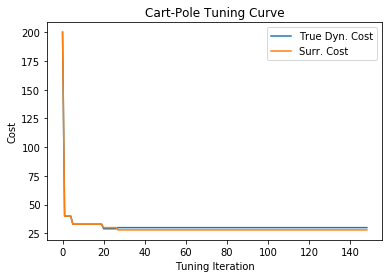

In [5]:
from autompc.graphs import TuningCurveGraph
import matplotlib.pyplot as plt

graph = TuningCurveGraph()

fig = plt.figure()      
ax = fig.gca()
graph(ax, tune_result)
ax.set_title("Cart-Pole Tuning Curve")
plt.show()

In [8]:
tune_result.inc_cfgs

[Configuration:
   _cost:ang_F, Value: 11.68655086587555
   _cost:ang_Q, Value: 3.7057055086740145
   _cost:angvel_F, Value: 206.6678164823677
   _cost:angvel_Q, Value: 0.0011089084611889328
   _cost:torque_R, Value: 3705.656863326308
   _ctrlr:_DirectTranscription:horizon, Value: 12
   _ctrlr:controller, Value: 'DirectTranscription'
   _model:_ARX:history, Value: 3
   _model:model, Value: 'ARX',
 Configuration:
   _cost:ang_F, Value: 1.2571360998151548
   _cost:ang_Q, Value: 184.690973575465
   _cost:angvel_F, Value: 5.4201427553058315
   _cost:angvel_Q, Value: 4.685592733919127
   _cost:torque_R, Value: 0.17296764544824475
   _ctrlr:_IterativeLQR:horizon, Value: 9
   _ctrlr:controller, Value: 'IterativeLQR'
   _model:_Koopman:method, Value: 'lstsq'
   _model:_Koopman:poly_basis, Value: 'false'
   _model:_Koopman:product_terms, Value: 'false'
   _model:_Koopman:trig_basis, Value: 'false'
   _model:model, Value: 'Koopman',
 Configuration:
   _cost:ang_F, Value: 1.2571360998151548
   _c

## Decoupled Tuning

The above example is full pipeline tuning, which searches the configuration space of all components simultaneously.  Alternatively, we can take a decoupled tuning approach, where the model is first tuned based on prediction accuracy, then the objective function and optimizer are tuned.  Since full pipeline tuning requires us to train a system ID model and simulate the controller at every iteration, decoupled tuning may produce faster tuning.

First, we'll need to handle the data split between system ID training set and surrogate training set manually.

In [6]:
rng = np.random.default_rng(100)
rng.shuffle(trajs)
surr_trajs = trajs[:250]
sysid_trajs = trajs[250:]

/home/william/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Now, we tune our system ID model for 75 iterations using the same model tuning method as above

In [7]:
model_evaluator = HoldoutModelEvaluator(holdout_prop=0.25, metric="rmse", horizon=20, trajs=sysid_trajs, 
                                        system=system, rng=np.random.default_rng(100))

model_tuner = ModelTuner(system, model_evaluator)
model_tuner.add_model_factory(model_factory)

model, model_tune_result = model_tuner.run(rng=np.random.default_rng(100), n_iters=75)

NameError: name 'HoldoutModelEvaluator' is not defined

Now, we construct a new pipeline which fixes the model to be the result of the tuning process we just ran

In [ ]:
pipeline_fixed_model = ampc.Pipeline(system, model, ctrlr_factory, cost_factory)

And finally, we run our pipeline tuning in a similar manner to above.  We now use tell the tuner to use 100% of data for tuning the surrogate, since we already handled the data split and did the system ID training

In [ ]:
tuner2 = PipelineTuner(surrogate_factory=MLPFactory(system), surrogate_split=1.0)


controller2, tune_result2 = tuner2.run(pipeline_fixed_model, task, surr_trajs, n_iters=75, 
                                      rng=np.random.default_rng(100), truedyn=benchmark.dynamics)

Finally, we can plot the result of our decoupled pipeline tune

In [ ]:
from autompc.graphs import TuningCurveGraph
import matplotlib.pyplot as plt

graph = TuningCurveGraph()

fig = plt.figure()      
ax = fig.gca()
graph(ax, tune_result2)
ax.set_title("Cart-Pole Decoupled Tuning Curve")
plt.show()